# Initialization

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# for p-value out of significance test
from scipy.stats import ttest_ind

# for image data handling
import os
from os.path import join, isfile, dirname
from PIL import Image

# Data Handling

In [2]:
%%capture
!unzip -n ../data/images.zip -d data

In [8]:
def genFromImage(imageDir, size=(8, 8)):
    dir = dirname(imageDir)
    dataFile = join(dir, "p4_data") + str(size) + ".npy"
    if isfile(dataFile):
        with open(dataFile, 'rb') as f:
            return np.load(f)
        # return np.genfromtxt(dataFile, delimiter=',').reshape(10, 6000, 8, 8)
    
    labels = os.listdir(imageDir)
    image_data = [[] for _ in labels]
    for label in labels:
        dir = join(imageDir, label)
        files = os.listdir(dir)
        image_data[int(label)] = np.array([np.array(Image.open(join(dir, file)).convert("L").resize(size), dtype='uint8') for file in files])
        
    image_data = np.array(image_data)
    with open(dataFile, 'wb') as f:
        np.save(f, image_data)
    # image_data.tofile(dataFile, sep = ',')
    return image_data

# returns X, Y, X_test, Y_test and classStats
def trainTestSplit(data, train_ratio, func):
    n = data.shape[0]
    m = int(np.floor(data.shape[1] * train_ratio))
    classStats = {}
    x_train, y_train, x_test, y_test = [[[] for _ in range(n)] for _ in range(4)]
    for label in range(n):
        x_train[label], y_train[label], classStats[label] = func(label, data[label][:m], True)
        x_test[label], y_test[label] = func(label, data[label][m:])
    
    X, Y, X_test, Y_test = [x.reshape(-1, x.shape[-1]) for x in [np.array(x) for x in [x_train, y_train, x_test, y_test]]]
    return X, Y.flatten(), X_test, Y_test.flatten(), classStats

def imgToFeatures(label, data, stats=False):
    X = np.array([x.flatten() for x in data]) / 255
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

In [13]:
dataFolder = "../data"
imageDir = join(dataFolder, "images")
imageDataDir = join(dataFolder, "p4_data.csv")

p1 = { "testDir": dataFolder + "/p1_test.csv", "trainDir": dataFolder + "/p1_train.csv" } # regression
p2 = { "testDir": dataFolder + "/p2_test.csv", "trainDir": dataFolder + "/p2_train.csv" } # regression
p3 = { "testDir": dataFolder + "/p3_test.csv", "trainDir": dataFolder + "/p3_train.csv" } # classification
p4 = {}                                                                                   # classification
p5 = {}                                                                                   # classification

p1["test"] = np.genfromtxt(p1["testDir"], delimiter=',')
p1["train"] = np.genfromtxt(p1["trainDir"], delimiter=',')
p2["test"] = np.genfromtxt(p2["testDir"], delimiter=',')
p2["train"] = np.genfromtxt(p2["trainDir"], delimiter=',')
p3["test"] = np.genfromtxt(p3["testDir"], delimiter=',')
p3["train"] = np.genfromtxt(p3["trainDir"], delimiter=',')
p4["data"] = genFromImage(imageDir)
p5["data"] = np.genfromtxt(dataFolder + "/PCA_MNIST.csv", delimiter=',')[1:]

print("------------------ Data Shapes ---------------------")
print("p1[train]:      ", p1["train"].shape, ", p1[test]: ", p1["test"].shape)
print("p2[train]:      ", p2["train"].shape, ", p2[test]: ", p2["test"].shape)
print("p3[train]:     ", p3["train"].shape, ", p3[test]: ", p3["test"].shape)
print("p4[data] :", p4["data"].shape)
print("p5[data] :     ", p5["data"].shape)

------------------ Data Shapes ---------------------
p1[train]:       (10000, 3) , p1[test]:  (5000, 3)
p2[train]:       (10000, 4) , p2[test]:  (5000, 4)
p3[train]:      (60000, 11) , p3[test]:  (15000, 11)
p4[data] : (10, 6000, 8, 8)
p5[data] :      (60000, 11)


# Custom functions for SVM

In [137]:
# Compute mean squared error
def mse(X, Y, W):
    return (1/2) * (X @ W - Y) @ (X @ W - Y)

# Compute mean absolute error
def mae(X, Y, W):
    return np.sum(np.abs(X @ W - Y))

# Normalize a vector
def normalize(v):
    min = v.min()
    max = v.max()
    return (v - min) / (max - min)

# Standardize a vector
def standardize(v):
    mean = np.mean(v)
    std = np.std(v)
    return (v - mean) / std

# Normalize and split the training data into features matrix with bias and the result vector
def parseData(data):
    m, n = data.shape
    data = np.array([normalize(col) for col in data.T]).T
    X = np.c_[np.ones(m), data.T[:-1].T]
    Y = data.T[-1].T
    return X, Y

# Print the required metrics
def printResult(x_train, y_train, x_test, y_test, func = lambda x : x):
    x_train = func(x_train)
    x_test = func(x_test)
    
    m, n = x_train.shape
    w = np.linalg.pinv(x_train) @ y_train

    mse_train = mse(x_train, y_train, w)
    mae_train = mae(x_train, y_train, w)
    p_train = ttest_ind(x_train @ w, y_train).pvalue
    mse_test = mse(x_test, y_test, w)
    mae_test = mae(x_test, y_test, w)
    p_test = ttest_ind(x_test @ w, y_test).pvalue
    
    print("MSE (train-split)     : ", mse_train)
    print("MAE (train-split)     : ", mae_train)
    print("p-value (train-split) : ", p_train)

    print("--------------------------------------")

    print("a) MSE     : ", mse_test)
    print("b) MAE     : ", mae_test)
    print("c) p-value : ", p_test)
    return [mse_train, mae_train, p_train], [mse_test, mae_test, p_test]

# P1 (SVM)

- For the classification problems given in A1, implement SVMs both with and without slack formulations. 
- Experiment with at least 3 Kernels and grid search on hyper-parameters on different kernels.
- Report your observations (you can use standard python library, LibSVM and need not implement SMO). 
- For multi-class classification, implement a one-vs-rest approach.

**DATA:** `p1train/test.csv`

In [139]:
X, Y = parseData(p1["train"])
X_test, Y_test = parseData(p1["test"])

# Initialise the parameters to be a null vector
W = np.array([0, 0, 0])

X, Y, W
# Check metrics with parameters as null vector
print(mse(X, Y, W))
print(mae(X, Y, W))

1476.0901088253356
5019.547076086856


## Linear regression
$h(x) = w_0 + w_1x_1 + w_2x_2$

In [140]:
p1["result"] = printResult(X, Y, X_test, Y_test)

MSE (train-split)     :  1.6377431789576247
MAE (train-split)     :  144.16318383122172
p-value (train-split) :  0.9999999999998793
--------------------------------------
a) MSE     :  1.0198792104638341
b) MAE     :  81.01047477588321
c) p-value :  0.030717508773848688


# P2 (SVM)

Implement FLDA for the classification problems in A1 and report the metrics as in A1

- Mean Squared Error
- Mean Absolute Error
- p-value out of significance test

**DATA**: `p3train/test.csv`, `images.zip`, 

In [141]:
p2["train"].shape, p2["test"].shape

((10000, 4), (5000, 4))

In [142]:
X, Y = parseData(p2["train"])
X_test, Y_test = parseData(p2["test"])

# Initialise the parameters to be a null vector
W = np.array([0, 0, 0, 0])

# Check metrics with parameters as null vector
print(mse(X, Y, W))
print(mae(X, Y, W))

93.14053909693217
729.3773208010364


## Linear regression
$h(x) = w_0 + w_1x_1 + w_2x_2 + w_3x_3$

In [143]:
p2["result"] = [[] for _ in range(8)]
p2["result"][0] = printResult(X, Y, X_test, Y_test)

MSE (train-split)     :  64.04261865353428
MAE (train-split)     :  792.8424805196497
p-value (train-split) :  1.0
--------------------------------------
a) MSE     :  34.45351730675273
b) MAE     :  402.40621699350675
c) p-value :  0.04567218862928123


## Non-Linear regression (1)
$h_1(x) = w_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_1x_2 + w_5x_2x_3 + w_6x_3x_1 + w_7x_1^2 + w_8x_2^2 + w_9x_3^2$

In [144]:
def makeQuadratic(data):
    n = data.shape[1]
    return np.array([data.T[i] * data.T[j] for i in range(n) for j in range(n) if j <= i]).T

p2["result"][1] = printResult(X, Y, X_test, Y_test, makeQuadratic)

MSE (train-split)     :  15.025195918707364
MAE (train-split)     :  414.43543405251074
p-value (train-split) :  0.9999999999995892
--------------------------------------
a) MSE     :  8.293925461081386
b) MAE     :  214.73836188569697
c) p-value :  0.6539657025513983


## Non-Linear regression (2)
$h_2(x) = w_0 + w_1x_1 + w_2x_2 + w_3x_3$
     $+ w_4x_1x_2 + w_5x_2x_3 + w_6x_3x_1 + w_7x_1^2 + w_8x_2^2 + w_9x_3^2$
     $+ w_{10}x_1x_2x_3 + w_{11}x_1^2x_2 + w_{12}x_2^2x_1 + w_{13}x_2^2x_3 + w_{14}x_3^2x_2 + w_{15}x_3^2x_1 + w_{16}x_1^2x_3 + w_{17}x_1^3 + w_{18}x_2^3 + w_{19}x_3^3$

In [145]:
def makeCubic(data):
    n = data.shape[1]
    return np.array([data.T[i] * data.T[j] * data.T[k] for i in range(n) for j in range(n) for k in range(n) if j <= i and k <= j]).T

p2["result"][2] = printResult(X, Y, X_test, Y_test, makeCubic)

MSE (train-split)     :  14.015061295947277
MAE (train-split)     :  403.4520118357519
p-value (train-split) :  0.9999999999999714
--------------------------------------
a) MSE     :  7.792580568256314
b) MAE     :  210.3268643472337
c) p-value :  0.6337887955340187


## Non-Linear regression (3)
$h_3(x) = h_1(h_1(x))$

In [146]:
p2["result"][3] = printResult(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeQuadratic(x)))

MSE (train-split)     :  0.8243996952040266
MAE (train-split)     :  97.24998340500956
p-value (train-split) :  0.9999999999995098
--------------------------------------
a) MSE     :  0.47367918630981265
b) MAE     :  48.4986710732787
c) p-value :  0.44918301185120135


## Non-Linear regression (4)
$h_4(x) = h_1(h_2(x))$

In [147]:
p2["result"][4] = printResult(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeCubic(x)))

MSE (train-split)     :  0.016265667882183227
MAE (train-split)     :  10.770107850314911
p-value (train-split) :  0.999999999986867
--------------------------------------
a) MSE     :  0.03926868382605306
b) MAE     :  10.629900379280002
c) p-value :  0.42898862281953176


## Non-Linear regression (5)
$h_5(x) = h_2(h_2(x))$

In [148]:
p2["result"][5] = printResult(X, Y, X_test, Y_test, lambda x : makeCubic(makeCubic(x)))

MSE (train-split)     :  0.015762615029126598
MAE (train-split)     :  10.675718560412275
p-value (train-split) :  0.9999999999146658
--------------------------------------
a) MSE     :  0.03979982849860955
b) MAE     :  10.671505405575594
c) p-value :  0.4293311009552302


## Non-Linear regression (6)
$\phi(x) = \sum_{i=0, j=0, i \neq j}^n w_{ij} x_ie^{x_j} + \sum_{i=0}^n w_{ii} x_ie^{x_i}$

$h_6(x) = \phi(h_1(x))$

In [149]:
def makeExp(data):
    n = data.shape[1]
    return np.array([data.T[i] * np.exp(data.T[j]) for i in range(n) for j in range(n) if i != j] + [data.T[i] * np.exp(data.T[i]) for i in range(n)]).T

p2["result"][6] = printResult(X, Y, X_test, Y_test, lambda x : makeExp(makeQuadratic(x)))

MSE (train-split)     :  0.01657736594080365
MAE (train-split)     :  11.059370346143844
p-value (train-split) :  0.9999999644023003
--------------------------------------
a) MSE     :  0.03941869125570922
b) MAE     :  10.746865814541174
c) p-value :  0.4282532953053031


## Non-Linear regression (7)
$h_7(x) = \phi(h_2(x))$

In [150]:
p2["result"][7] = printResult(X, Y, X_test, Y_test, lambda x : makeExp(makeCubic(x)))

MSE (train-split)     :  0.015293426509348219
MAE (train-split)     :  10.688583380035912
p-value (train-split) :  0.9365993155260983
--------------------------------------
a) MSE     :  0.04209638251358401
b) MAE     :  11.098570146056602
c) p-value :  0.39757197242435915


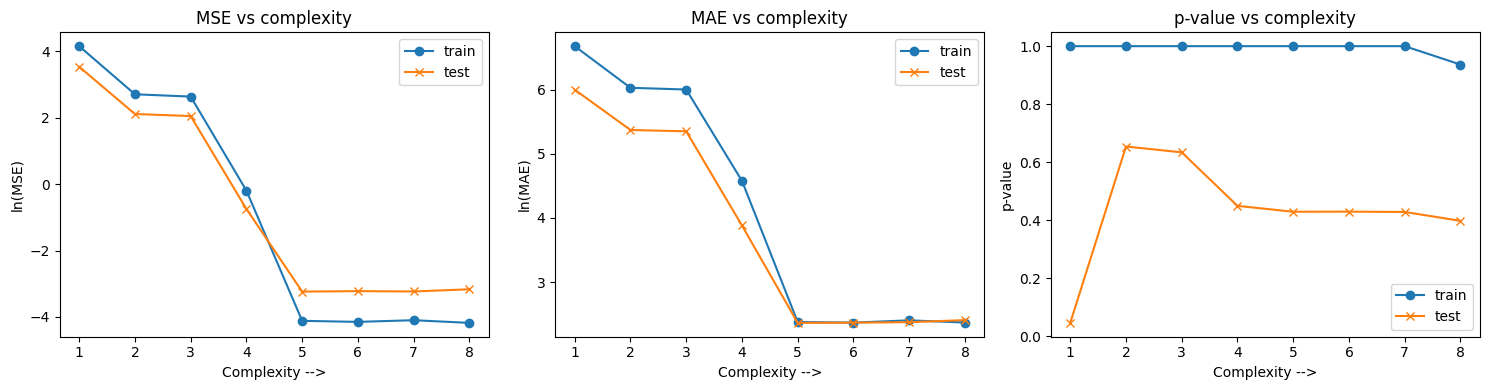

In [151]:
results = np.array(p2["result"])
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot([i + 1 for i in range(8)], [np.log(row[0][0]) for row in results], label="train", marker='o')
ax[0].plot([i + 1 for i in range(8)], [np.log(row[1][0]) for row in results], label="test", marker='x')
ax[0].set_xlabel("Complexity -->")
ax[0].set_ylabel("ln(MSE)")
ax[0].legend()
ax[0].set_title("MSE vs complexity")

ax[1].plot([i + 1 for i in range(8)], [np.log(row[0][1]) for row in results], label="train", marker='o')
ax[1].plot([i + 1 for i in range(8)], [np.log(row[1][1]) for row in results], label="test", marker='x')
ax[1].set_xlabel("Complexity -->")
ax[1].set_ylabel("ln(MAE)")
ax[1].legend()
ax[1].set_title("MAE vs complexity")

ax[2].plot([i + 1 for i in range(8)], [(row[0][2]) for row in results], label="train", marker='o')
ax[2].plot([i + 1 for i in range(8)], [(row[1][2]) for row in results], label="test", marker='x')
ax[2].set_xlabel("Complexity -->")
ax[2].set_ylabel("p-value")
ax[2].legend()
ax[2].set_title("p-value vs complexity")

fig.tight_layout()

In [152]:
a = np.array([[1, 2,2], [4, 3,5]])
(a.T / np.sum(a, axis=1)).T

array([[0.2       , 0.4       , 0.4       ],
       [0.33333333, 0.25      , 0.41666667]])

In [153]:
# means = [np.mean(a) + np.random.rand(3)]
covs = [np.diag(np.random.rand(3) * 2 + 0.5)]
print(covs)

[array([[0.56877704, 0.        , 0.        ],
       [0.        , 2.3186408 , 0.        ],
       [0.        , 0.        , 1.01755996]])]


# P3 (SVM)

For the regression problem p1 in A1, overfit the data with over-parameterized models (at least 3). 
In the next part, impose different types of regularizers (L2, L1, and a combination of both) and 
plot the bias-variance curves.

**DATA**: `p1train/test.csv`

# Custom functions for Neural Networks

In [327]:
max_float = np.finfo("float64").max
max_exp = np.log(max_float)

def normal(x, mean ,cov, *args):
    n = len(mean)
    val = -0.5 * (x - mean) @ np.linalg.pinv(cov) @ (x - mean)
    return np.exp(val) if np.abs(val) < max_exp else (1/max_float) / ((2 * np.pi * np.linalg.det(cov)) ** (n/2) + 1e-8)

def logGMM(x, mean, cov, weights, *args):
    k = len(weights)
    val = np.log(np.sum([weights[i] * normal(x, mean[i], cov[i]) for i in range(k)]) + 1e-8)
    return val

def logNormal(x, mean, cov, *args):
    n = mean.shape[0]
    return - 0.5 * (n * np.log(2 * np.pi * np.linalg.det(cov)) + ((x - mean) @ np.linalg.inv(cov) @ (x - mean).T))

# assume independent features
def logExp(x, mean, *args):
    return - np.log(np.abs(np.prod(mean))) - np.reciprocal(mean) @ x

def naiveLogNormal(x, u, v, *args):
    return -0.5 * np.sum([np.log(2 * np.pi * v[i][i]) + (x[i] - u[i]) * (x[i] - u[i])/v[i][i] for i in range(u.shape[0]) if v[i][i] > 0])

# X -> data, k -> number of normal densities
def em(X, k, max_iter = 100, random_seed=42):
    # m -> number of datapoints, n -> number of features
    m, n = X.shape
    eps = 1e-8
    # initialization
    np.random.seed(random_seed)
    weights = np.random.dirichlet(np.ones(k))
    means = [np.mean(X) + np.random.rand(n) for _ in range(k)]
    covs = [np.diag(np.random.rand(n) * 2 + 0.5) for _ in range(k)]
    
    for i in range(max_iter):
        # if np.sum(weights) == 0:
        #     weights = np.ones(k) / k
            
        # Expectation step
        probs = np.array([[normal(x, means[i], covs[i]) * weights[i] for i in range(k)] for x in X])
        probs = (probs.T / np.sum(probs, axis=1)).T
        
        # Maximization step
        old_means = means.copy()
        covs = [(X - means[i]).T @ np.diag(probs.T[i]) @ (X - means[i]) / (np.sum(probs.T[i]) + 1e-8) for i in range(k)]
        means = [X.T @ probs.T[i] / (np.sum(probs.T[i]) + 1e-8)  for i in range(k)]
        weights = np.sum(probs, axis=0) / m
        
        if np.linalg.norm(np.array(means) - np.array(old_means)) < 1e-8:
            break
        
    return weights, means, covs

def classify(x, classStats, density):
    label = -1
    max = -99999
    sum = 0
    prob = []
    for key in classStats:
        mean = classStats[key]["mean"]
        cov = classStats[key]["cov"]
        prior = classStats[key]["prior"]
        weights = classStats[key]["weights"] if "weights" in classStats[key] else []
        value = np.log(prior) + density(x, mean, cov, weights)
        prob.append(value)
        sum += value
        if value > max:
            max, label = value, key
    return np.r_[[label], (np.array(prob) / sum)]

In [317]:
class metrics:
    def accuracy(predicted, actual):
        m = actual.size
        correctCount = sum([1 if int(predicted[i]) == int(actual[i]) else 0 for i in range(m)])
        return correctCount / m
    
    def confusionMatrix(predicted, actual, n = 5):
        cnf = np.zeros((n, n), dtype='uint')
        for i in range(actual.size):
            cnf[int(actual[i])][int(predicted[i])] += 1
        return cnf
    
    def f1Score(cnf):
        sum_predict = np.sum(cnf, axis=0)
        sum_actual  = np.sum(cnf, axis=1)
        f1 = np.zeros(cnf.shape[1])
        for i in range(f1.size):
            TP = cnf[i][i]
            FP, FN = sum_predict[i] - TP, sum_actual[i] - TP
            p, r = TP/(TP + FP + 1e-8), TP/(TP + FN + 1e-8)
            f1[i] = 2 * p * r / (p + r + 1e-8)
        return f1
    
    def roc(predict, actual, prob, ax, labels=[0, 1], thresolds=[0, 0.2, 0.4, 0.6, 0.8, 1]):
        for label in labels:
            tp, fp, tn, fn = [np.zeros(len(thresolds)) for _ in range(4)]
            for t in range(len(thresolds)):
                for i in range(actual.shape[0]):
                    if float(prob[i][label]) >= thresolds[t]:
                        if actual[i] == 0:
                            tp[t] += 1.0
                        else:
                            fp[t] += 1.0
                    else:
                        if actual[i] == 0:
                            fn[t] += 1.0
                        else:
                            tn[t] += 1.0
                        
            fpr = fp / (fp + tn + 1e-8)
            tpr = tp / (tp + fn + 1e-8)
            ax.plot(fpr, tpr, label=label, marker='x')        
        
        ax.set_xlabel("False positive rate")
        ax.set_ylabel("True positive rate")
        ax.legend()
        
    
    def print(X, Y, X_test, Y_test, classStats, density, result=True):
        n_labels = len(classStats)
        train = np.array([classify(x, classStats, density) for x in X])
        test = np.array([classify(x, classStats, density) for x in X_test])
        # train = classify(X, classStats, density)
        # test = classify(X, classStats, density)
        y_train, p_train = train.T[0], train.T[1:].T
        y_test, p_test = test.T[0], test.T[1:].T
                
        cnf_train = metrics.confusionMatrix(y_train, Y, n_labels)
        cnf_test = metrics.confusionMatrix(y_test, Y_test, n_labels)
        acc_train = metrics.accuracy(y_train, Y)
        acc_test = metrics.accuracy(y_test, Y_test)
        f1_train = metrics.f1Score(cnf_train)
        f1_test = metrics.f1Score(cnf_test)
        
        print("------------------ Train ---------------------")
        print("Classification Accuracy : ", acc_train)
        print("F1 Score                : ", f1_train)
        print("------------------ Test ----------------------")
        print("Classification Accuracy : ", acc_test)
        print("F1 Score                : ", f1_test)
        # print("Confusion Matrix        : ")
        # print(cnf_test)
        
        fig, ax = plt.subplots(2, 2, figsize=(16, 16))
        ax[0][0].matshow(cnf_train.T, cmap='GnBu')
        ax[0][0].set_xlabel("Predicted")
        ax[0][0].set_ylabel("Actual")
        ax[0][0].set_title("Confusion Matrix (train)")
        for (x, y), value in np.ndenumerate(cnf_train):
            ax[0][0].text(x, y, f"{value: d}", va="center", ha="center")
        
        ax[0][1].matshow(cnf_test.T, cmap='GnBu')
        ax[0][1].set_xlabel("Predicted")
        ax[0][1].set_ylabel("Actual")
        ax[0][1].set_title("Confusion Matrix (test)")
        for (x, y), value in np.ndenumerate(cnf_test):
            ax[0][1].text(x, y, f"{value: d}", va="center", ha="center")
        
        thresolds = [i/100 for i in range(100)]
        metrics.roc(y_train, Y, p_train, ax[1][0], thresolds=thresolds)
        metrics.roc(y_test, Y_test, p_test, ax[1][1], thresolds=thresolds)
        ax[1][0].set_title("ROC (train)")
        ax[1][1].set_title("ROC (test)")
        
        if result:
            return [acc_train, f1_train], [acc_test, f1_test]

# P4 (Neural Networks, MLP)

- Construct a Multi-layer Perception (MLP) or a feed-forward neural network to work on the K-MNIST dataset. 
- Experiment with at least 3 settings of the number of hidden layers and Neurons. 
- Explicitly code the Error Backpropagation algorithm as a class and use it on MLPs with different architectures and loss functions (CE, squared error loss).
- For this part, you should only use Numpy. 

Report the accuracy and F1 scores with all the considered configurations.

**DATA:** `p3train/test.csv`

## Data Handling

In [156]:
p3["train"].shape, p3["test"].shape

((60000, 11), (15000, 11))

In [157]:
classStats = {}
for row in p3["train"]:
    label = int(row[-1]) - 1
    if label in classStats:
        classStats[label].append(row[:-1])
    else:
        classStats[label] = [row[:-1]]

# classStats = [np.array(data) for data in classStats]
for i in range(len(classStats)):
    data = np.array(classStats[i])
    classStats[i] = { "mean": np.mean(data, axis=0), "cov": np.cov(data.T), "prior": data.shape[0], "data": data }

In [320]:
def splitData(data):
    # X = np.array([normalize(col) for col in data.T[:-1]]).T
    X = data.T[:-1].T
    Y = data.T[-1].T.astype("int") - 1
    return X, Y

X, Y = splitData(p3["train"])
X_test, Y_test = splitData(p3["test"])

X.shape, Y.shape, X_test.shape, Y_test.shape

((60000, 10), (60000,), (15000, 10), (15000,))

## Bayes' classifier with normal distribution

------------------ Train ---------------------
Classification Accuracy :  0.5906666666666667
F1 Score                :  [0.55688598 0.57825972 0.64442454 0.60400323 0.57840442]
------------------ Test ----------------------
Classification Accuracy :  0.5884
F1 Score                :  [0.54269882 0.57421581 0.64145558 0.597958   0.59275452]


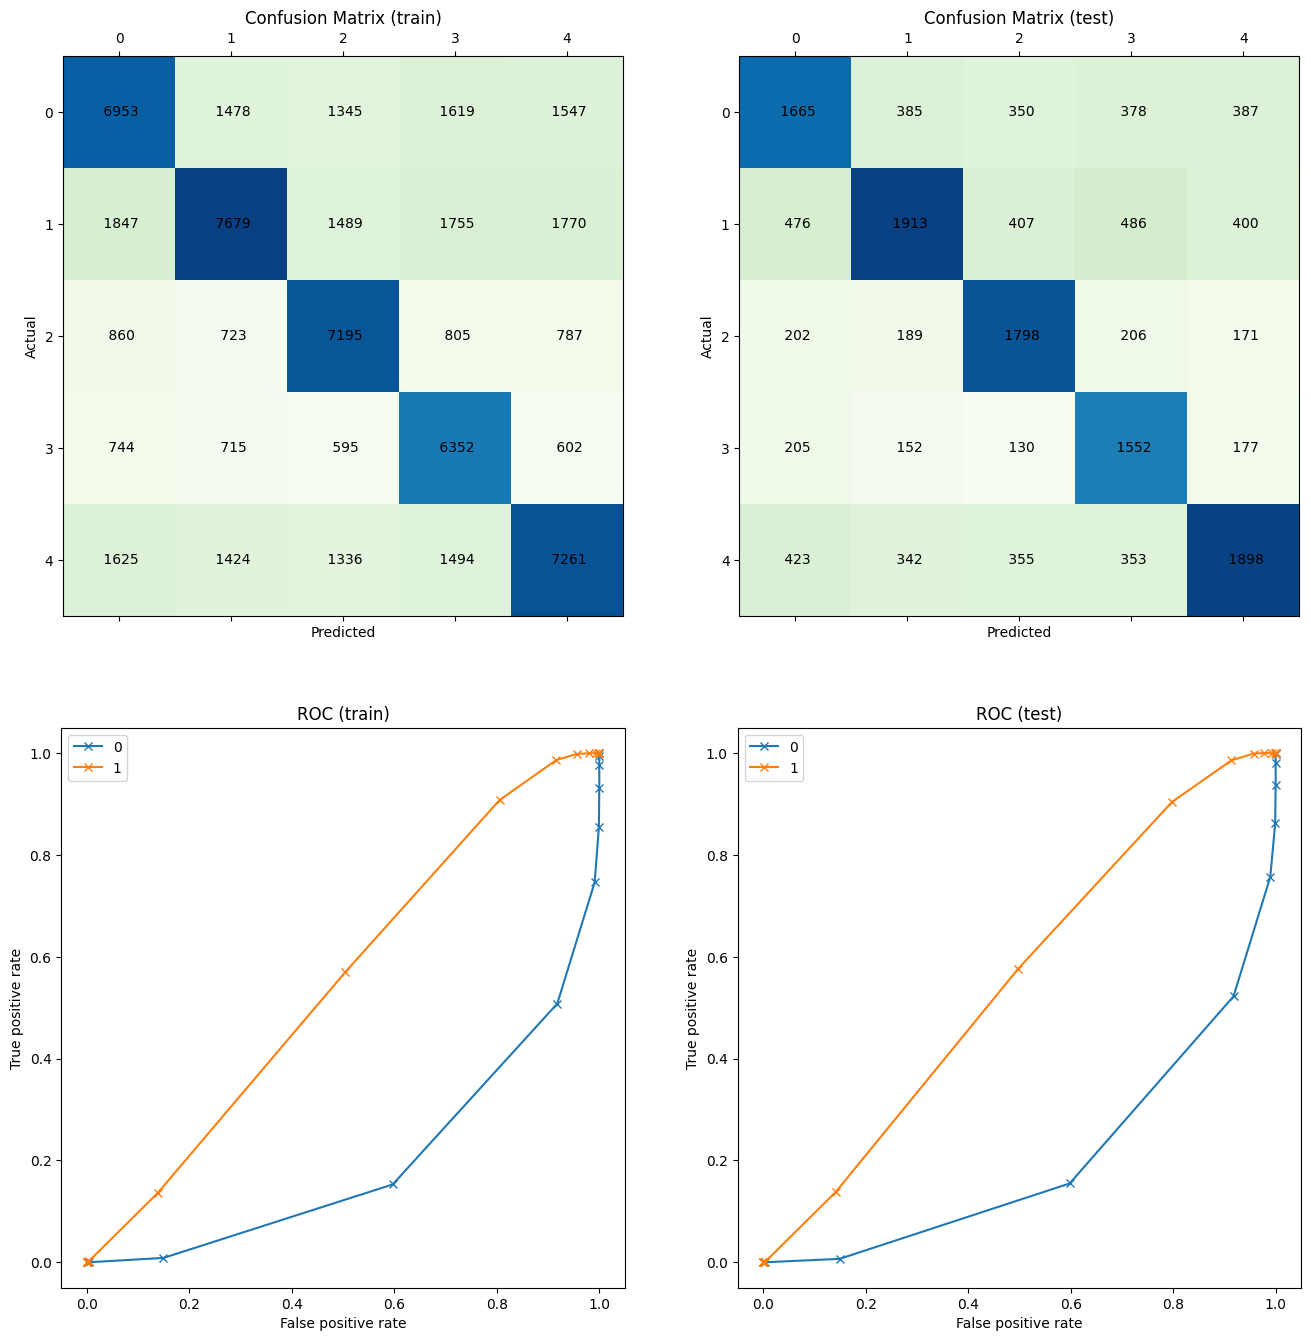

In [318]:
p3["result"] = [[] for _ in range(5)]
p3["result"][0] = metrics.print(X, Y, X_test, Y_test, classStats, logNormal)

## Bayes' classifier with exponential distribution

------------------ Train ---------------------
Classification Accuracy :  0.20075
F1 Score                :  [0.28484541 0.05314039 0.22726558 0.01323236 0.24428515]
------------------ Test ----------------------
Classification Accuracy :  0.20113333333333333
F1 Score                :  [0.27855224 0.05824259 0.22509225 0.01099256 0.25139106]


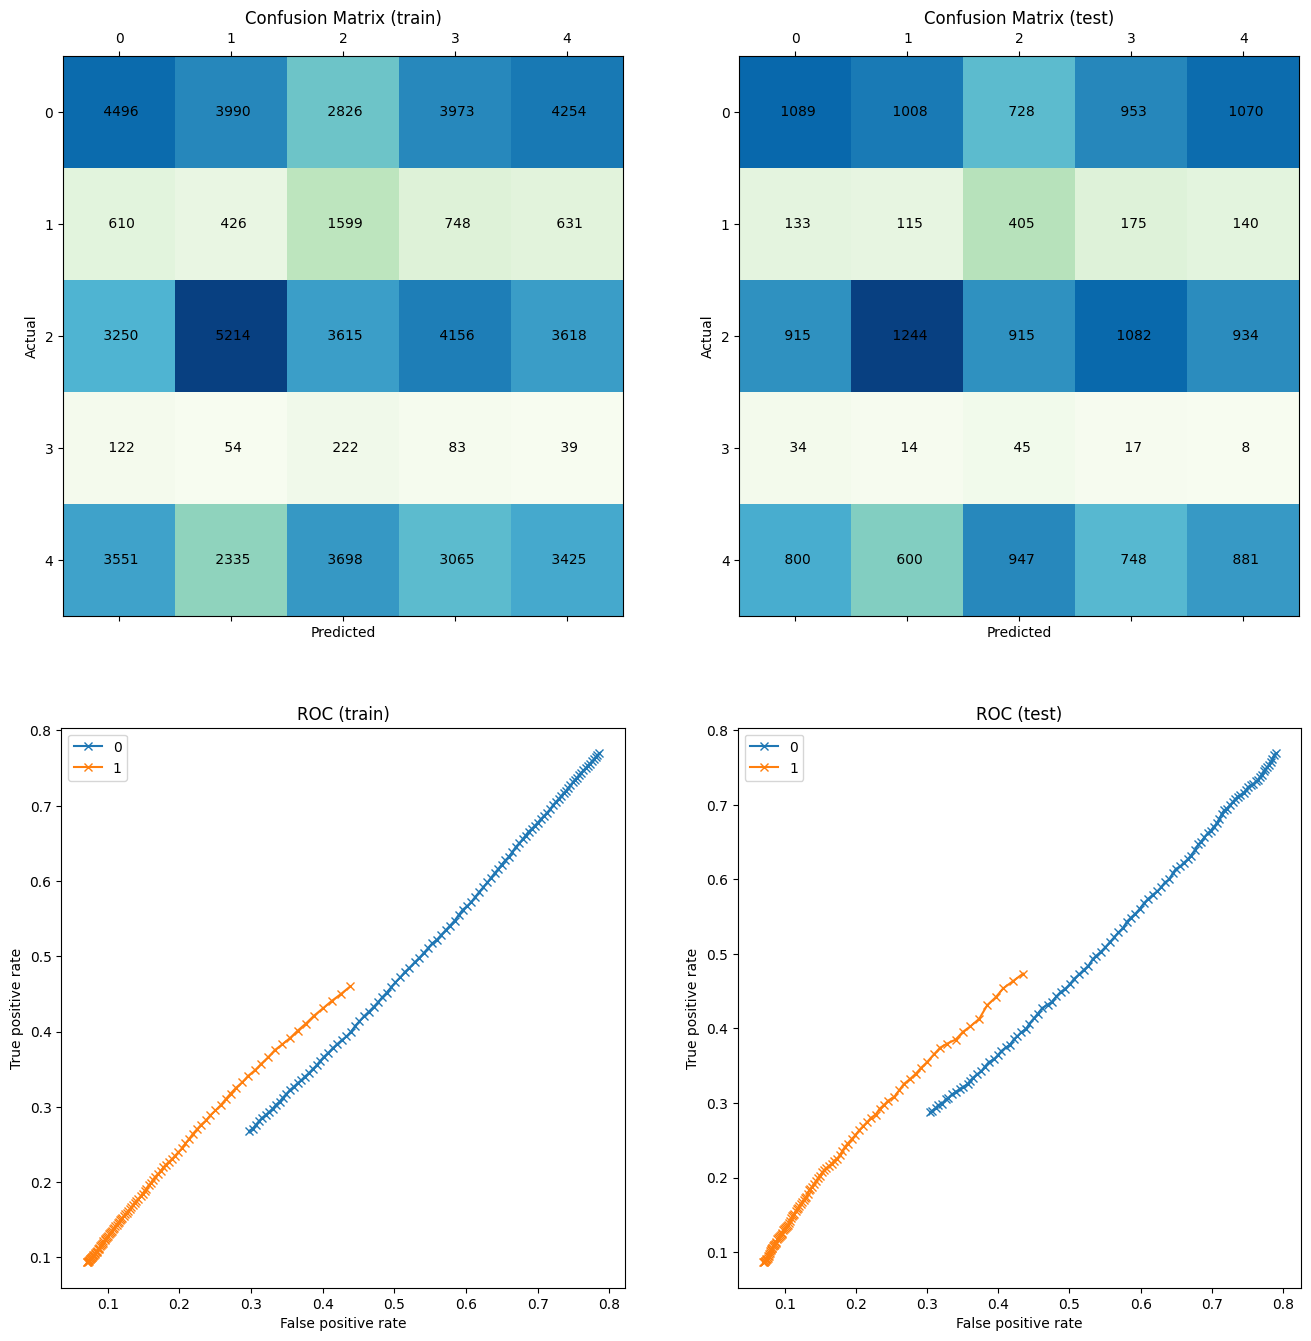

In [160]:
p3["result"][1] = metrics.print(X, Y, X_test, Y_test, classStats, logExp)

## Bayes' classifier with GMM distribution

In [299]:
def printGmmP3(number_of_guassians , max_iter = 50):
    classStatsGMM = {}
    for label in classStats:
        classStatsGMM[label] = { "prior": classStats[label]["prior"] }
        classStatsGMM[label]["weights"], classStatsGMM[label]["mean"], classStatsGMM[label]["cov"] = em(classStats[label]["data"], number_of_guassians, max_iter)
        print("weights of class ", str(label + 1), ": ", classStatsGMM[label]["weights"])

    metrics.print(X, Y, X_test, Y_test, classStatsGMM, logGMM, result=False)

weights of class  1 :  [0.03059404 0.96921935]
weights of class  5 :  [0.4332758  0.56653239]
weights of class  2 :  [0.76328575 0.23656407]
weights of class  3 :  [0.03564662 0.96423244]
weights of class  4 :  [0.99623067 0.00358604]
[[6845 1381 1081 1410 1312]
 [1527 6929  974 1357 1232]
 [1221 1025 7620 1063 1031]
 [1386 1145  918 7474 1102]
 [1570 1348 1044 1260 6745]]
[[1647  351  256  378  339]
 [ 410 1729  267  285  290]
 [ 314  288 1898  265  275]
 [ 325  327  244 1823  256]
 [ 382  310  233  330 1778]]
------------------ Train ---------------------
Classification Accuracy :  0.59355
F1 Score                :  [0.55700219 0.58112131 0.64584481 0.6079141  0.57676685]
------------------ Test ----------------------
Classification Accuracy :  0.5916666666666667
F1 Score                :  [0.54455281 0.57768125 0.63927248 0.60204755 0.59554513]


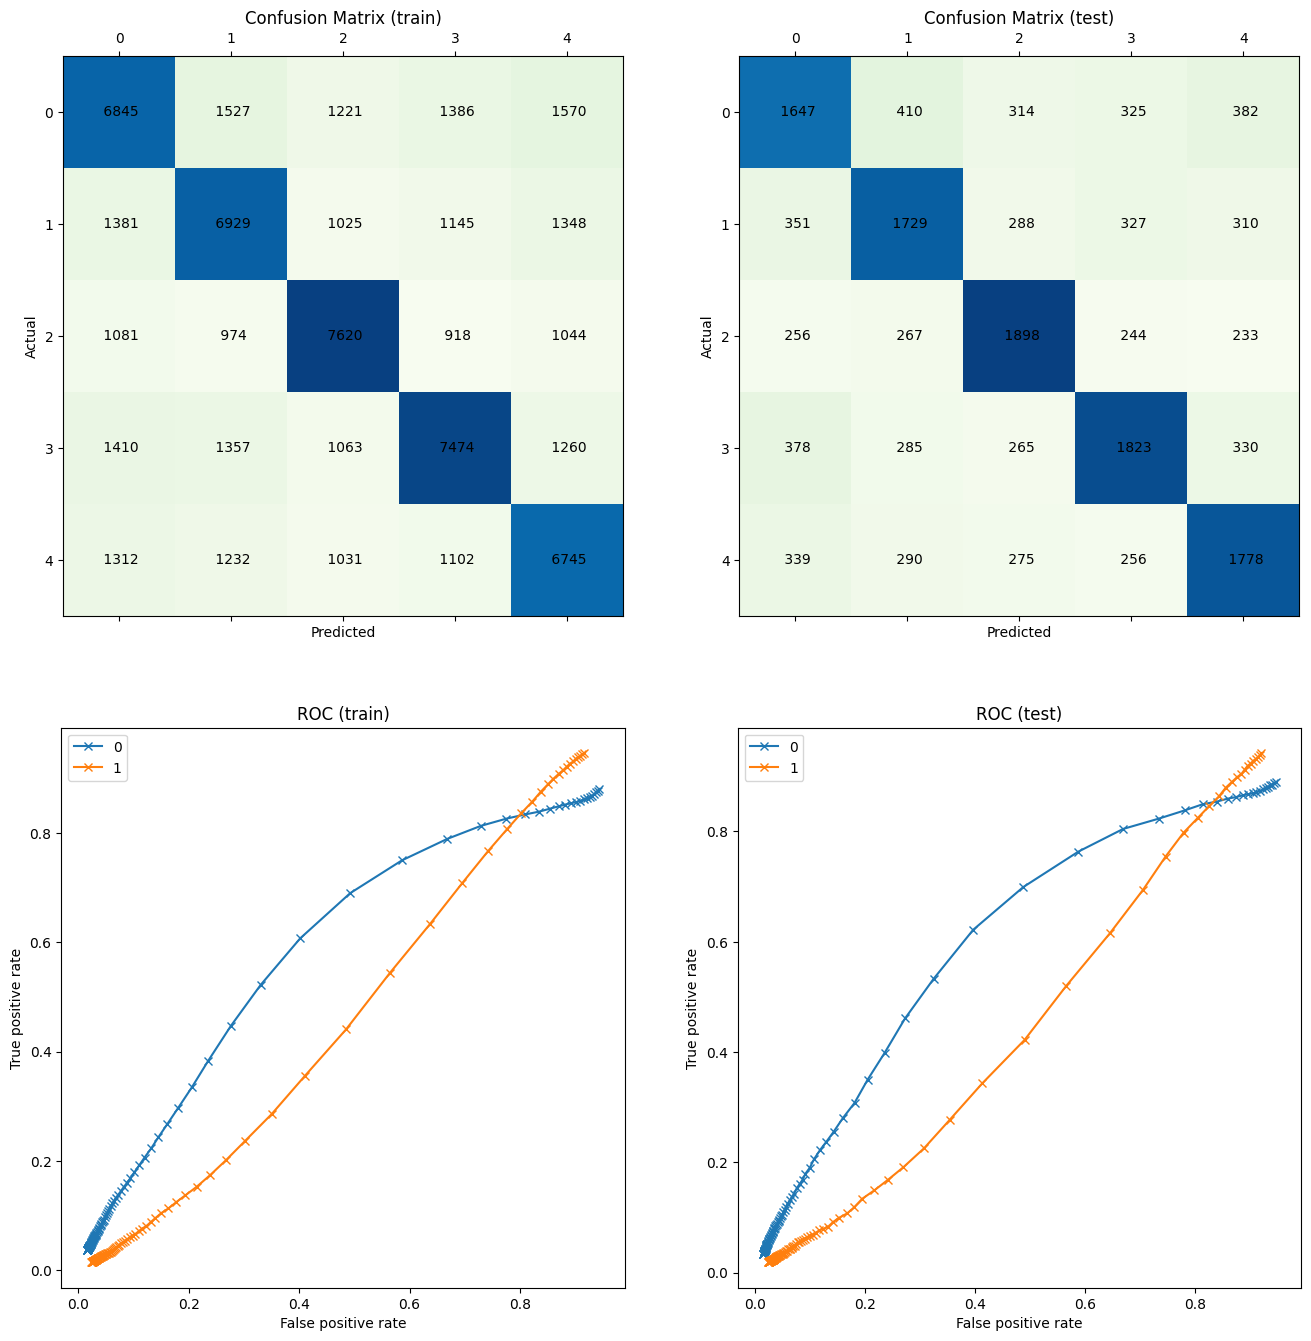

In [300]:
printGmmP3(2)

weights of class  1 :  [9.99770897e-001 1.04310646e-261 1.19155444e-180 1.47420139e-244
 3.58932211e-244]
weights of class  5 :  [2.15055546e-032 1.37615949e-198 9.99803298e-001 2.06358019e-288
 1.91240946e-017]
weights of class  2 :  [1.54240603e-018 9.04138182e-001 1.55061764e-192 6.71897488e-029
 9.58198476e-002]
weights of class  3 :  [9.99546379e-001 1.72447576e-220 2.14318634e-297 2.29973551e-254
 3.06255008e-004]
weights of class  4 :  [1.07191388e-227 5.54954734e-004 8.30161541e-005 9.99225385e-001
 1.59583603e-158]
[[6653 1469 1132 1393 1382]
 [1409 7061 1004 1281 1264]
 [1128 1077 7682 1013 1060]
 [1301 1223  956 7392 1153]
 [1434 1402 1088 1213 6830]]
[[1611  365  267  364  364]
 [ 369 1768  276  273  295]
 [ 287  301 1919  251  282]
 [ 309  340  252 1814  260]
 [ 359  326  234  312 1802]]
------------------ Train ---------------------
Classification Accuracy :  0.5936333333333333
F1 Score                :  [0.55548133 0.5823265  0.64495004 0.60796973 0.57744335]
-----------

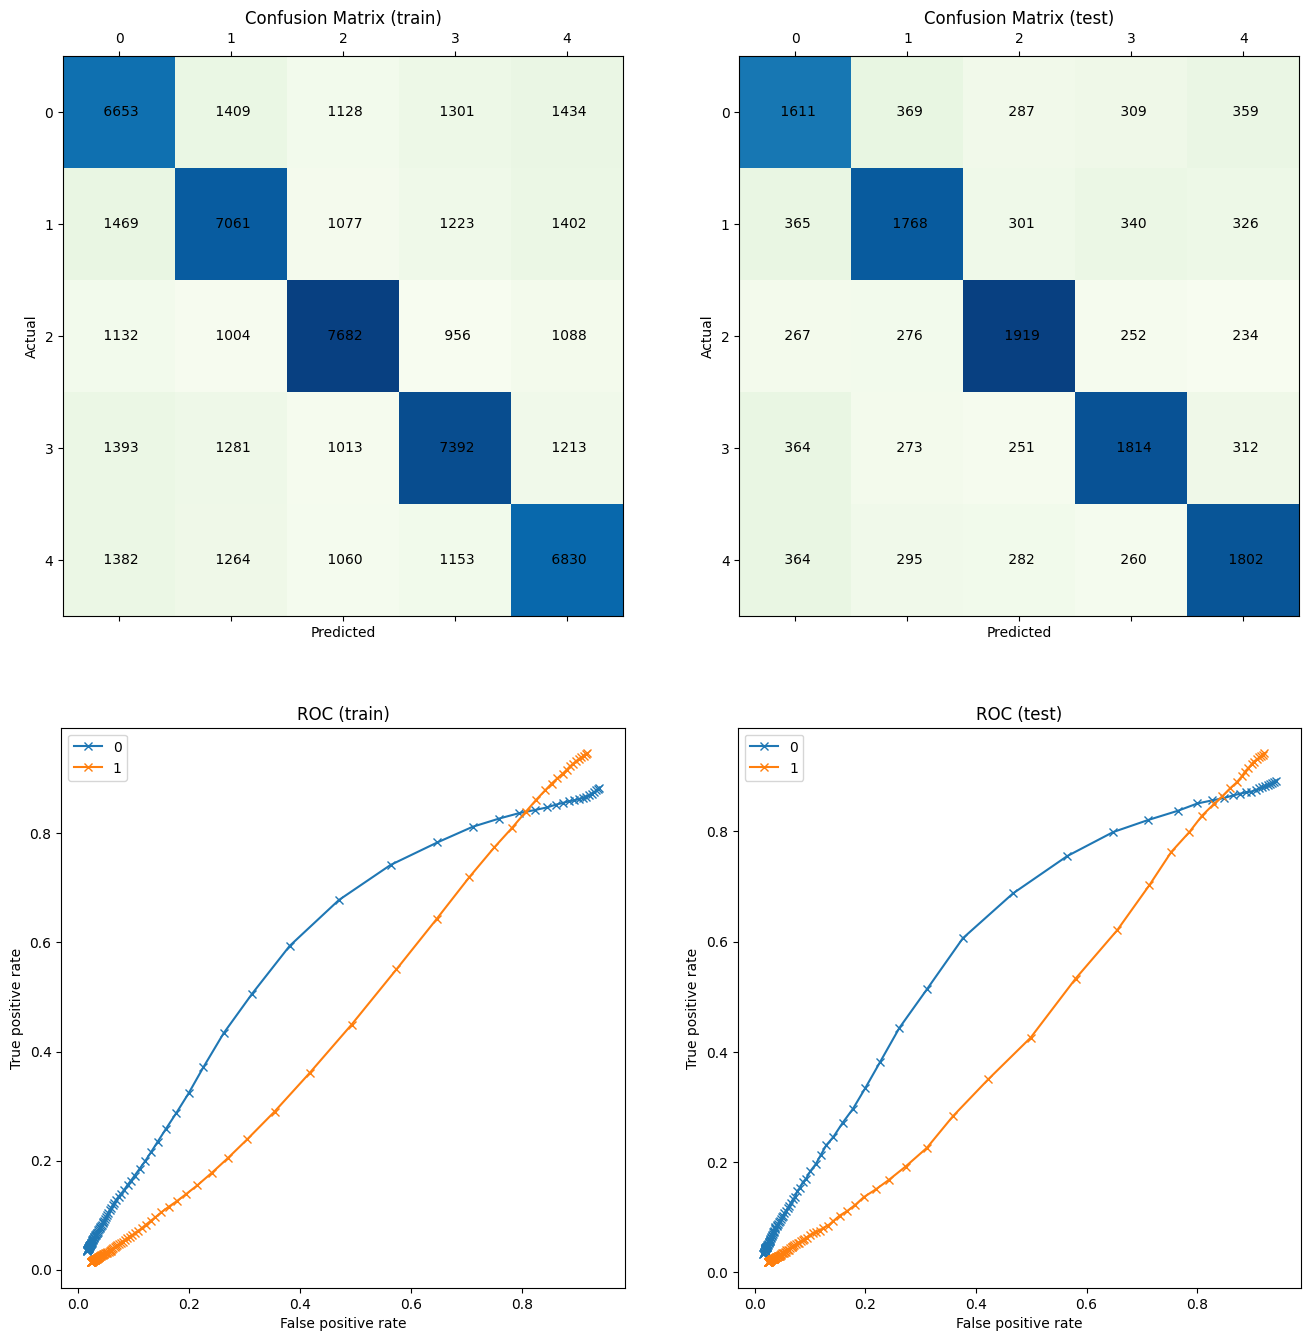

In [301]:
printGmmP3(5)

In [ ]:
printGmmP3(8)

## Logistic Regression

Stopping criterion met
Test accuracy: 0.573
Training empirical risk: 1.1430550942477484
Training error rate: 0.42965
Test empirical risk: 1.140569406881138
Test error rate: 0.42700000000000005
Class-wise F1 score:
[0.51782363 0.56104411 0.62377715 0.58158644 0.57931034]


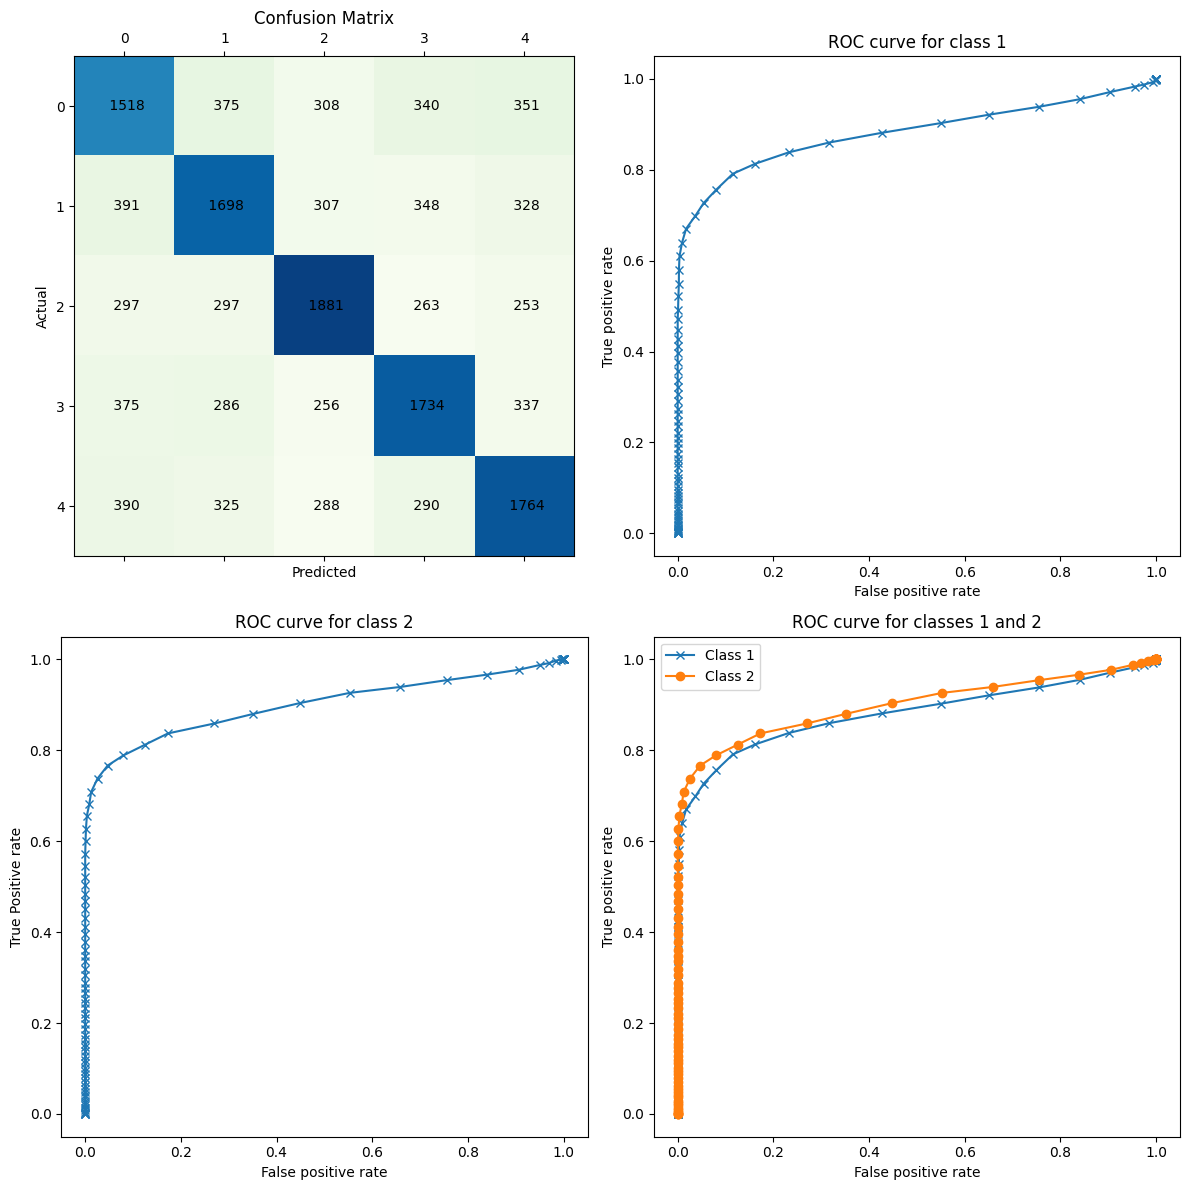

In [218]:
train_data = p3["train"]
test_data = p3["test"]

# Split data into features and labels
X_train = train_data[:, :-1]
y_train_orig = train_data[:, -1]
X_test = test_data[:, :-1]
y_test_orig = test_data[:, -1]

# One-hot encode target variable
num_classes = 5
num_samples = y_train_orig.shape[0]
y_train = np.zeros((num_samples, num_classes))
for i in range(num_samples):
    y_train[i, int(y_train_orig[i]) - 1] = 1


# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Define softmax function
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


# Initialize weights and biases
num_features = X_train.shape[1]
W = np.random.randn(num_features, num_classes)
b = np.random.randn(num_classes)

# Set hyperparameters
learning_rate = 0.1
num_iterations = 1000
epsilon = 1e-8

# Train model using gradient descent
prev_loss = float('inf')
for i in range(num_iterations):
    # Forward propagation
    z = np.dot(X_train, W) + b
    y_pred = softmax(z)

    # Compute loss
    loss = -np.sum(y_train * np.log(y_pred + epsilon)) / num_samples

    # Backward propagation
    dz = y_pred - y_train
    dW = np.dot(X_train.T, dz) / num_samples
    db = np.sum(dz, axis=0) / num_samples

    # Update weights and biases
    W -= learning_rate * dW
    b -= learning_rate * db

    # Check stopping criterion
    if prev_loss - loss < epsilon:
        print('Stopping criterion met')
        break

    prev_loss = loss

# Evaluate model on test set
z = np.dot(X_test, W) + b
y_pred = np.argmax(softmax(z), axis=1) + 1
accuracy = np.sum(y_pred == y_test_orig) / y_test_orig.shape[0]
print('Test accuracy:', accuracy)


z_train = np.dot(X_train, W) + b
y_train_pred = np.argmax(softmax(z_train), axis=1) + 1
train_loss = -np.sum(y_train * np.log(softmax(z_train) + epsilon)) / num_samples
train_error_rate = 1 - np.sum(y_train_pred == y_train_orig) / y_train_orig.shape[0]
print('Training empirical risk:', train_loss)
print('Training error rate:', train_error_rate)

# Compute empirical risk on test data
num_samples_test = y_test_orig.shape[0]
y_test = np.zeros((num_samples_test, num_classes))
for i in range(num_samples_test):
    y_test[i, int(y_test_orig[i]) - 1] = 1

z_test = np.dot(X_test, W) + b
test_loss = -np.sum(y_test * np.log(softmax(z_test) + epsilon)) / num_samples_test
test_error_rate = 1 - np.sum(y_pred == y_test_orig) / y_test_orig.shape[0]
print('Test empirical risk:', test_loss)
print('Test error rate:', test_error_rate)



num_classes = len(np.unique(y_test_orig))
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_test_orig)):
    true_class = int(y_test_orig[i] - 1)
    predicted_class = int(y_pred[i] - 1)
    confusion_matrix[true_class, predicted_class] += 1
# print('Confusion matrix:')
# print(confusion_matrix)


num_classes = len(np.unique(y_test_orig))
f1_scores = np.zeros(num_classes)
for i in range(num_classes):
    true_positives = confusion_matrix[i, i]
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1_scores[i] = 2 * precision * recall / (precision + recall + 1e-8)
print('Class-wise F1 score:')
print(f1_scores)

# from matplotlib import pyplot as plt

# # Choose two classes
# class_1 = 5
# class_2 = 3

# # Get predicted probabilities for the two classes
# y_class_1 = y_pred == class_1
# y_class_2 = y_pred == class_2
# y_prob_1 = softmax(z)[:, class_1 - 1]
# y_prob_2 = softmax(z)[:, class_2 - 1]

# # Compute true positive rate and false positive rate
# num_thresholds = 100
# tpr = np.zeros(num_thresholds)
# fpr = np.zeros(num_thresholds)
# for i in range(num_thresholds):
#     threshold = i / (num_thresholds - 1)
#     tp = np.sum((y_prob_1 >= threshold) & (y_class_1 == True))
#     fp = np.sum((y_prob_1 >= threshold) & (y_class_1 == False))
#     tn = np.sum((y_prob_2 < threshold) & (y_class_2 == True))
#     fn = np.sum((y_prob_2 < threshold) & (y_class_2 == False))
#     tpr[i] = tp / (tp + fn + 1e-8)
#     fpr[i] = fp / (fp + tn + 1e-8)

# # Plot RoC curve and confusion matrix
# fig, ax = plt.subplots(2, 1, figsize=(8, 16))
# ax[0].matshow(confusion_matrix, cmap='GnBu')
# ax[0].set_xlabel("Predicted")
# ax[0].set_ylabel("Actual")
# ax[0].set_title("Confusion Matrix")
# for (x, y), value in np.ndenumerate(confusion_matrix):
#     ax[0].text(x, y, f"{value: .0f}", va="center", ha="center")

# ax[1].plot(fpr, tpr, marker='x')
# ax[1].set_xlabel("False positive rate")
# ax[1].set_ylabel("True positive rate")                     
# ax[1].set_title("ROC curve for classes {} and {}".format(class_1, class_2))

# fig.tight_layout()

# Choose two classes
class_1 = 1
class_2 = 2
# Get predicted probabilities for the two classes
y_class_1 = y_pred == class_1
y_class_2 = y_pred == class_2
y_prob_1 = softmax(z)[:, class_1 - 1]
y_prob_2 = softmax(z)[:, class_2 - 1]

# Compute true positive rate and false positive rate for both classes
num_thresholds = 100
tpr_class_1 = np.zeros(num_thresholds)
fpr_class_1 = np.zeros(num_thresholds)
tpr_class_2 = np.zeros(num_thresholds)
fpr_class_2 = np.zeros(num_thresholds)

for i in range(num_thresholds):
    threshold = i / (num_thresholds - 1)
    tp_class_1 = np.sum((y_prob_1 >= threshold) & (y_class_1 == True))
    fn_class_1 = np.sum((y_prob_1 < threshold) & (y_class_1 == True))
    tn_class_1 = np.sum((y_prob_2 < threshold) & (y_class_2 == True))
    fp_class_1 = np.sum((y_prob_2 >= threshold) & (y_class_2 == False))
    tpr_class_1[i] = tp_class_1 / (tp_class_1 + fn_class_1 + 1e-8)
    fpr_class_1[i] = fp_class_1 / (fp_class_1 + tn_class_1 + 1e-8)
    
    tp_class_2 = np.sum((y_prob_2 >= threshold) & (y_class_2 == True))
    fn_class_2 = np.sum((y_prob_2 < threshold) & (y_class_2 == True))
    tn_class_2 = np.sum((y_prob_1 < threshold) & (y_class_1 == True))
    fp_class_2 = np.sum((y_prob_1 >= threshold) & (y_class_1 == False))
    tpr_class_2[i] = tp_class_2 / (tp_class_2 + fn_class_2 + 1e-8)
    fpr_class_2[i] = fp_class_2 / (fp_class_2 + tn_class_2 + 1e-8)

# Plot RoC curves and confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].matshow(confusion_matrix, cmap='GnBu')
ax[0, 0].set_xlabel("Predicted")
ax[0, 0].set_ylabel("Actual")
ax[0, 0].set_title("Confusion Matrix")
for (x, y), value in np.ndenumerate(confusion_matrix):
    ax[0, 0].text(x, y, f"{value: .0f}", va="center", ha="center")

ax[0, 1].plot(fpr_class_1, tpr_class_1, marker='x')
ax[0, 1].set_xlabel("False positive rate")
ax[0, 1].set_ylabel("True positive rate")                     
ax[0, 1].set_title("ROC curve for class {}".format(class_1))

ax[1, 0].plot(fpr_class_2, tpr_class_2, marker='x')
ax[1, 0].set_xlabel("False positive rate")
ax[1, 0].set_ylabel("True Positive rate")
ax[1, 0].set_title("ROC curve for class {}".format(class_2))

ax[1, 1].plot(fpr_class_1, tpr_class_1, marker='x', label="Class {}".format(class_1))
ax[1, 1].plot(fpr_class_2, tpr_class_2, marker='o', label="Class {}".format(class_2))
ax[1, 1].set_xlabel("False positive rate")
ax[1, 1].set_ylabel("True positive rate")
ax[1, 1].set_title("ROC curve for classes {} and {}".format(class_1, class_2))
ax[1, 1].legend()

fig.tight_layout()
plt.show()

## Linear classifier using one vs all approach

Test accuracy: 0.5183333333333333
Confusion matrix:
[[ 965.  743.  473.  391.  399.]
 [ 227. 1830.  367.  243.  314.]
 [ 224.  430. 1880.  216.  290.]
 [ 301.  554.  355. 1519.  246.]
 [ 258.  448.  339.  407. 1581.]]
Class-wise F1 score: [0.390214309798836, 0.5239049478685953, 0.5825844387707952, 0.5282559504901522, 0.5393143391965474]


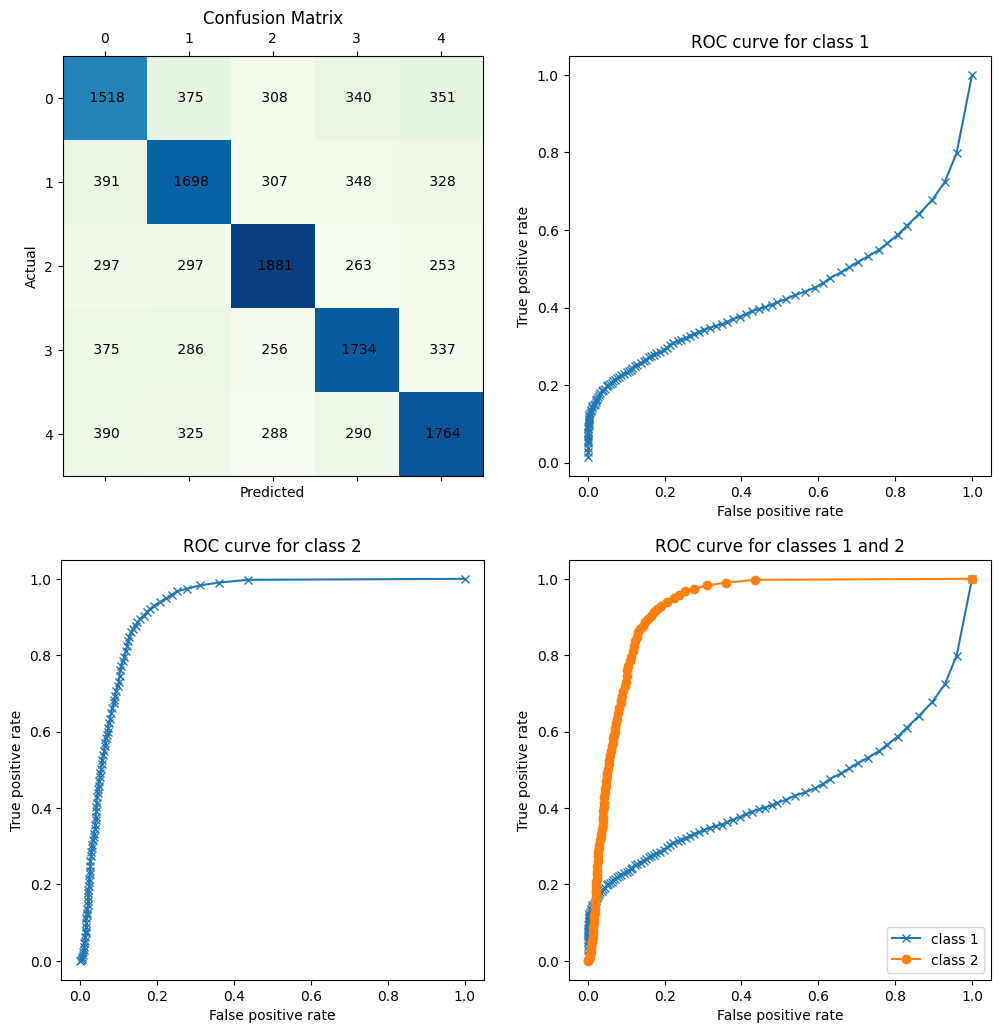

In [232]:
data = p3["train"]
X = data[:, :-1]  # Features
y = data[:, -1]   # Labels

# One-hot encode target variable
num_classes = 5
num_samples = y.shape[0]
y_encoded = np.zeros((num_samples, num_classes))
for i in range(num_samples):
    y_encoded[i, int(y[i]) - 1] = 1

# Add a column of 1s to X for bias term
X = np.hstack((X, np.ones((num_samples, 1))))

# Initialize weights
num_features = X.shape[1]
W = np.random.randn(num_features, num_classes)

# Set hyperparameters
learning_rate = 0.01
num_iterations = 1000
epsilon = 1e-8

# Train model using gradient descent
prev_loss = float('inf')
for i in range(num_iterations):
    # Forward propagation
    z = np.dot(X, W)
    y_pred = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    # Compute loss
    loss = -np.sum(y_encoded * np.log(y_pred + epsilon)) / num_samples

    # Backward propagation
    dz = y_pred - y_encoded
    dW = np.dot(X.T, dz) / num_samples

    # Update weights
    W -= learning_rate * dW

    # Check stopping criterion
    if prev_loss - loss < epsilon:
        print('Stopping criterion met')
        break

    prev_loss = loss

# Evaluate model on test set
X_test = test_data[:, :-1]
y_test_orig = test_data[:, -1]
num_test_samples = y_test_orig.shape[0]

# One-hot encode target variable
y_test = np.zeros((num_test_samples, num_classes))
for i in range(num_test_samples):
    y_test[i, int(y_test_orig[i]) - 1] = 1

# Add a column of 1s to X_test for bias term
X_test = np.hstack((X_test, np.ones((num_test_samples, 1))))

# Compute predictions on test set
z_test = np.dot(X_test, W)
y_test_pred = np.argmax(z_test, axis=1) + 1

# Compute test accuracy
test_accuracy = np.sum(y_test_pred == y_test_orig) / num_test_samples
print('Test accuracy:', test_accuracy)

conf_matrix = np.zeros((num_classes, num_classes))
for i in range(num_test_samples):
    true_class = int(y_test_orig[i]) - 1
    pred_class = int(y_test_pred[i]) - 1
    conf_matrix[true_class, pred_class] += 1
print('Confusion matrix:')
print(conf_matrix)

# Compute class-wise F1 score
f1_scores = []
for c in range(num_classes):
    tp = conf_matrix[c,c]
    fp = np.sum(conf_matrix[:,c]) - tp
    fn = np.sum(conf_matrix[c,:]) - tp
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    f1_scores.append(f1)
print('Class-wise F1 score:', f1_scores)

# Compute predictions on test set
z_test = np.dot(X_test, W)
y_test_prob = np.exp(z_test) / np.sum(np.exp(z_test), axis=1, keepdims=True)
y_test_pred = np.argmax(z_test, axis=1) + 1

# # Choose two classes for ROC curve
# class1 = 1
# class2 = 2

# # Compute false positive rate and true positive rate for different thresholds
# fpr = []
# tpr = []
# num_thresholds = 100
# for i in range(num_thresholds):
#     threshold = i / num_thresholds
#     tp = 0
#     fp = 0
#     tn = 0
#     fn = 0
#     for j in range(num_test_samples):
#         if y_test_orig[j] == class1:
#             if y_test_prob[j][class1-1] >= threshold:
#                 tp += 1
#             else:
#                 fn += 1
#         elif y_test_orig[j] == class2:
#             if y_test_prob[j][class1-1] >= threshold:
#                 fp += 1
#             else:
#                 tn += 1
#     fpr.append(fp / (fp + tn))
#     tpr.append(tp / (tp + fn))

# # Plot RoC curve and confusion matrix
# fig, ax = plt.subplots(2, 1, figsize=(8, 16))
# ax[0].matshow(confusion_matrix, cmap='GnBu')
# ax[0].set_xlabel("Predicted")
# ax[0].set_ylabel("Actual")
# ax[0].set_title("Confusion Matrix")
# for (x, y), value in np.ndenumerate(confusion_matrix):
#     ax[0].text(x, y, f"{value: .0f}", va="center", ha="center")

# ax[1].plot(fpr, tpr, marker='x')
# ax[1].set_xlabel("False positive rate")
# ax[1].set_ylabel("True positive rate")                     
# ax[1].set_title("ROC curve for classes {} and {}".format(class_1, class_2))

# fig.tight_layout()
# Choose two classes for ROC curve
class1 = 1
class2 = 2

# Choose two classes for ROC curve
class1 = 1
class2 = 2

# Compute false positive rate and true positive rate for different thresholds
fpr_class1 = []
tpr_class1 = []
fpr_class2 = []
tpr_class2 = []
num_thresholds = 100
for i in range(num_thresholds):
    threshold = i / num_thresholds
    tp_class1 = 0
    fp_class1 = 0
    tn_class1 = 0
    fn_class1 = 0
    tp_class2 = 0
    fp_class2 = 0
    tn_class2 = 0
    fn_class2 = 0
    for j in range(num_test_samples):
        if y_test_orig[j] == class1:
            if y_test_prob[j][class1-1] >= threshold:
                tp_class1 += 1
            else:
                fn_class1 += 1
        elif y_test_orig[j] == class2:
            if y_test_prob[j][class1-1] >= threshold:
                fp_class2 += 1
            else:
                tn_class2 += 1
        if y_test_orig[j] == class2:
            if y_test_prob[j][class2-1] >= threshold:
                tp_class2 += 1
            else:
                fn_class2 += 1
        elif y_test_orig[j] == class1:
            if y_test_prob[j][class2-1] >= threshold:
                fp_class1 += 1
            else:
                tn_class1 += 1
    fpr_class1.append(fp_class1 / (fp_class1 + tn_class1))
    tpr_class1.append(tp_class1 / (tp_class1 + fn_class1))
    fpr_class2.append(fp_class2 / (fp_class2 + tn_class2))
    tpr_class2.append(tp_class2 / (tp_class2 + fn_class2))

# Plot RoC curves and confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].matshow(confusion_matrix, cmap='GnBu')
ax[0, 0].set_xlabel("Predicted")
ax[0, 0].set_ylabel("Actual")
ax[0, 0].set_title("Confusion Matrix")
for (x, y), value in np.ndenumerate(confusion_matrix):
    ax[0, 0].text(x, y, f"{value: .0f}", va="center", ha="center")

ax[0, 1].plot(fpr_class1, tpr_class1, marker='x')
ax[0, 1].set_xlabel("False positive rate")
ax[0, 1].set_ylabel("True positive rate")                     
ax[0, 1].set_title("ROC curve for class {}".format(class1))

ax[1, 0].plot(fpr_class2, tpr_class2, marker='x')
ax[1, 0].set_xlabel("False positive rate")
ax[1, 0].set_ylabel("True positive rate")                     
ax[1, 0].set_title("ROC curve for class {}".format(class2))

ax[1, 1].plot(fpr_class1, tpr_class1, marker='x', label=f"class {class1}")
ax[1, 1].plot(fpr_class2, tpr_class2, marker='o', label=f"class {class2}")
ax[1, 1].set_xlabel("False positive rate")
ax[1, 1].set_ylabel("True positive rate")
ax[1, 1].set_title("ROC curve for classes {} and {}".format(class1, class2))
ax[1, 1].legend()
plt.show()

# P5 (Neural Networks, CNN)

- Construct a CNN for the K-MNIST dataset and code the back-propagation algorithm with weight sharing and local-receptive fields. 
- Experiment with 3 different architectures and report the accuracy.

**DATA:** `images.zip`, (`p4[data]`)

# P6 (Neural Networks, CNN)

- For the above problem, build a big-enough CNN architecture that would overfit the K-MNIST data. 
- Impose L2 and early-stopping as regularizers and plot the bias-variance curves. 
- Perturb each of the input images with additive Gaussian noise and report its regularization impact.

**DATA:** `images.zip`, (`p4[data]`)

## Data handling

In [334]:
p4["splitData"] = [trainTestSplit(p4["data"], r, imgToFeatures) for r in [0.2, 0.3, 0.5, 0.7, 0.9]]

## Naive Bayes

In [249]:
p4["result"] = [[] for _ in range(5)]

### Test split -- 20:80

[[ 516   15    9    0  649    3    1    0    7    0]
 [ 305  433    2    0  451    5    1    0    0    3]
 [   8    5 1181    0    0    1    0    0    4    1]
 [ 111    7   14   53  642    3  357   12    0    1]
 [   3    0    0    0 1185    4    2    1    4    1]
 [ 260   19   55    1  464  362   11    0    7   21]
 [   6    3    4    1   73    1 1102    9    1    0]
 [ 127    3    0   11  188    5  692  174    0    0]
 [ 125    1   18    0  214   10    1    0  681  150]
 [   7    1    6    0  446    3    3    0   10  724]]
[[2210   50   35    0 2448   21    2    1   31    2]
 [1181 1683    6    0 1882   26   16    3    0    3]
 [  39   15 4709    0   10    8    1    0   16    2]
 [ 399   22   36  228 2517   12 1536   49    1    0]
 [  35    4    1    0 4723   20    6    0    7    4]
 [1194   92  173    5 1799 1393   58    1   12   73]
 [  43    8   12   10  269    3 4382   60    8    5]
 [ 491   22    2   42  732   12 2760  730    2    7]
 [ 577    1   51    0  762   30    8    0 279

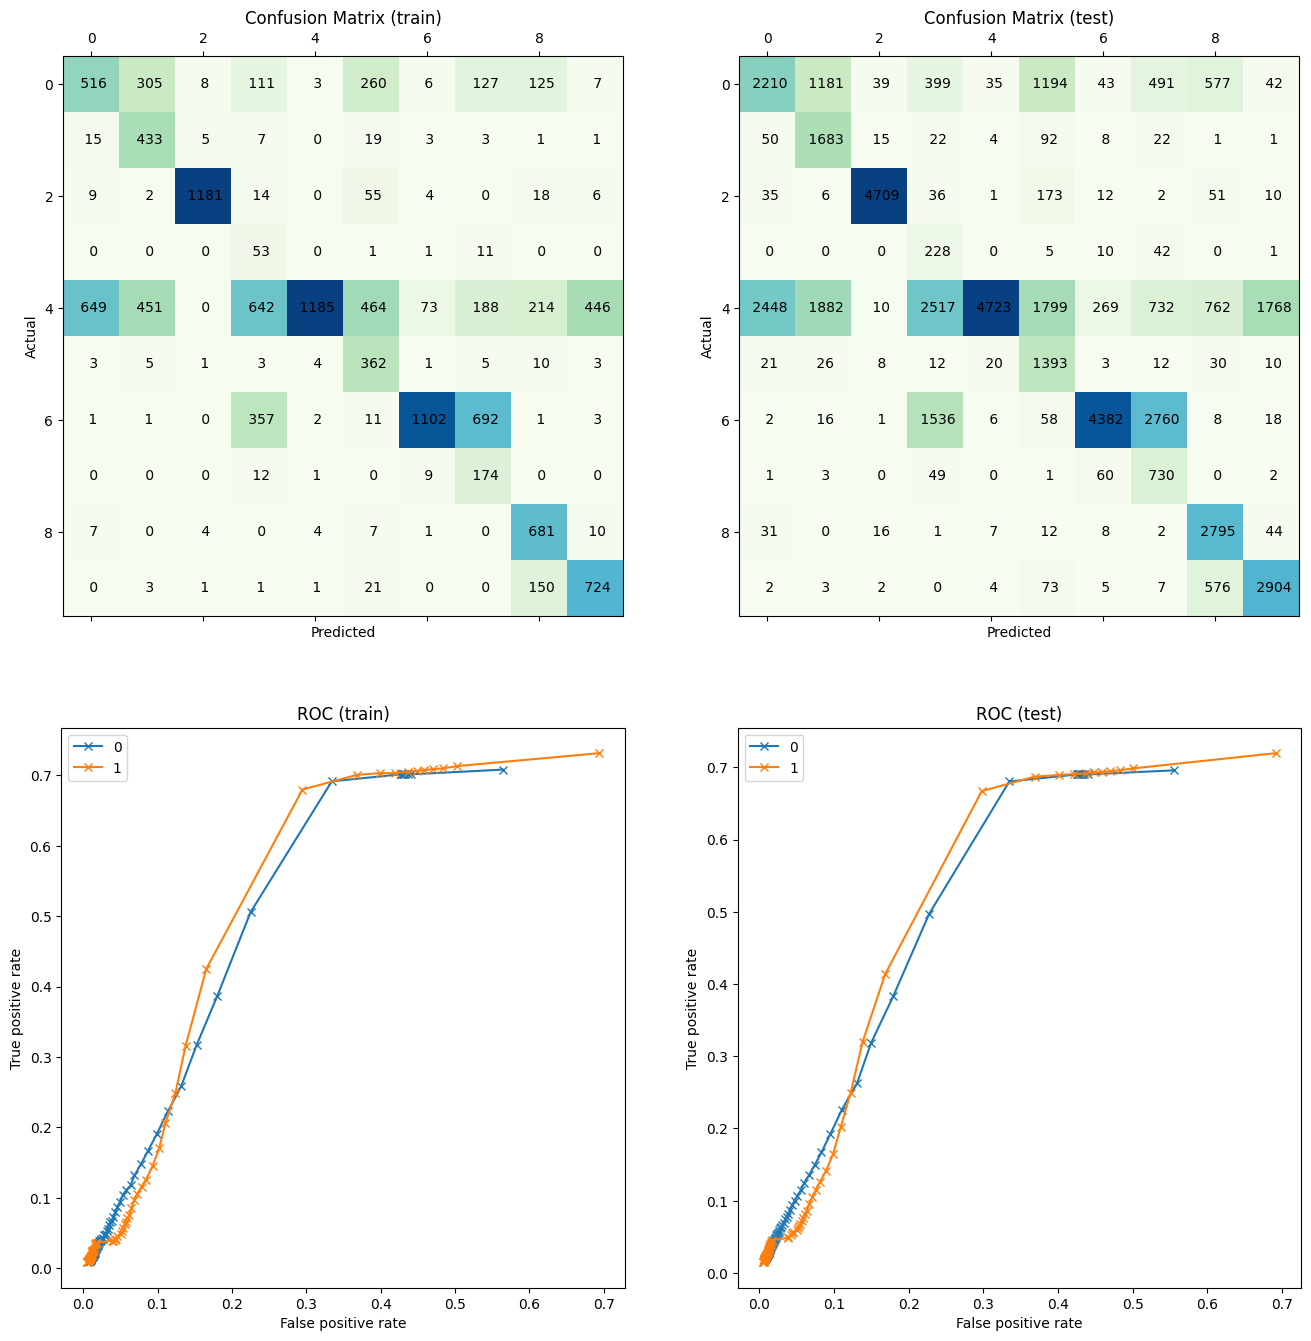

In [250]:
p4["result"][0] = metrics.print(*p4["splitData"][0], naiveLogNormal)

### Test split -- 30:70

[[ 650   51   20    0 1057    8    2    0   12    0]
 [  35 1047    3    0  684    8   20    1    1    1]
 [   6    9 1779    0    1    1    0    0    4    0]
 [  29    7   21  170  966    5  597    5    0    0]
 [   3    1    0    0 1777    8    3    1    6    1]
 [  94  141  140    4  692  687   29    0    9    4]
 [   1    5    4    4   96    1 1680    7    2    0]
 [  46    8    4   88  291    8 1238  117    0    0]
 [ 126    3   46    0  321   19    2    0 1201   82]
 [  13    1   19    0  714    1    6    0   41 1005]]
[[1627  107   54    0 2339   23   10    1   39    0]
 [  52 2408    8    1 1659   28   41    2    0    1]
 [  14   20 4135    0   10    5    1    0   15    0]
 [  75   25   56  365 2211   14 1440   14    0    0]
 [   9    8    4    1 4141   21    6    0   10    0]
 [ 266  346  305    4 1595 1600   65    0   14    5]
 [   8    7   12   21  222    3 3894   25    7    1]
 [ 140   25    2  222  658   19 2799  333    2    0]
 [ 300    5  101    0  723   25   12    0 286

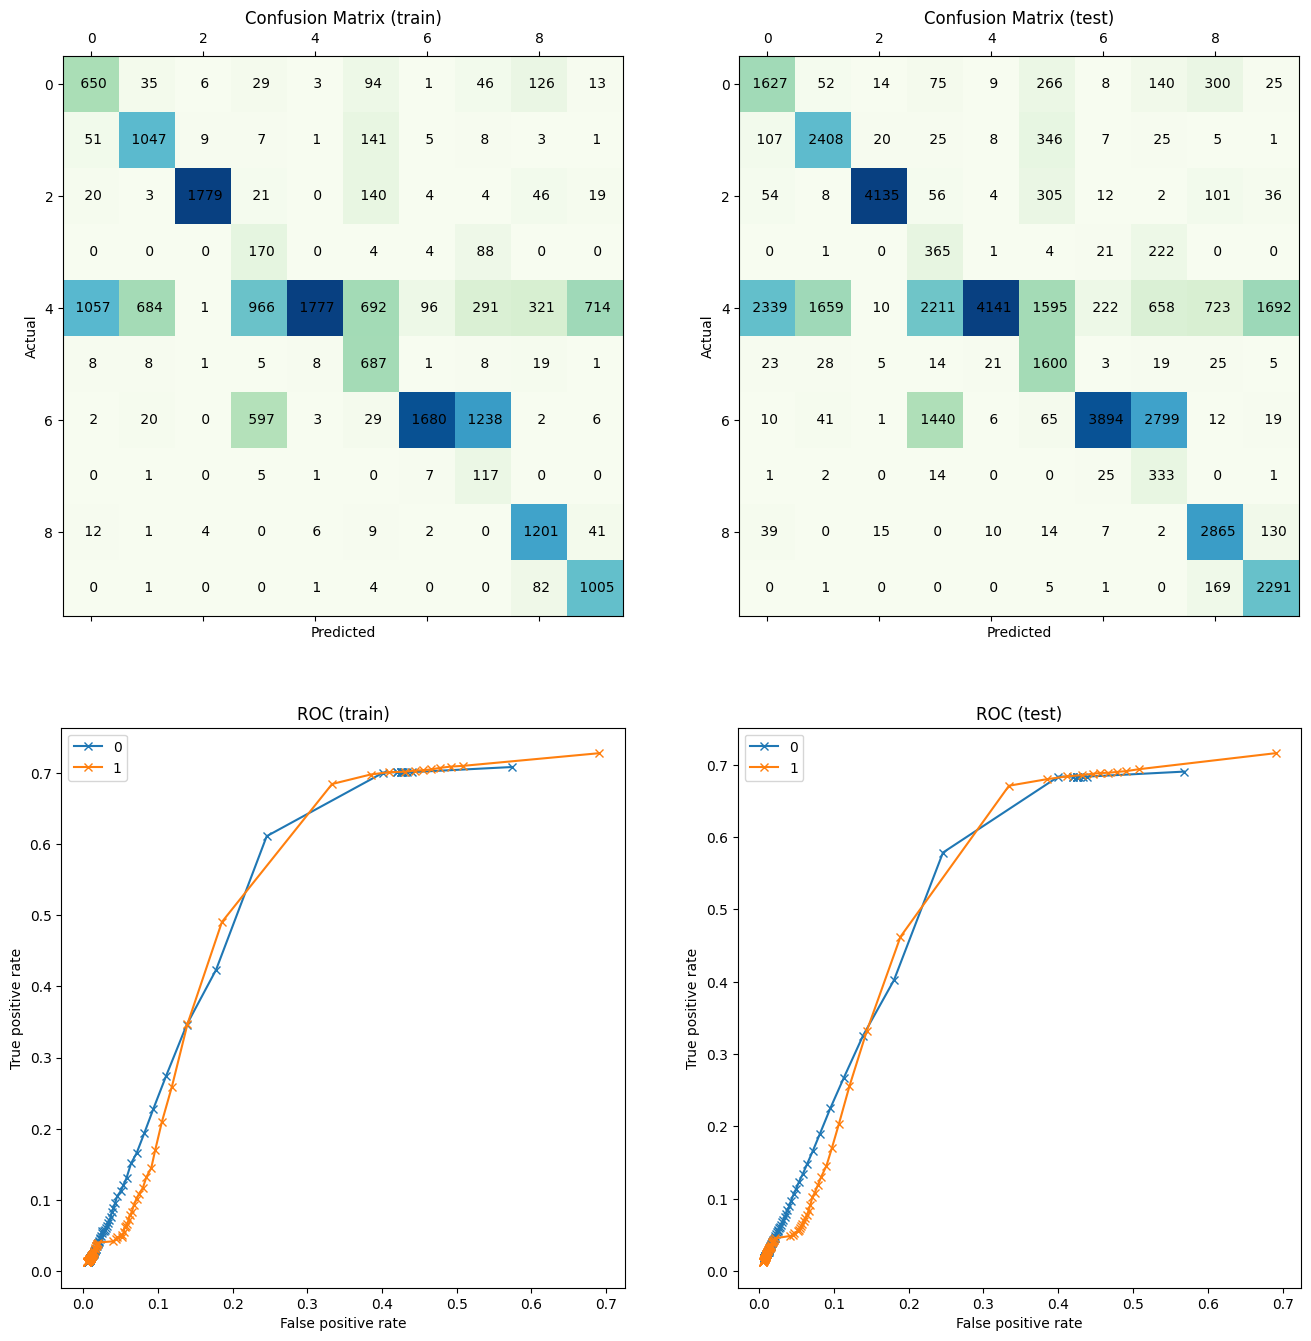

In [251]:
p4["result"][0] = metrics.print(*p4["splitData"][1], naiveLogNormal)

### Test split -- 50:50

[[1349  100   19    2 1490   13    1    0   25    1]
 [  51 1881    3    2 1043   15    0    2    1    2]
 [  24   68 2896    0    2    0    0    0   10    0]
 [  88   26   13  933 1423    6  491   17    2    1]
 [  12    7    0    2 2947   11    4    1   14    2]
 [ 446  342   92   19 1119  810   28    0  106   38]
 [   9   11    6   34  152    2 2759   23    4    0]
 [ 153   20    1  392  406    7 1686  330    5    0]
 [ 238    4   29    0  493   18    3    0 2031  184]
 [  15    4   12    3 1097    1    8    0   70 1790]]
[[1429   81   22    0 1421    4    3    1   39    0]
 [  50 1826    1    1 1104   13    2    1    1    1]
 [  11   85 2878    1    7    3    0    0   15    0]
 [  83   38   10  882 1466    7  496   17    0    1]
 [  14   10    0    2 2943   11    4    0   14    2]
 [ 492  356   92   10 1080  789   34    0  110   37]
 [   9    6    9   28  130    0 2787   23    6    2]
 [ 160   23    0  379  386    5 1686  355    6    0]
 [ 221    6   15    0  473   18   11    0 209

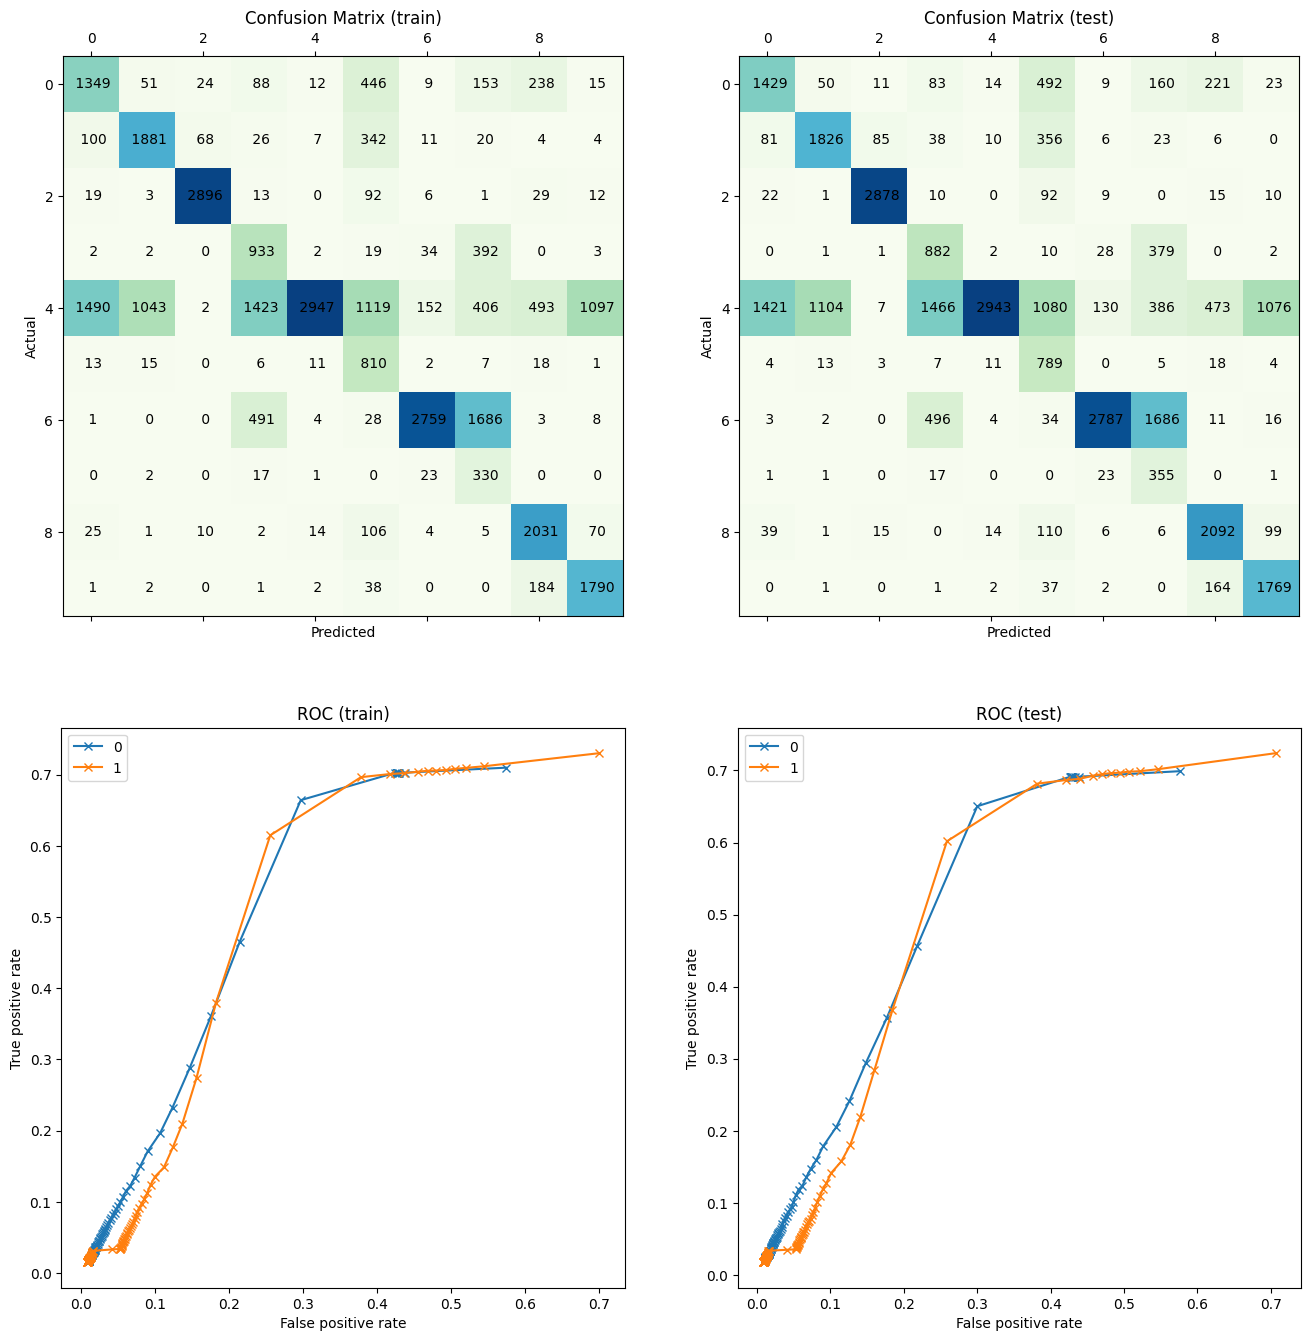

In [252]:
p4["result"][0] = metrics.print(*p4["splitData"][2], naiveLogNormal)

### Test split -- 70:30

[[2025  124   22    3 1970   14    1    0   41    0]
 [  93 2603    4    5 1468   21    0    3    1    2]
 [  29   94 4063    0    3    2    0    0    9    0]
 [ 121   30   15 1659 1964    8  377   23    2    1]
 [  15    9    0    5 4126   19    5    1   19    1]
 [ 685  442  132   28 1552 1128   34    1  154   44]
 [  17    9    9   91  199    1 3834   30    8    2]
 [ 198   32    1  775  551   11 2127  498    7    0]
 [ 354    8   38    0  662   23    9    0 2883  223]
 [  35    4   16    6 1478    2   12    0  131 2516]]
[[ 898   43    8    1  822    3    2    1   22    0]
 [  31 1076    1    1  680    7    2    0    1    1]
 [   6   49 1731    1    6    2    0    0    5    0]
 [  48   18    6  666  854    4  191   13    0    0]
 [  11    6    0    0 1765    4    2    0   10    2]
 [ 312  182   56   13  641  494   15    1   69   17]
 [   9    5    5   27   85    0 1654   13    2    0]
 [  90   10    0  349  220    1  907  219    4    0]
 [ 152    1    6    0  275   17    5    0 126

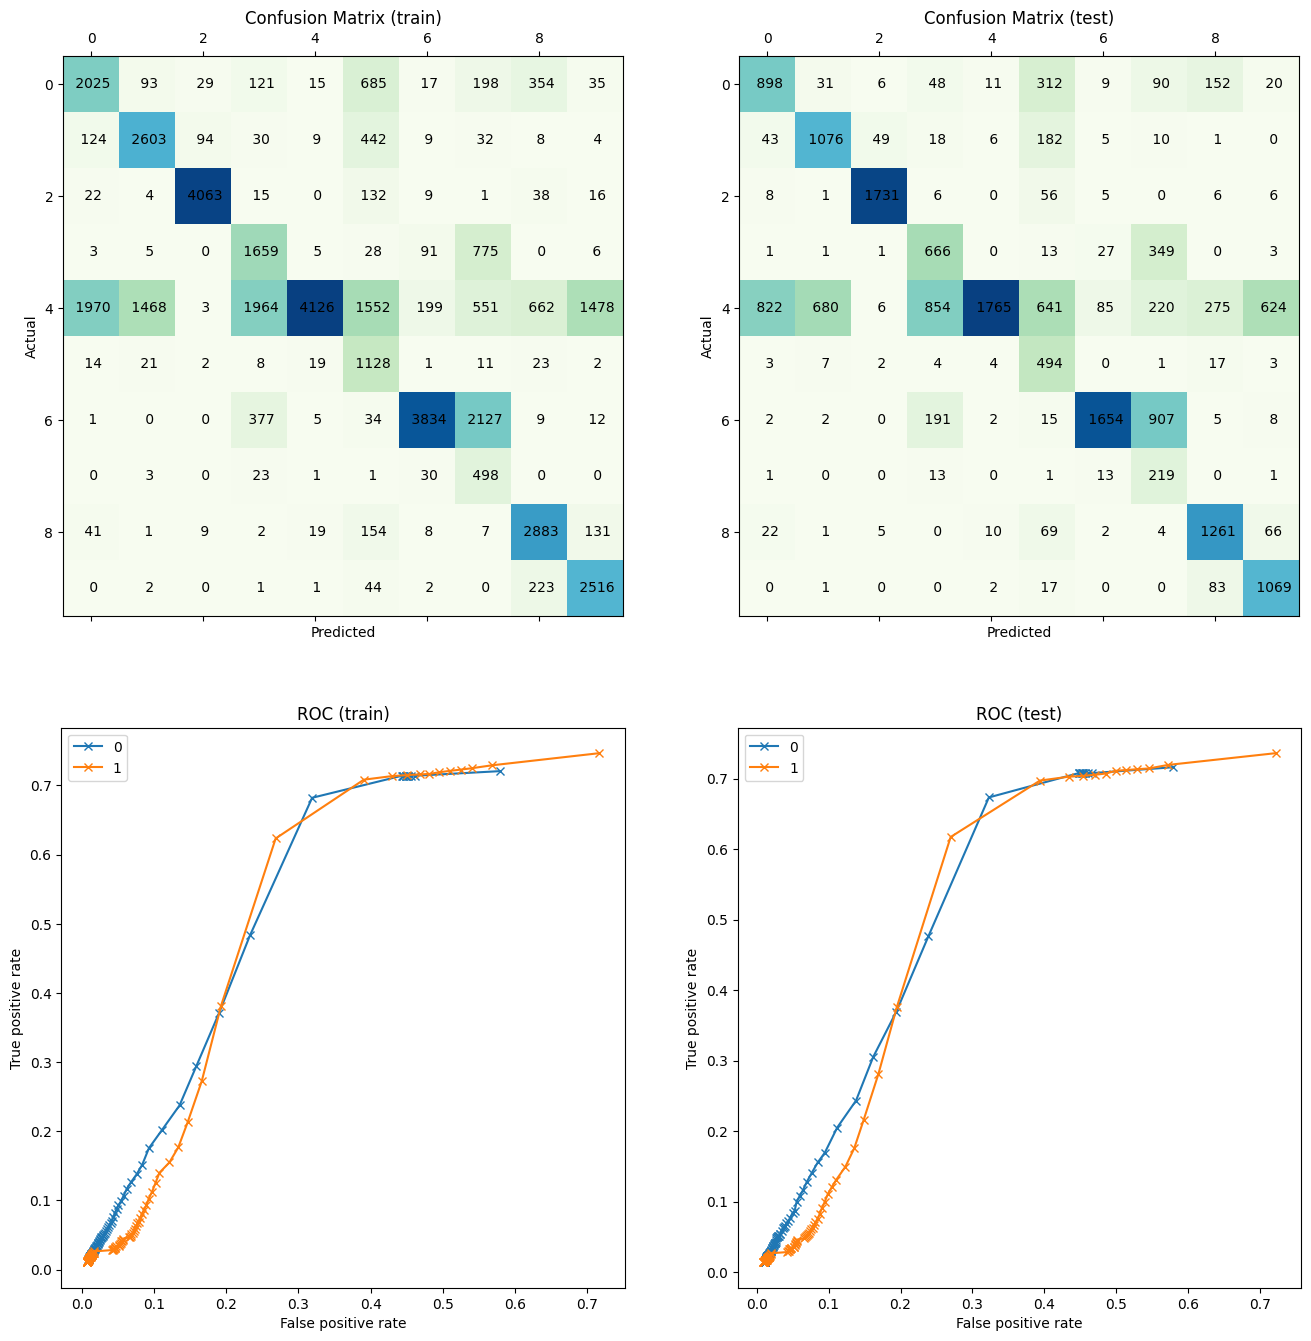

In [253]:
p4["result"][0] = metrics.print(*p4["splitData"][3], naiveLogNormal)

### Test split -- 90:10

[[2652  149   30    4 2493   18    2    1   51    0]
 [ 123 3318    5    7 1912   28    1    3    1    2]
 [  36  117 5222    1    7    4    0    0   13    0]
 [ 153   39   22 2129 2533   11  470   40    2    1]
 [  22   13    0    5 5302   22    6    1   26    3]
 [ 883  550  176   43 1981 1481   38    1  194   53]
 [  25   11   11  113  257    2 4928   43    9    1]
 [ 270   32    1 1051  684   14 2645  696    7    0]
 [ 488    9   45    0  835   31    9    0 3740  243]
 [  59    3   21   11 1909    5   18    1  191 3182]]
[[303  11   2   0 273   0   1   0  10   0]
 [ 11 369   0   0 218   0   1   0   1   0]
 [  1  11 586   0   2   0   0   0   0   0]
 [ 20   7   0 232 283   2  55   1   0   0]
 [  5   3   0   0 586   2   1   0   3   0]
 [132  57  16   5 198 158   8   1  23   2]
 [  3   3   3  11  23   0 550   6   1   0]
 [ 36   6   0 119  79   0 287  71   2   0]
 [ 42   0   2   0  94   7   2   0 424  29]
 [  7   0   1   0 213   0   1   0  20 358]]
------------------ Train -------------

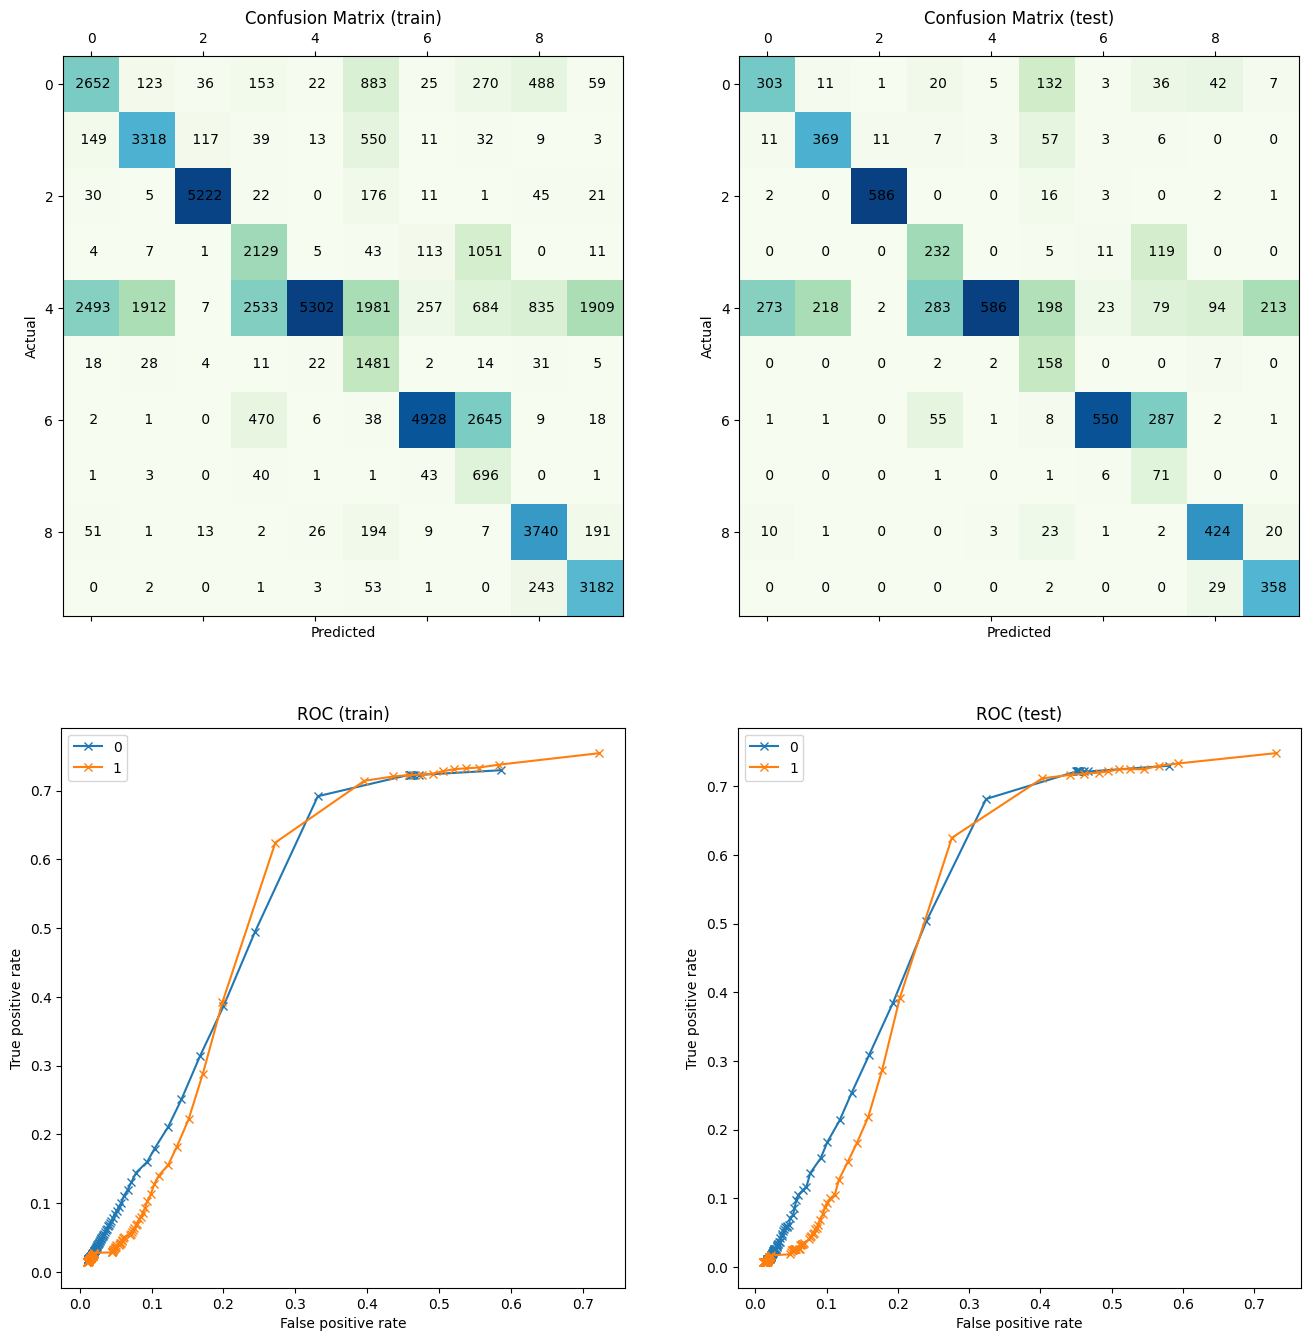

In [254]:
p4["result"][0] = metrics.print(*p4["splitData"][4], naiveLogNormal)

## GMM

In [335]:
def printGmm(data, number_of_guassians=2):
    classStatsGMM = {}
    for label in data[-1]:
        classStatsGMM[label] = { "prior": data[-1][label]["prior"] }
        classStatsGMM[label]["weights"], classStatsGMM[label]["mean"], classStatsGMM[label]["cov"] = em(data[-1][label]["data"], number_of_guassians, 50)

    metrics.print(*data[:-1], classStatsGMM, logGMM, result=False)

### Test split -- 20:80

------------------ Train ---------------------
Classification Accuracy :  0.9033333333333333
F1 Score                :  [0.82515448 0.9448751  0.97534475 0.88790035 0.88107357 0.874613
 0.90781387 0.87910328 0.93322341 0.93800769]
------------------ Test ----------------------
Classification Accuracy :  0.87625
F1 Score                :  [0.7808723  0.92861047 0.9567222  0.84870431 0.84984556 0.85929456
 0.88591203 0.84138883 0.91336149 0.9182363 ]


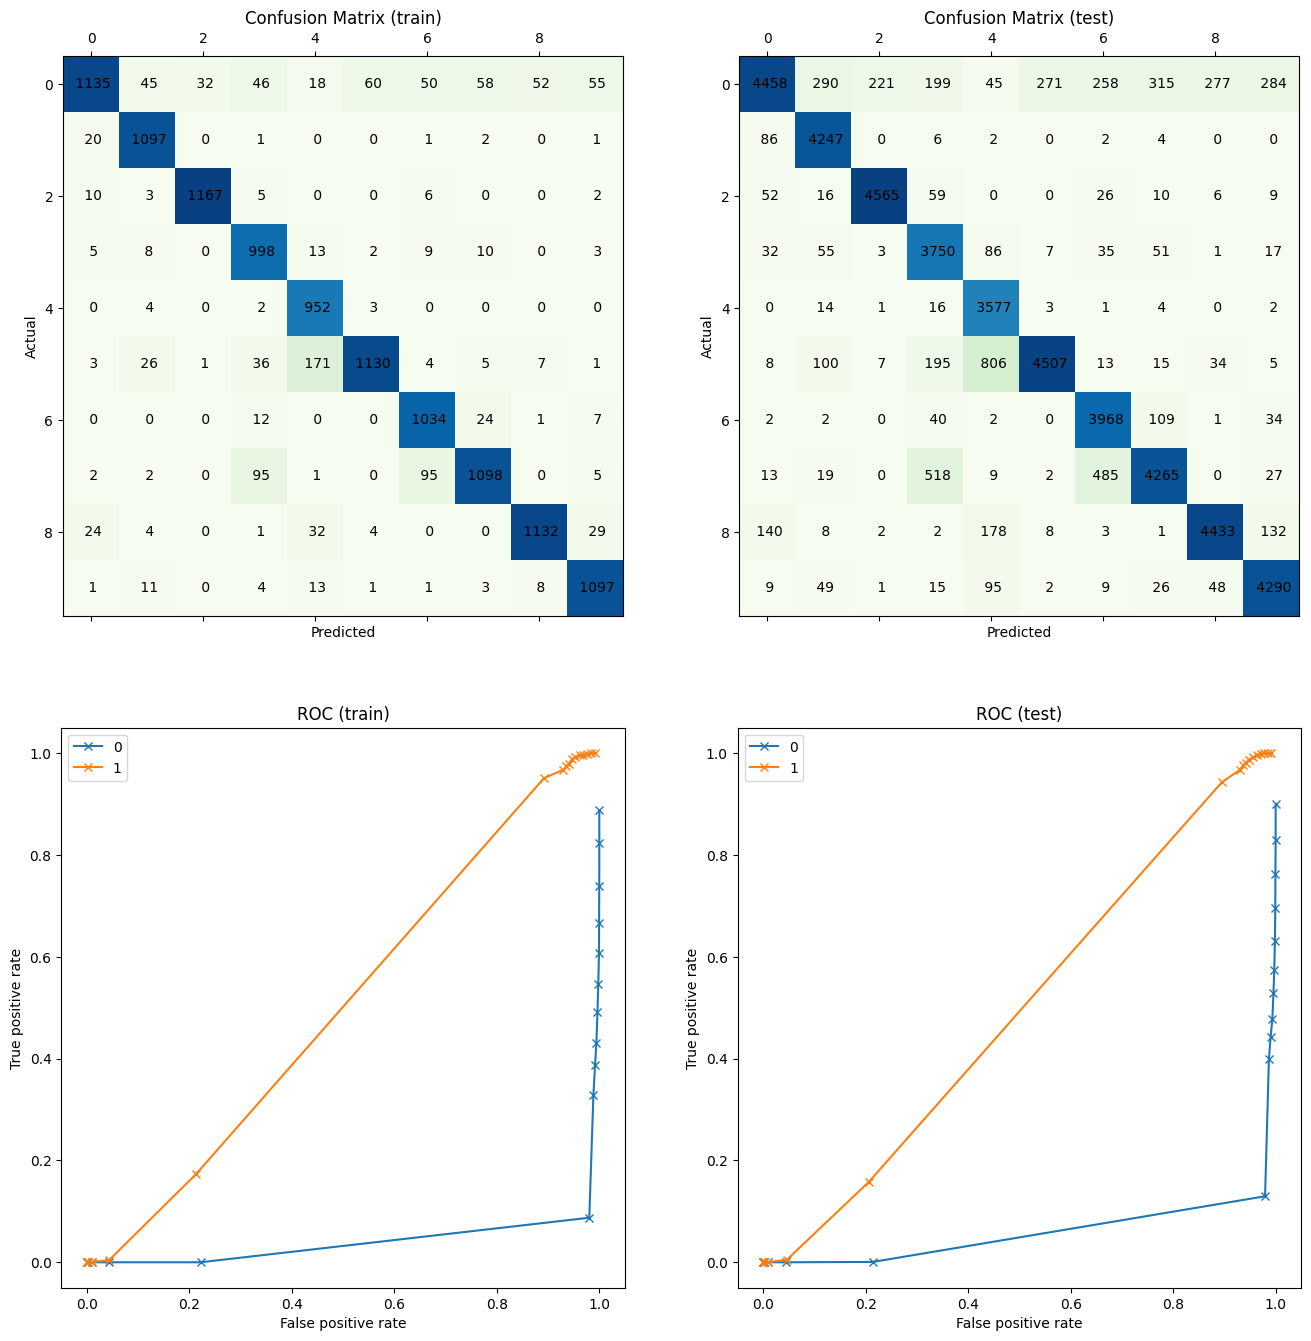

In [336]:
printGmm(p4["splitData"][0])

### Test split -- 30:70

In [ ]:
printGmm(p4["splitData"][1])

### Test split -- 50:50

------------------ Train ---------------------
Classification Accuracy :  0.8954666666666666
F1 Score                :  [0.81072555 0.93342628 0.96993112 0.87511166 0.86634036 0.87887236
 0.91858037 0.87030225 0.92441956 0.92164179]
------------------ Test ----------------------
Classification Accuracy :  0.8837333333333334
F1 Score                :  [0.79148332 0.92537838 0.96065904 0.86471861 0.8498854  0.86638063
 0.90969432 0.85486188 0.91492829 0.9163698 ]


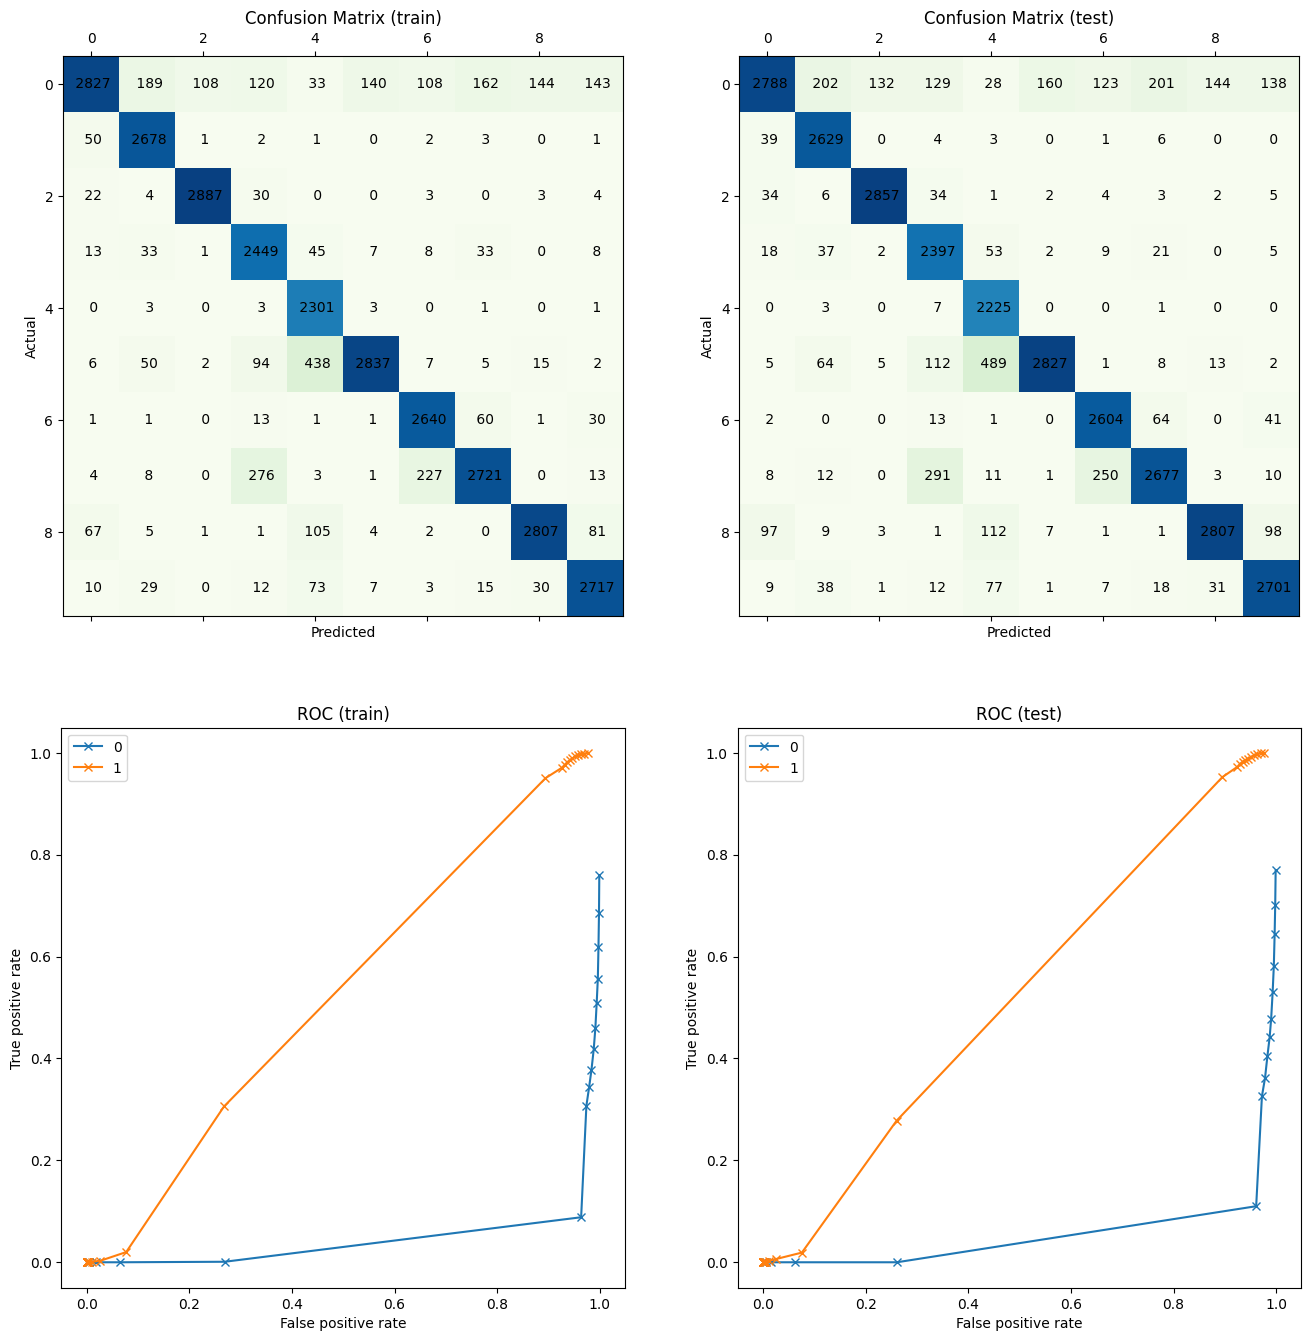

In [342]:
printGmm(p4["splitData"][2])

### Test split -- 70:30

In [ ]:
printGmm(p4["splitData"][3])

### Test split -- 90:10

In [ ]:
printGmm(p4["splitData"][4])

## Logistic Regression

In [223]:
def logisticRegressor(data):
    X_train,y_train_orig , X_test, y_test_orig, classStats = data
    num_classes = 10
    num_samples = y_train_orig.shape[0]
    y_train = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        y_train[i, int(y_train_orig[i]) - 1] = 1

    # Define sigmoid function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Define softmax function
    def softmax(x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Initialize weights and biases
    num_features = X_train.shape[1]
    W = np.random.randn(num_features, num_classes)
    b = np.random.randn(num_classes)

    # Set hyperparameters
    learning_rate = 0.1
    num_iterations = 1000
    epsilon = 1e-8

    # Train model using gradient descent
    prev_loss = float('inf')
    for i in range(num_iterations):
        # Forward propagation
        z = np.dot(X_train, W) + b
        y_pred = softmax(z)

        # Compute loss
        loss = -np.sum(y_train * np.log(y_pred + epsilon)) / num_samples

        # Backward propagation
        dz = y_pred - y_train
        dW = np.dot(X_train.T, dz) / num_samples
        db = np.sum(dz, axis=0) / num_samples

        # Update weights and biases
        W -= learning_rate * dW
        b -= learning_rate * db

        # Check stopping criterion
        if prev_loss - loss < epsilon:
            print('Stopping criterion met')
            break

        prev_loss = loss

    # Evaluate model on test set
    z = np.dot(X_test, W) + b
    y_pred = np.argmax(softmax(z), axis=1) + 1
    accuracy = np.sum(y_pred == y_test_orig) / y_test_orig.shape[0]
    print('Test accuracy:', accuracy)

    z_train = np.dot(X_train, W) + b
    y_train_pred = np.argmax(softmax(z_train), axis=1) + 1
    train_loss = -np.sum(y_train * np.log(softmax(z_train) + epsilon)) / num_samples
    train_error_rate = 1 - np.sum(y_train_pred == y_train_orig) / y_train_orig.shape[0]
    print('Training empirical risk:', train_loss)
    print('Training error rate:', train_error_rate)

    # Compute empirical risk on test data
    num_samples_test = y_test_orig.shape[0]
    y_test = np.zeros((num_samples_test, num_classes))
    for i in range(num_samples_test):
        y_test[i, int(y_test_orig[i]) - 1] = 1

    z_test = np.dot(X_test, W) + b
    test_loss = -np.sum(y_test * np.log(softmax(z_test) + epsilon)) / num_samples_test
    test_error_rate = 1 - np.sum(y_pred == y_test_orig) / y_test_orig.shape[0]
    print('Test empirical risk:', test_loss)
    print('Test error rate:', test_error_rate)

    num_classes = len(np.unique(y_test_orig))
    confusion_matrix = np.zeros((num_classes, num_classes))
    for i in range(len(y_test_orig)):
        true_class = int(y_test_orig[i] - 1)
        predicted_class = int(y_pred[i] - 1)
        confusion_matrix[true_class, predicted_class] += 1
    # print('Confusion matrix:')
    # print(confusion_matrix)


    num_classes = len(np.unique(y_test_orig))
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        f1_scores[i] = 2 * precision * recall / (precision + recall + 1e-8)
    print('Class-wise F1 score:')
    print(f1_scores)

    # Choose two classes
    class_1 = 1
    class_2 = 2
    # Get predicted probabilities for the two classes
    y_class_1 = y_pred == class_1
    y_class_2 = y_pred == class_2
    y_prob_1 = softmax(z)[:, class_1 - 1]
    y_prob_2 = softmax(z)[:, class_2 - 1]

    # Compute true positive rate and false positive rate for both classes
    num_thresholds = 100
    tpr_class_1 = np.zeros(num_thresholds)
    fpr_class_1 = np.zeros(num_thresholds)
    tpr_class_2 = np.zeros(num_thresholds)
    fpr_class_2 = np.zeros(num_thresholds)

    for i in range(num_thresholds):
        threshold = i / (num_thresholds - 1)
        tp_class_1 = np.sum((y_prob_1 >= threshold) & (y_class_1 == True))
        fn_class_1 = np.sum((y_prob_1 < threshold) & (y_class_1 == True))
        tn_class_1 = np.sum((y_prob_2 < threshold) & (y_class_2 == True))
        fp_class_1 = np.sum((y_prob_2 >= threshold) & (y_class_2 == False))
        tpr_class_1[i] = tp_class_1 / (tp_class_1 + fn_class_1 + 1e-8)
        fpr_class_1[i] = fp_class_1 / (fp_class_1 + tn_class_1 + 1e-8)

        tp_class_2 = np.sum((y_prob_2 >= threshold) & (y_class_2 == True))
        fn_class_2 = np.sum((y_prob_2 < threshold) & (y_class_2 == True))
        tn_class_2 = np.sum((y_prob_1 < threshold) & (y_class_1 == True))
        fp_class_2 = np.sum((y_prob_1 >= threshold) & (y_class_1 == False))
        tpr_class_2[i] = tp_class_2 / (tp_class_2 + fn_class_2 + 1e-8)
        fpr_class_2[i] = fp_class_2 / (fp_class_2 + tn_class_2 + 1e-8)

    # Plot RoC curves and confusion matrix
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    ax[0, 0].matshow(confusion_matrix, cmap='GnBu')
    ax[0, 0].set_xlabel("Predicted")
    ax[0, 0].set_ylabel("Actual")
    ax[0, 0].set_title("Confusion Matrix")
    for (x, y), value in np.ndenumerate(confusion_matrix):
        ax[0, 0].text(x, y, f"{value: .0f}", va="center", ha="center")

    ax[0, 1].plot(fpr_class_1, tpr_class_1, marker='x')
    ax[0, 1].set_xlabel("False positive rate")
    ax[0, 1].set_ylabel("True positive rate")                     
    ax[0, 1].set_title("ROC curve for class {}".format(class_1))

    ax[1, 0].plot(fpr_class_2, tpr_class_2, marker='x')
    ax[1, 0].set_xlabel("False positive rate")
    ax[1, 0].set_ylabel("True Positive rate")
    ax[1, 0].set_title("ROC curve for class {}".format(class_2))

    ax[1, 1].plot(fpr_class_1, tpr_class_1, marker='x', label="Class {}".format(class_1))
    ax[1, 1].plot(fpr_class_2, tpr_class_2, marker='o', label="Class {}".format(class_2))
    ax[1, 1].set_xlabel("False positive rate")
    ax[1, 1].set_ylabel("True positive rate")
    ax[1, 1].set_title("ROC curve for classes {} and {}".format(class_1, class_2))
    ax[1, 1].legend()

    fig.tight_layout()
    plt.show()

### Test split -- 20:80

Test accuracy: 0.5162708333333333
Training empirical risk: 1.6990536858850833
Training error rate: 0.4833333333333333
Test empirical risk: 1.7009886094951687
Test error rate: 0.48372916666666665
Class-wise F1 score:
[0.39603312 0.82344827 0.57270294 0.67140381 0.10044427 0.67645195
 0.46544142 0.67382401 0.5460443  0.51491779]


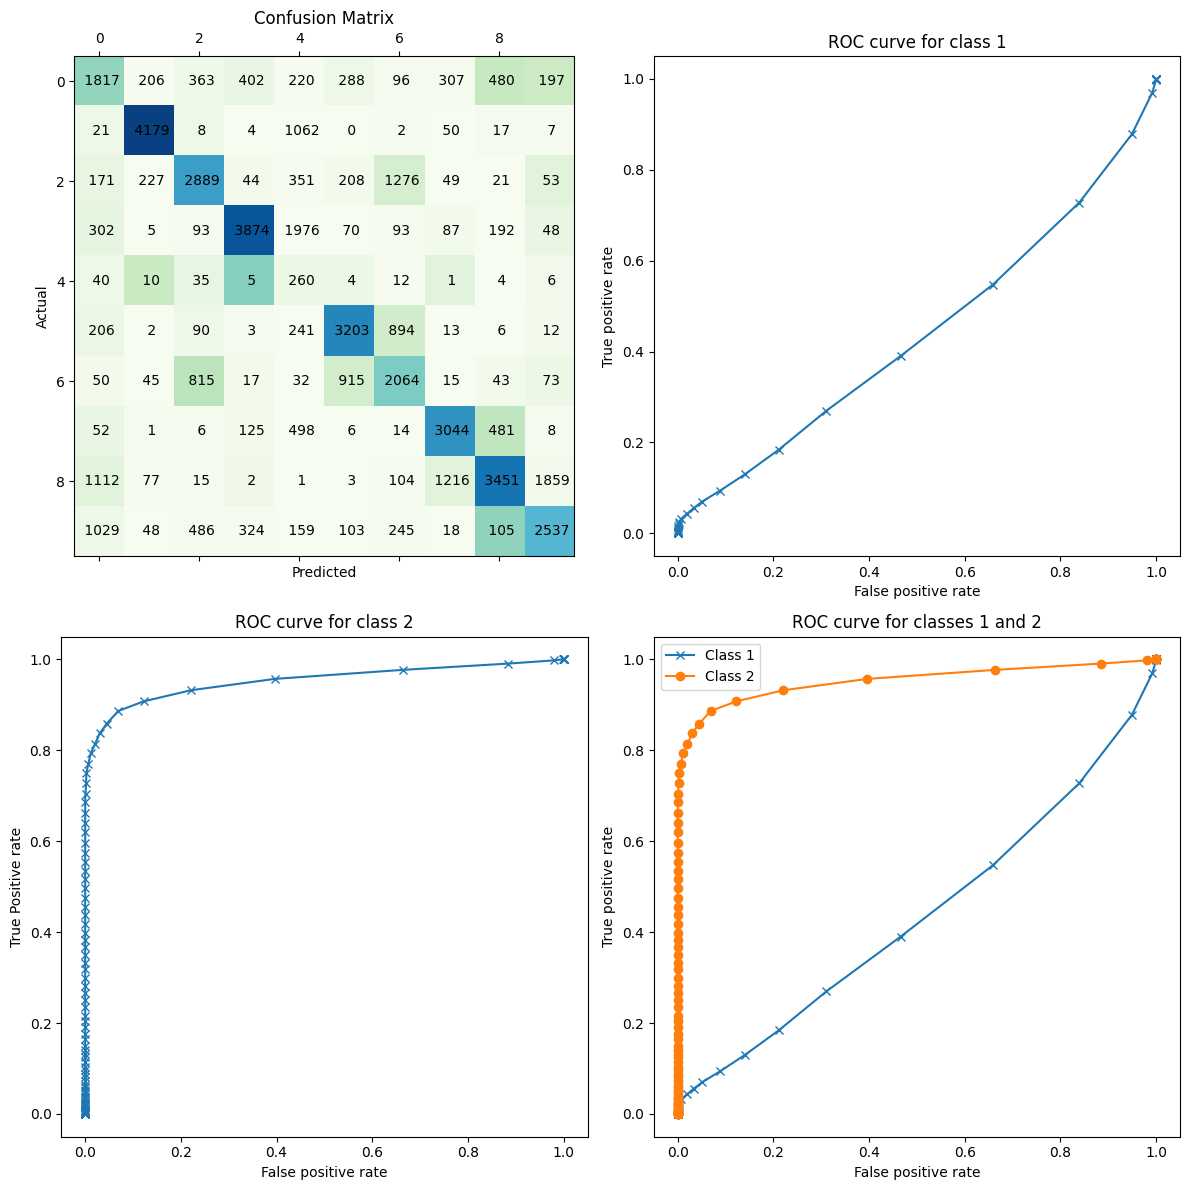

In [224]:
logisticRegressor(p4["splitData"][0])

### Test split -- 30:70

Test accuracy: 0.568
Training empirical risk: 1.6672747741266578
Training error rate: 0.4318333333333333
Test empirical risk: 1.6658444649741093
Test error rate: 0.43200000000000005
Class-wise F1 score:
[0.66725153 0.72972972 0.59304932 0.67824551 0.62238228 0.77617554
 0.12047288 0.7019761  0.64866959 0.71859723]


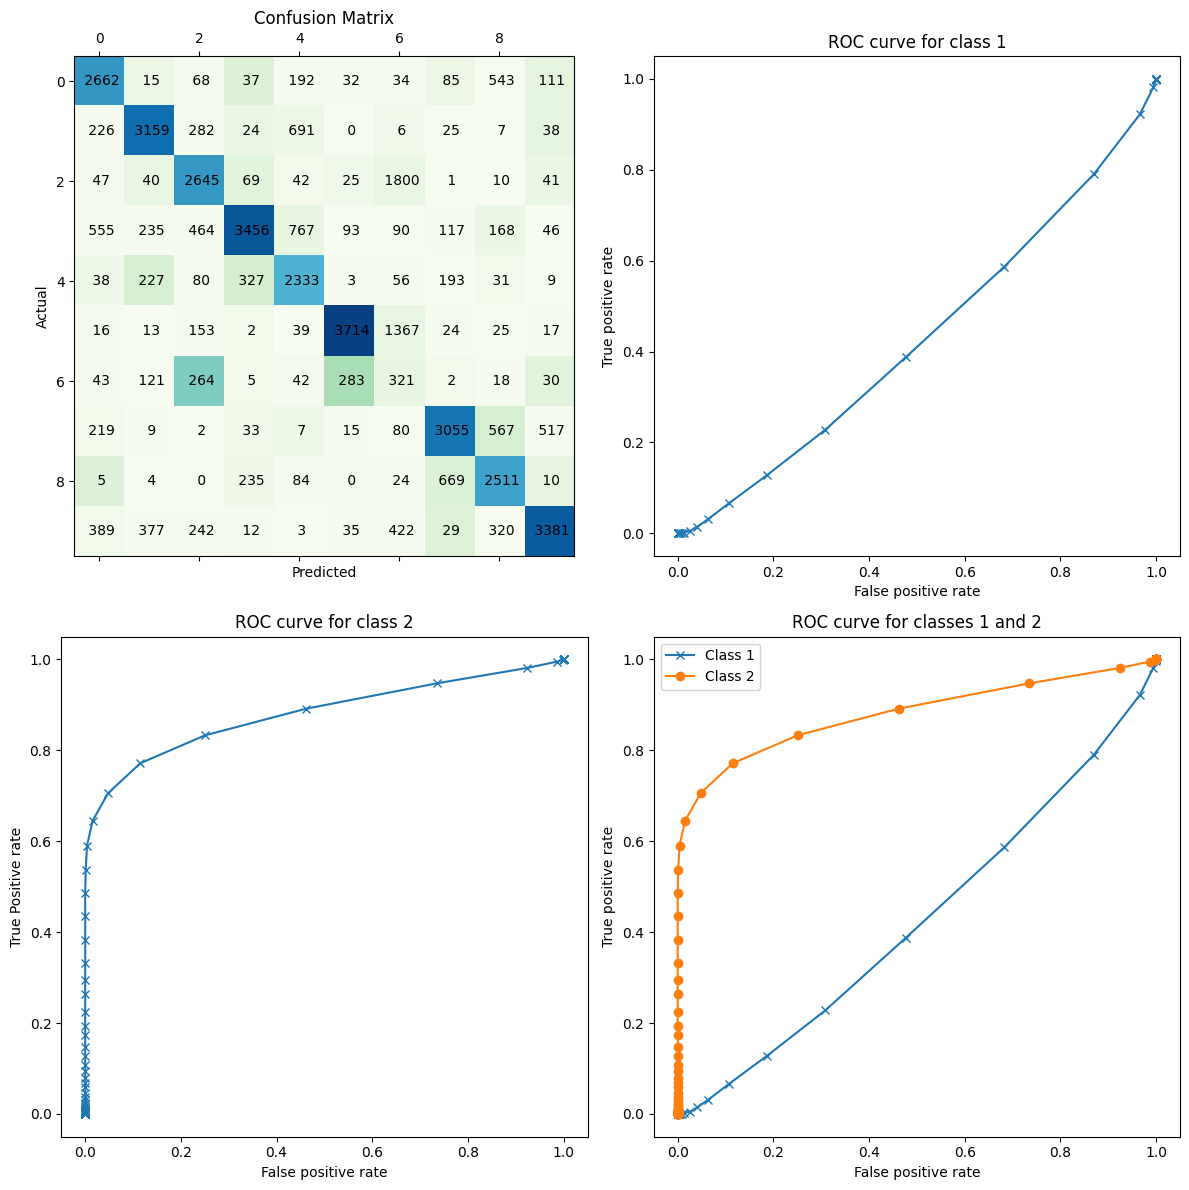

In [225]:
logisticRegressor(p4["splitData"][1])

### Test split -- 50:50

Test accuracy: 0.4898666666666667
Training empirical risk: 1.7061716028343432
Training error rate: 0.5090666666666667
Test empirical risk: 1.7043141781012336
Test error rate: 0.5101333333333333
Class-wise F1 score:
[0.63132626 0.73202054 0.08678    0.67714208 0.28668076 0.77964071
 0.49394387 0.56933207 0.46435709 0.71957225]


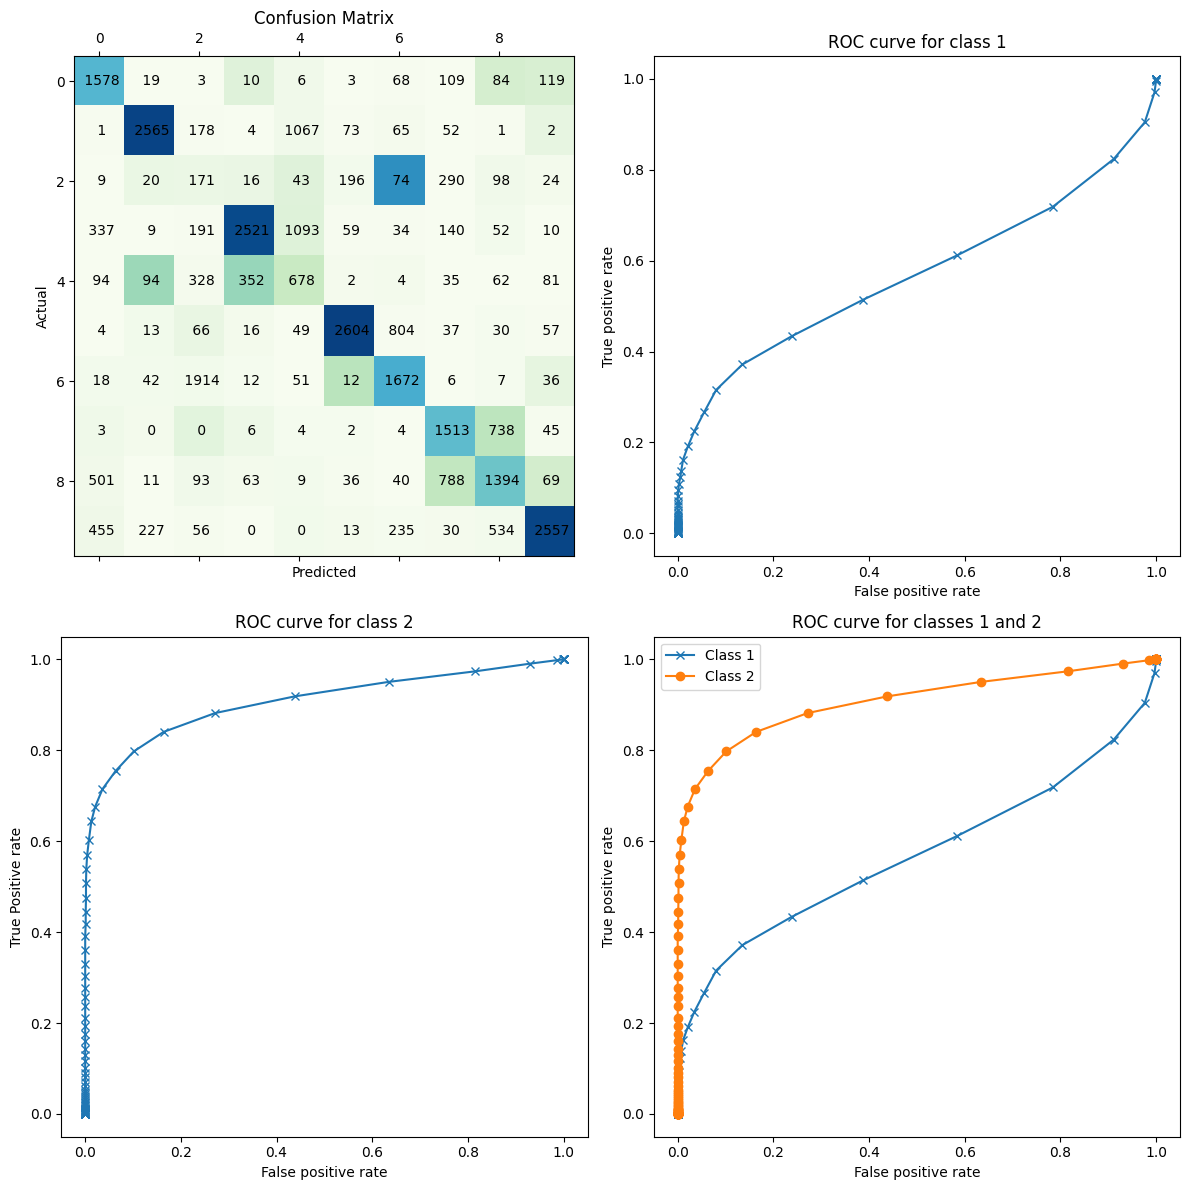

In [227]:
logisticRegressor(p4["splitData"][2])

### Test split -- 70:30

In [ ]:
logisticRegressor(p4["splitData"][3])

### Test split -- 90:10

Test accuracy: 0.5013333333333333
Training empirical risk: 1.7091649908073918
Training error rate: 0.48816666666666664
Test empirical risk: 1.707899155528917
Test error rate: 0.4986666666666667
Class-wise F1 score:
[0.2951945  0.77593032 0.55733148 0.52268907 0.64118564 0.65765004
 0.57525083 0.66194332 0.38397017 0.6005291 ]


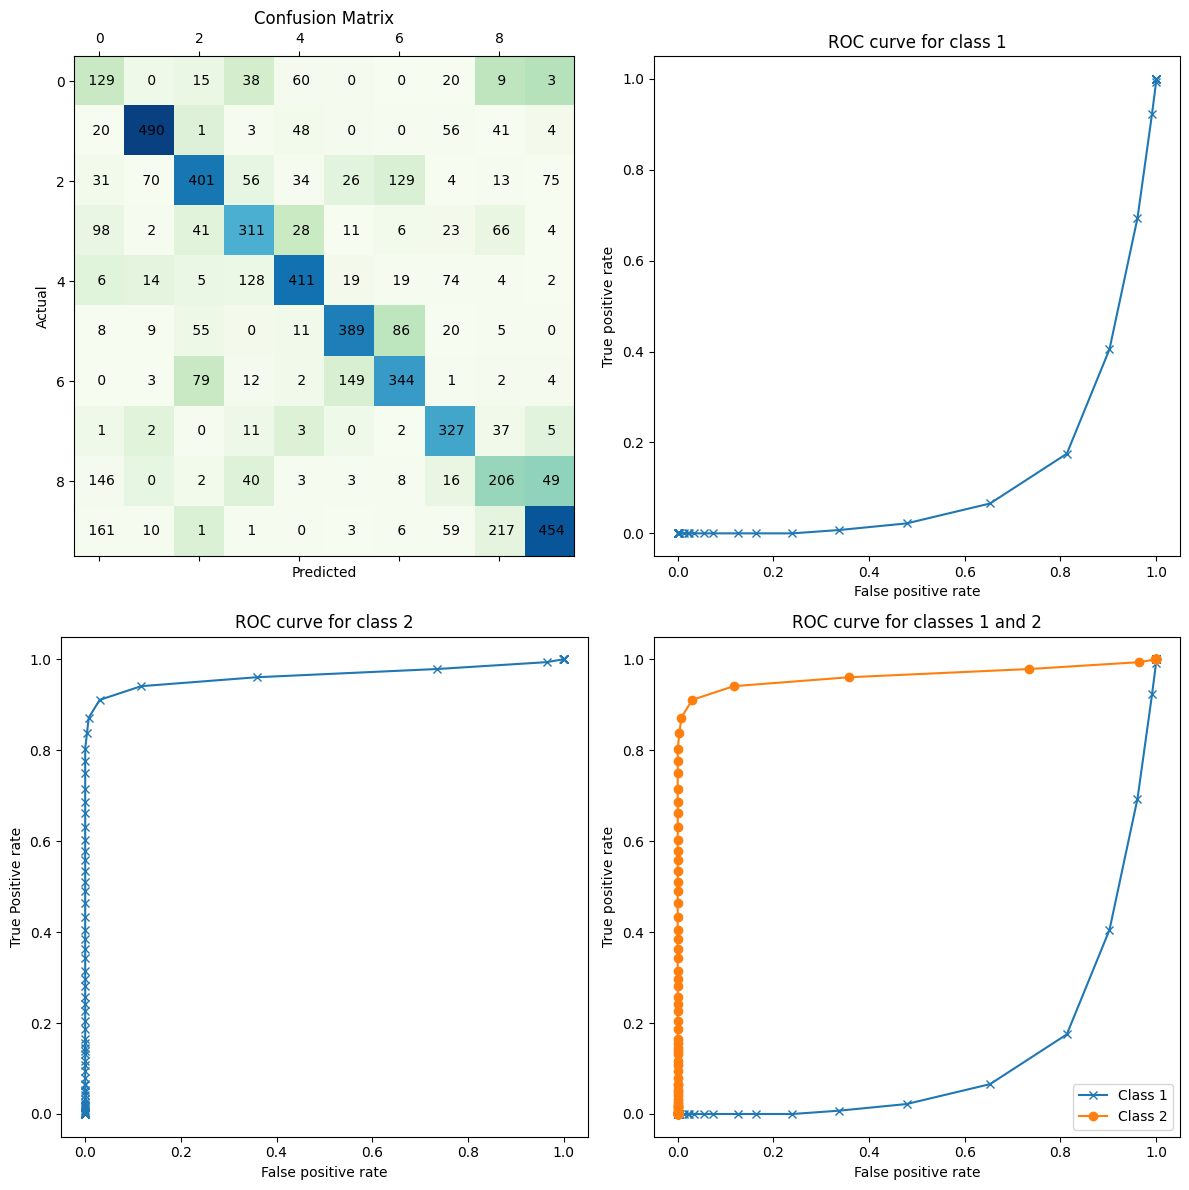

In [228]:
logisticRegressor(p4["splitData"][4])

# P7 (Neural Networks, MLP)

Train an MLP on the PCA counterpart of the KMINST dataset and report your observations

**DATA:** `PCA_MNIST`(KannadaMNISTPCA.csv), (`p5[data]`)

## Data handling

In [337]:
def stats(label, data, stats=False):
    X = data
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

classWiseData = [[] for _ in range(10)]
for row in p5["data"]:
    label = int(row[0])
    classWiseData[label].append(row[1:])
    
p5["splitData"] = [trainTestSplit(np.array(classWiseData), r, stats) for r in [0.2, 0.3, 0.5, 0.7, 0.9]]

## Naive Bayes

In [257]:
p5["result"] = [[] for _ in range(5)]

### Test split -- 20:80

[[1020  103   13   26    0    0    0    4   29    5]
 [  28 1114    1   18    1    0    0    0   21   17]
 [  35    3 1101   10    0   45    0    6    0    0]
 [  27    0   30 1084   21    4   13   16    0    5]
 [   9    1    3   35 1086   44    2    8   10    2]
 [   0    0   17   37   56 1085    2    1    2    0]
 [   1    0    9   58    5    5  875  244    0    3]
 [   6    3    1   59   14    3  227  883    3    1]
 [  66    6    2    6    5    3    1    0 1069   42]
 [  13    5    4   24   20    3    7   21   51 1052]]
[[4163  253   72  150    2    0    2   22  107   29]
 [ 333 3983   21  311   15    0    1    1   41   94]
 [  40    6 4635   10    1   98    0    9    0    1]
 [  59    0   75 4253   13   38  237  118    2    5]
 [   2    2    8  308 4282  139    2    4    8   45]
 [   1   24  126  170  116 4317   12   18   14    2]
 [   5    0   22   29    2   26 4005  708    2    1]
 [  40    1   28  235   19    9 1359 3101    0    8]
 [ 368   78   28  181   30   14    2   16 401

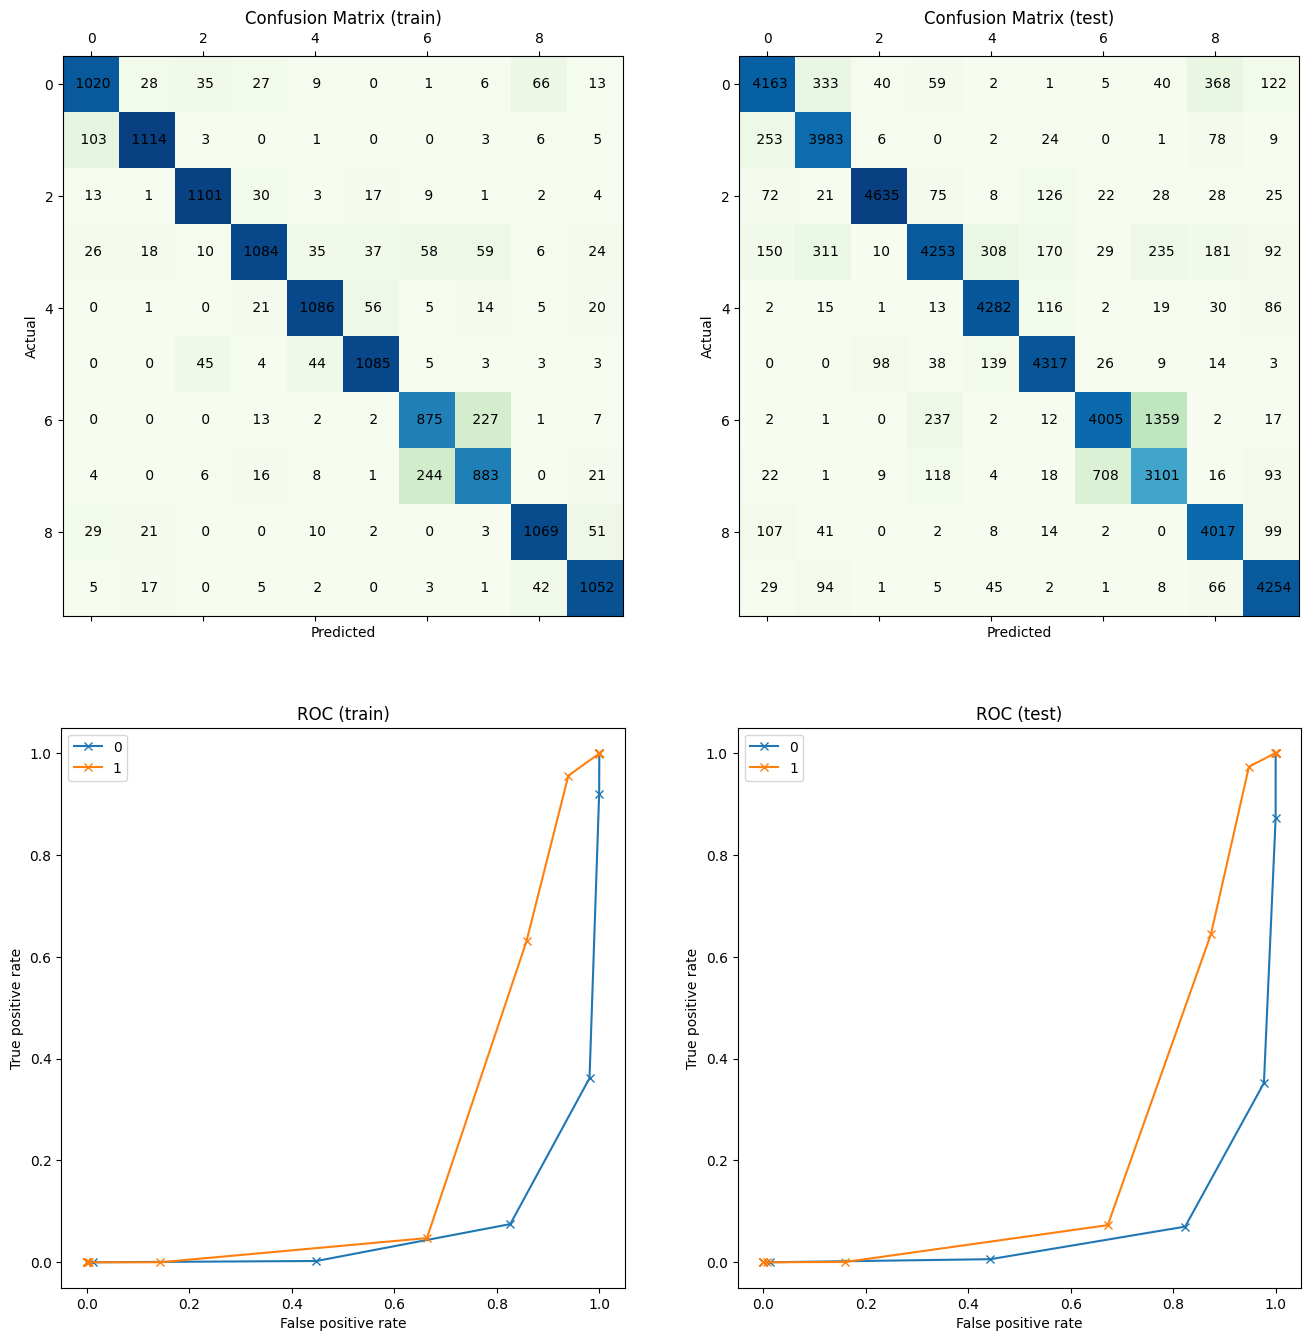

In [258]:
p5["result"][0] = metrics.print(*p5["splitData"][0], naiveLogNormal)

### Test split -- 30:70

In [ ]:
p5["result"][0] = metrics.print(*p5["splitData"][1], naiveLogNormal)

### Test split -- 50:50

[[2496  262   27   87    3    0    0   12   93   20]
 [  96 2683    5   88    6    1    1    1   71   48]
 [  75    8 2782   16    0   91    0   26    2    0]
 [  79    2   25 2680   56   26   57   70    2    3]
 [  10    2    5   72 2766   95    2   19   20    9]
 [   0    3   37  107  100 2725    7    7   14    0]
 [   3    2   10   51   15   32 2305  579    1    2]
 [  37    8    5  113   48    7  670 2103    3    6]
 [ 152   83    8  135   30   11    4   12 2516   49]
 [  42    5    8   37   98    6   18   82  122 2582]]
[[2603  271    3   34    2    0    2   33   43    9]
 [ 140 2637    3  104   22    0    0    2   59   33]
 [  25    6 2810    4    2  151    0    1    0    1]
 [  34    1   17 2763    9   27   81   59    5    4]
 [   0    1    0   48 2776  135    0    6   16   18]
 [   1   18   36   73   62 2788    3    7   11    1]
 [   1    0    2   14    2   19 2537  423    0    2]
 [   6    1   13   91   10    9  939 1931    0    0]
 [ 179   19    3    0    1    5    0    5 277

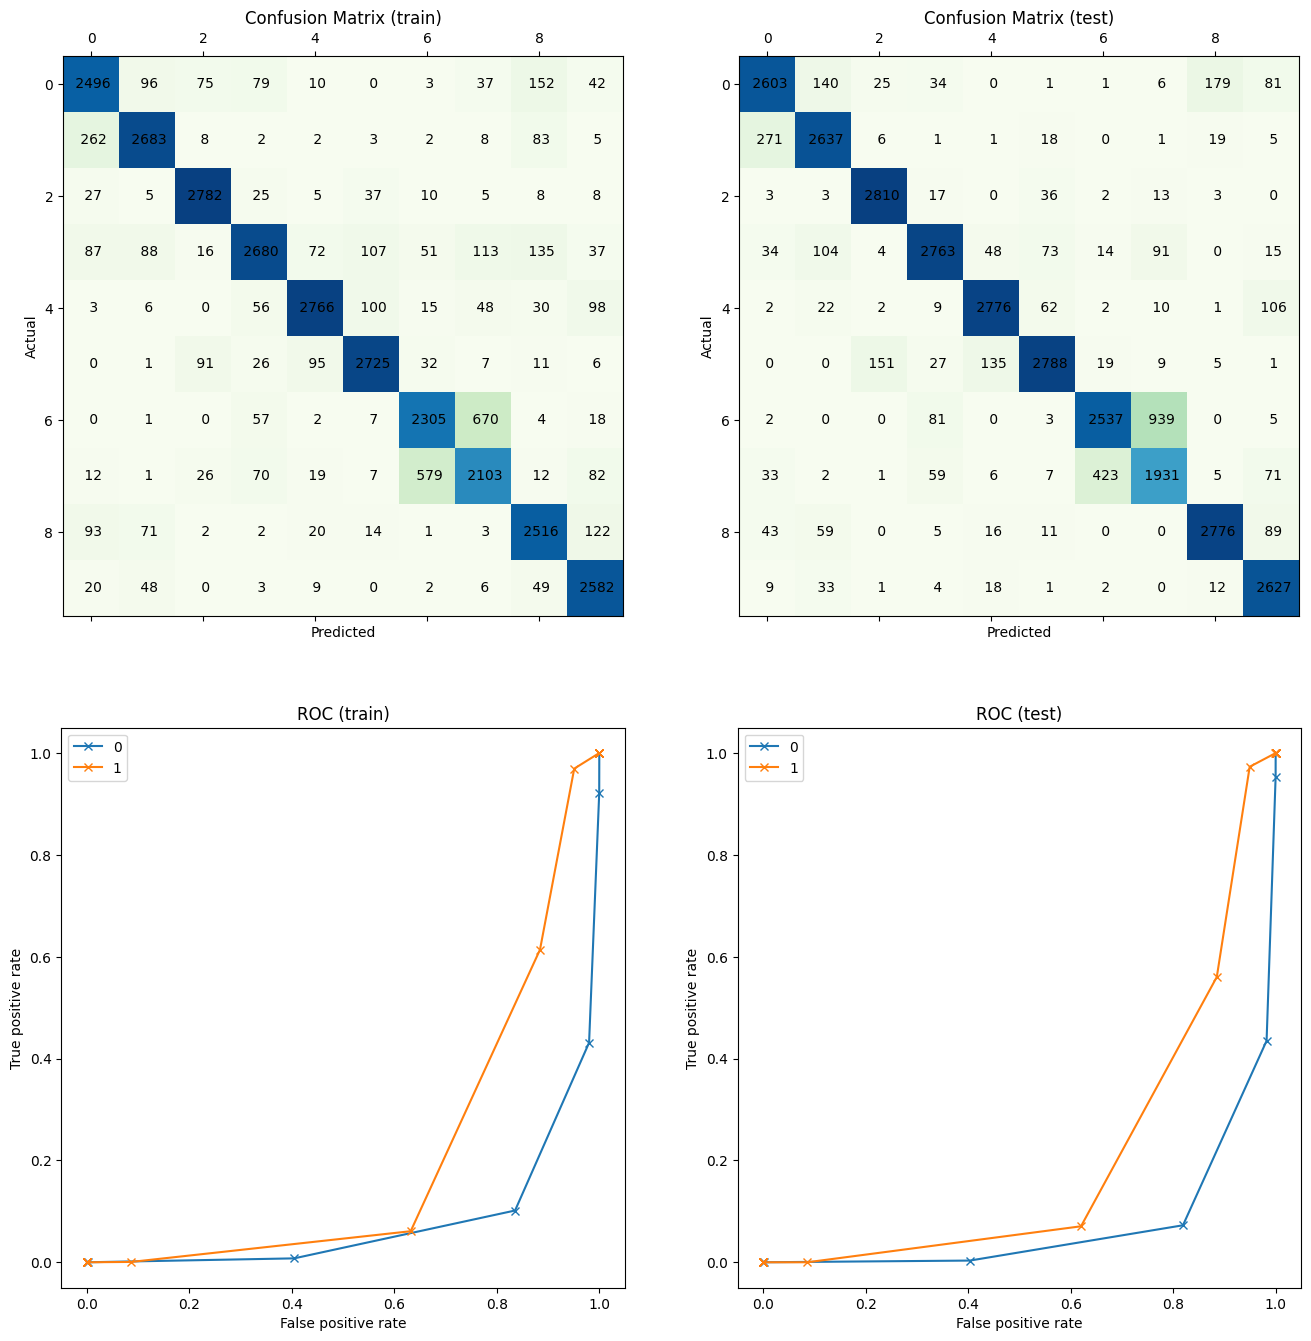

In [259]:
p5["result"][0] = metrics.print(*p5["splitData"][2], naiveLogNormal)

### Test split -- 70:30

In [ ]:
p5["result"][0] = metrics.print(*p5["splitData"][3], naiveLogNormal)

### Test split -- 90:10

[[4560  486   25  100    4    0    2   36  158   29]
 [ 168 4858    9  128   15    1    0    3  136   82]
 [  95    9 5112   16    1  123    0   42    2    0]
 [ 118    4   41 4879   75   44   78  150    2    9]
 [  12    3    7   97 4983  220    1   21   26   30]
 [   1    5   58  188  149 4951    5   16   24    3]
 [   6    1   53   62   20   20 4218 1013    2    5]
 [  62   11   29  189   79   13 1252 3754    3    8]
 [ 305  124   16  155   31   12    3    9 4673   72]
 [ 101   10    7   42  181    6   22  139  191 4701]]
[[579  13   1   3   0   0   0   0   4   0]
 [ 21 485   0  47  13   0   0   0  31   3]
 [ 27   6 550   4   0  10   0   2   0   1]
 [  3   0   1 565   7   1   5  16   0   2]
 [  0   0   0   4 584   7   0   1   4   0]
 [  0  11  29   8   9 538   1   2   2   0]
 [  0   0   3   1   0   3 544  49   0   0]
 [  1   0   5   2   1   0 198 393   0   0]
 [ 28   0   0   0   0   0   0   0 568   4]
 [ 13   0   2   0  16   0   1  10  14 544]]
------------------ Train -------------

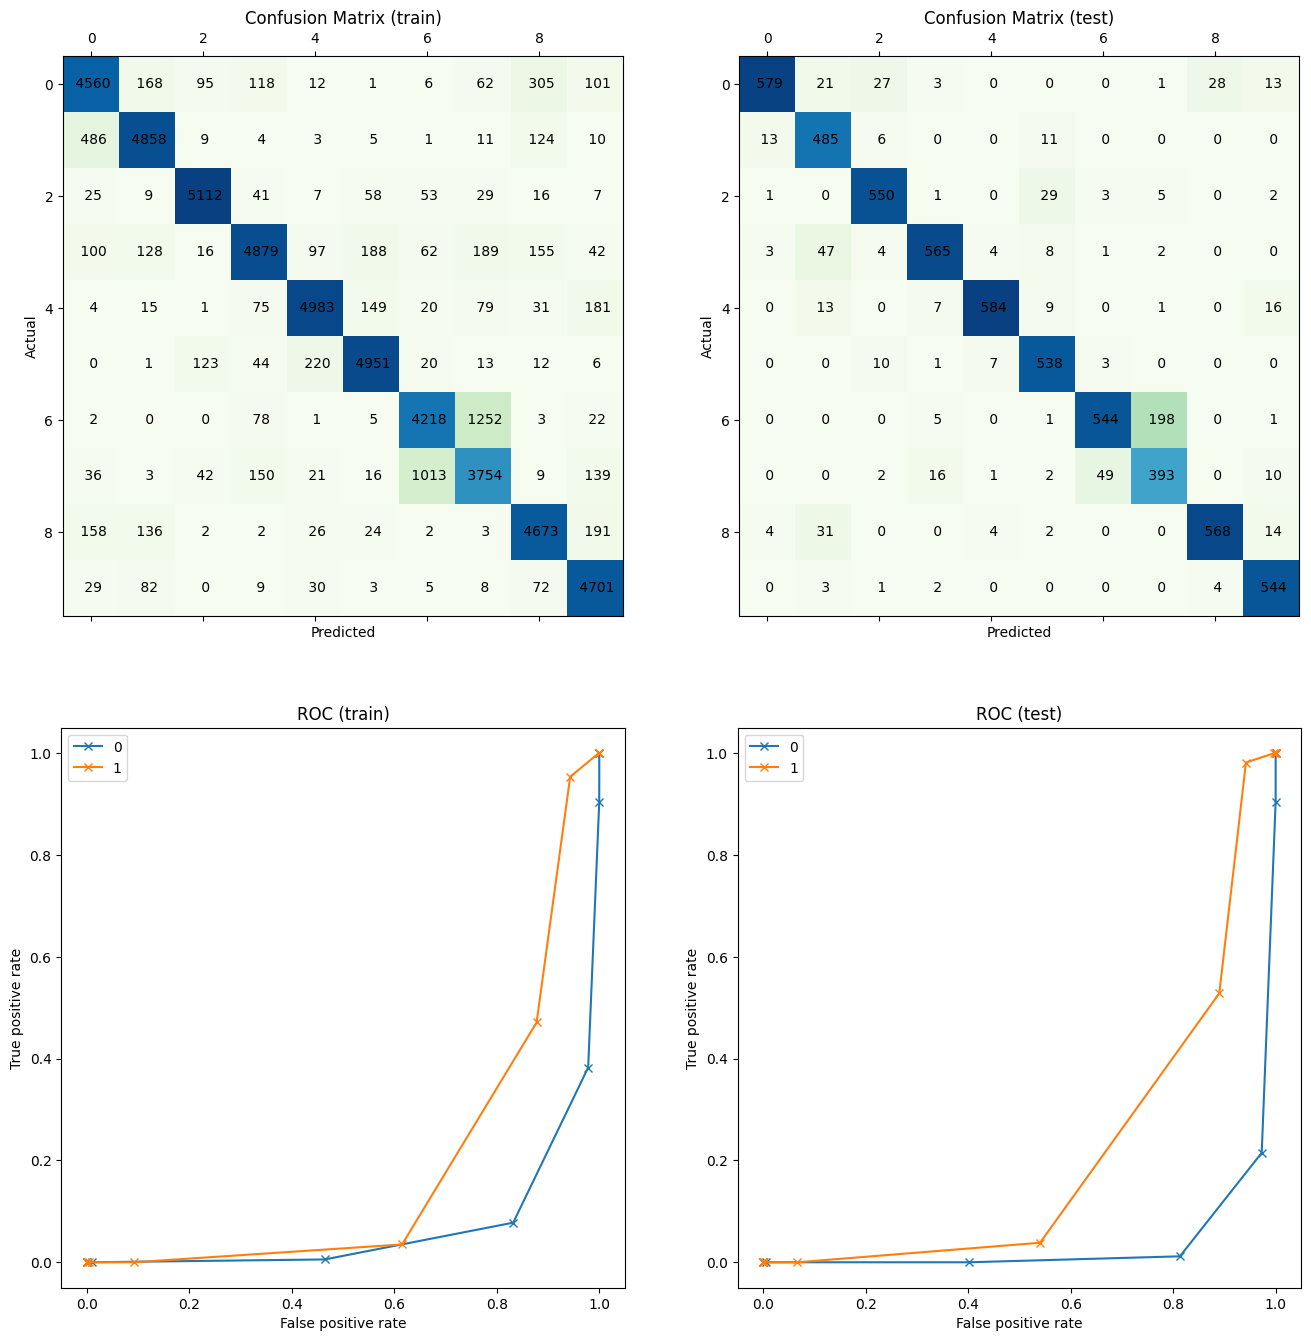

In [260]:
p5["result"][0] = metrics.print(*p5["splitData"][4], naiveLogNormal)

## GMM

### Test split -- 20:80

------------------ Train ---------------------
Classification Accuracy :  0.927
F1 Score                :  [0.89924332 0.92215053 0.96508728 0.92262895 0.93897122 0.96246872
 0.89754445 0.88259783 0.94033412 0.93959731]
------------------ Test ----------------------
Classification Accuracy :  0.9067916666666667
F1 Score                :  [0.89082712 0.89583807 0.94902353 0.88315412 0.9116758  0.92593387
 0.90025839 0.86084808 0.92795969 0.92185403]


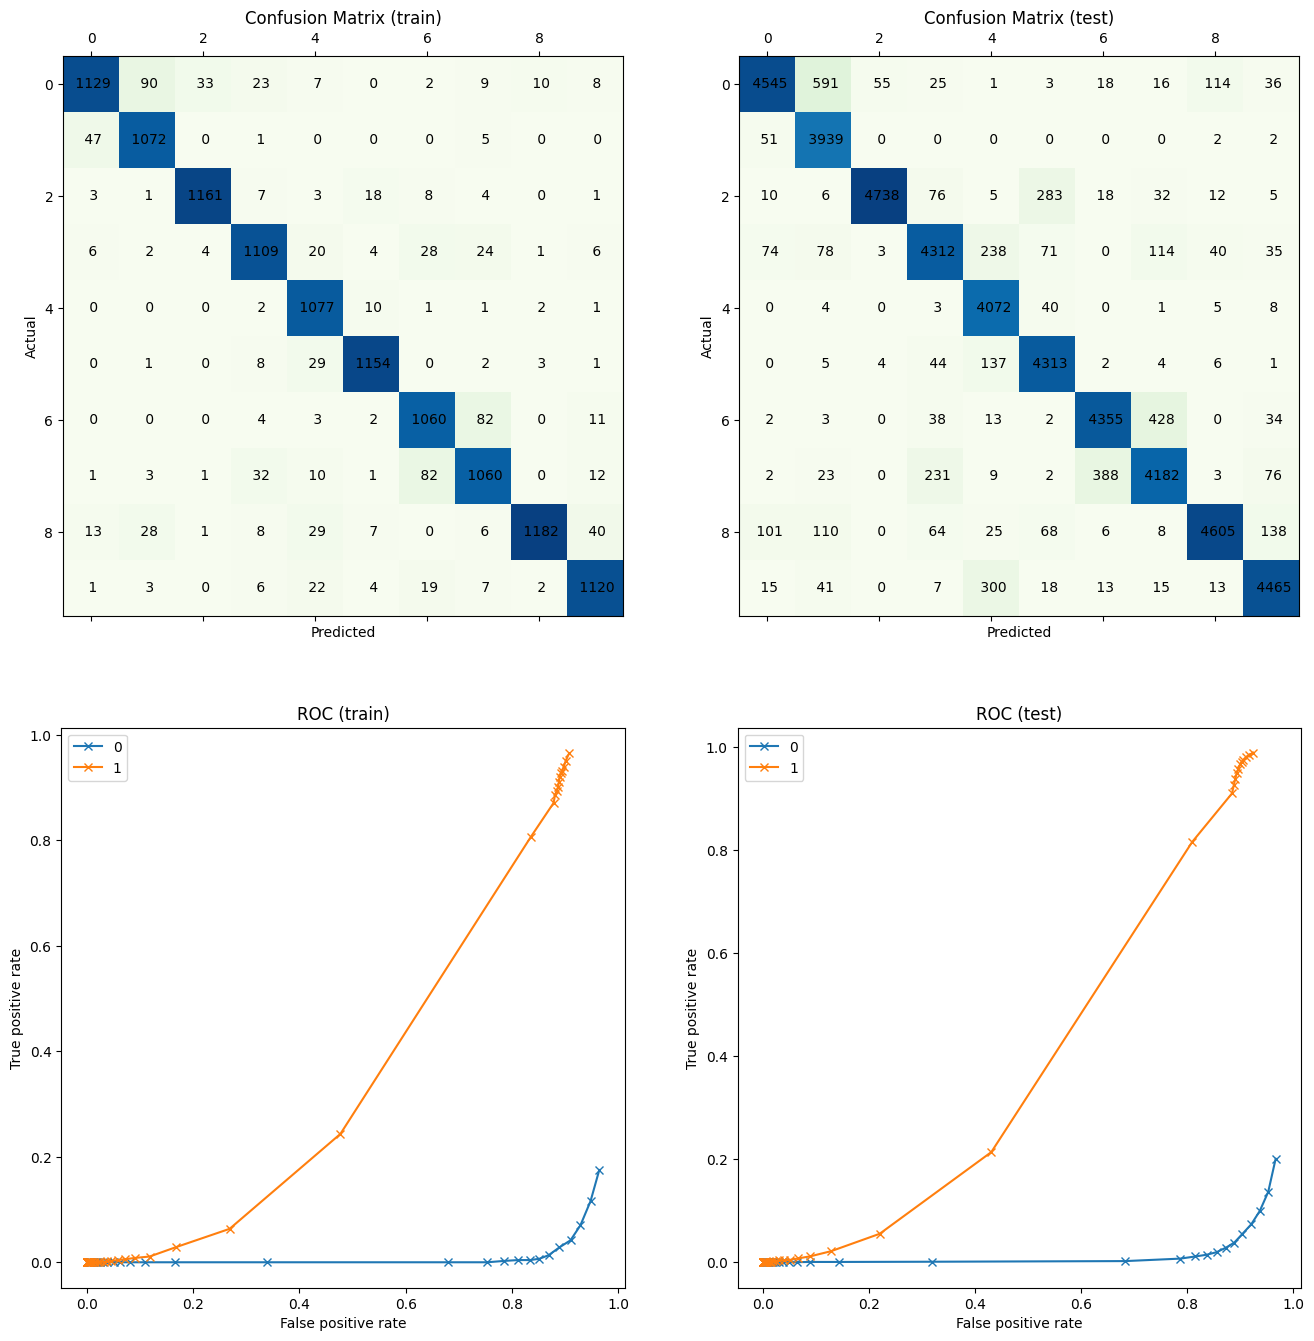

In [338]:
printGmm(p5["splitData"][0])

### Test split -- 30:70

In [ ]:
printGmm(p5["splitData"][1])

### Test split -- 50:50

------------------ Train ---------------------
Classification Accuracy :  0.9195
F1 Score                :  [0.91827782 0.93782205 0.96870342 0.90688668 0.92712906 0.94625434
 0.8890397  0.85890767 0.91726958 0.92625868]
------------------ Test ----------------------
Classification Accuracy :  0.9333666666666667
F1 Score                :  [0.93426847 0.93526435 0.97478716 0.93041545 0.94596003 0.94581117
 0.90591032 0.87825248 0.93673276 0.94749242]


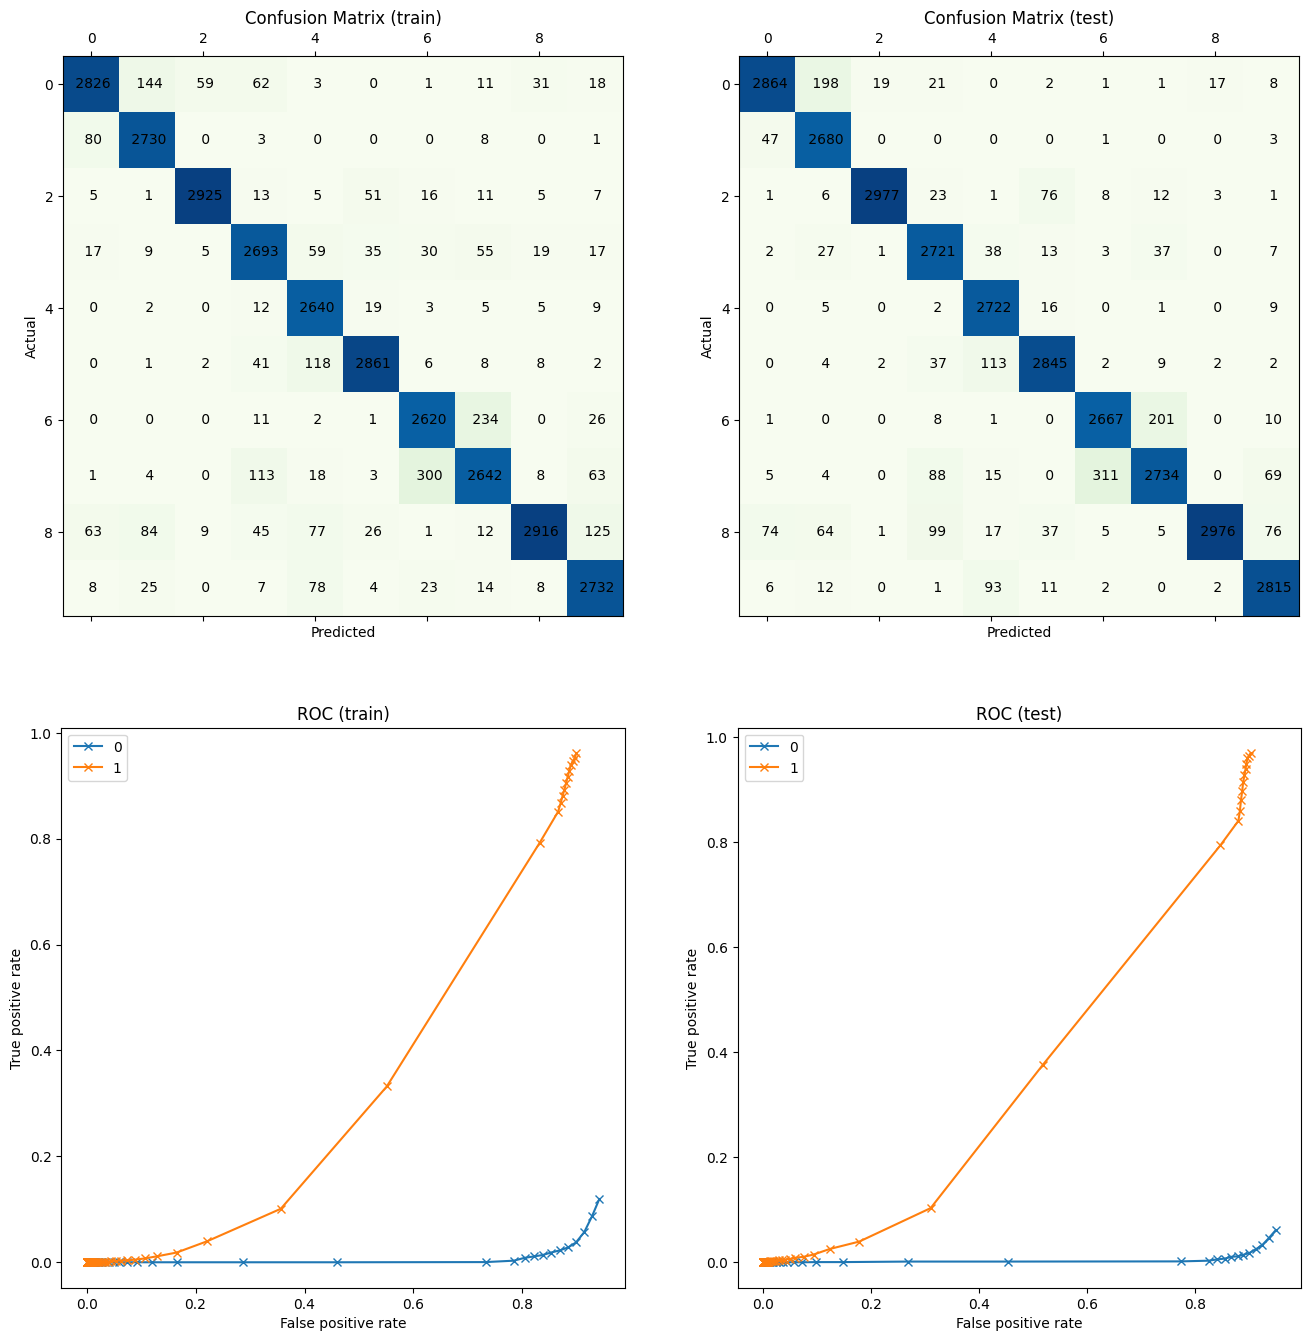

In [340]:
printGmm(p5["splitData"][2])

### Test split -- 70:30

In [ ]:
printGmm(p5["splitData"][3])

### Test split -- 90:10

------------------ Train ---------------------
Classification Accuracy :  0.9318148148148148
F1 Score                :  [0.9291011  0.95001417 0.97836538 0.92279069 0.92968215 0.94826015
 0.90410189 0.8758539  0.94582617 0.93435086]
------------------ Test ----------------------
Classification Accuracy :  0.9575
F1 Score                :  [0.95429029 0.95470383 0.96147403 0.95860927 0.97800338 0.96352841
 0.94197952 0.92221331 0.97398373 0.9673093 ]


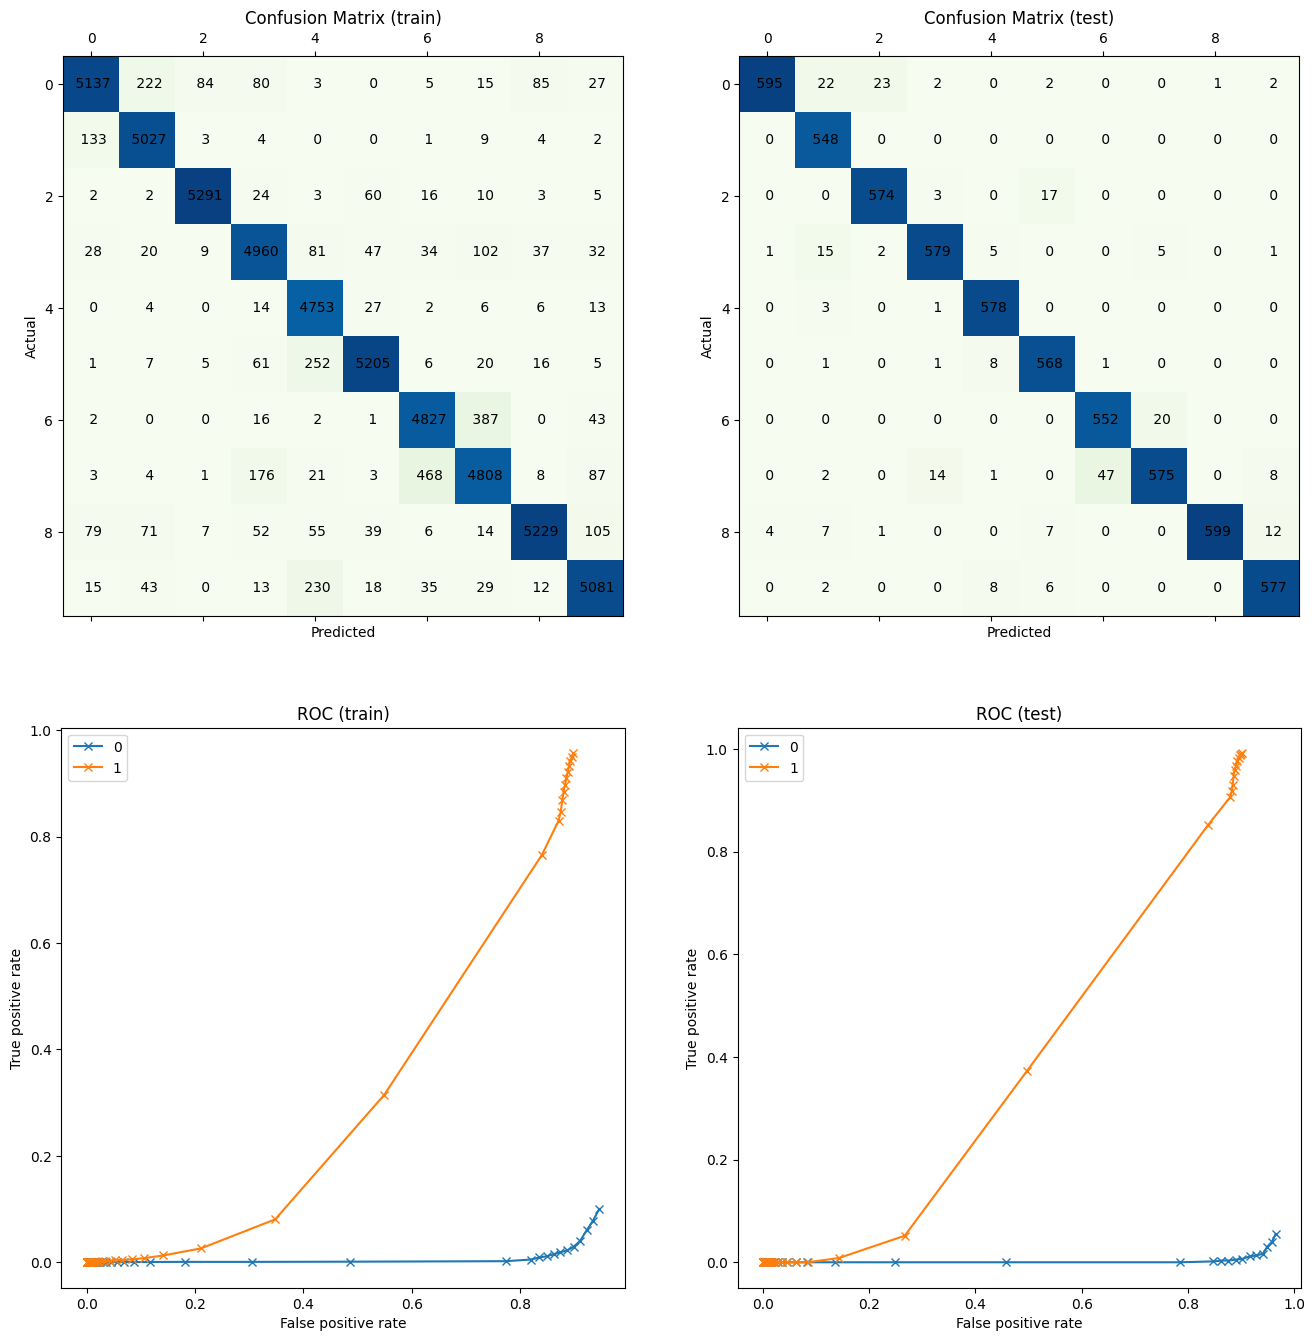

In [341]:
printGmm(p5["splitData"][4])

## Logistic Regression

In [270]:
def logisticRegressor(data):
    X_train,y_train_orig , X_test, y_test_orig, classStats = data
    num_classes = 10
    num_samples = y_train_orig.shape[0]
    y_train = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        y_train[i, int(y_train_orig[i]) - 1] = 1

    # Define sigmoid function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Define softmax function
    def softmax(x):
        # subtract the maximum value from x to avoid overflow
        x -= np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        # divide by the sum of the exponential values along axis 1
        return exp_x / np.sum(exp_x, axis=1, keepdims=True, where=np.isfinite(exp_x))

    # Initialize weights and biases
    num_features = X_train.shape[1]
    W = np.random.randn(num_features, num_classes)
    b = np.random.randn(num_classes)

    # Set hyperparameters
    learning_rate = 0.1
    num_iterations = 1000
    epsilon = 1e-8

    # Train model using gradient descent
    prev_loss = float('inf')
    for i in range(num_iterations):
        # Forward propagation
        z = np.dot(X_train, W) + b
        y_pred = softmax(z)

        # Compute loss
        loss = -np.sum(y_train * np.log(y_pred + epsilon)) / num_samples

        # Backward propagation
        dz = y_pred - y_train
        dW = np.dot(X_train.T, dz) / num_samples
        db = np.sum(dz, axis=0) / num_samples

        # Update weights and biases
        W -= learning_rate * dW
        b -= learning_rate * db

        # Check stopping criterion
        if prev_loss - loss < epsilon:
            print('Stopping criterion met')
            break

        prev_loss = loss

    # Evaluate model on test set
    z = np.dot(X_test, W) + b
    y_pred = np.argmax(softmax(z), axis=1) + 1
    accuracy = np.sum(y_pred == y_test_orig) / y_test_orig.shape[0]
    print('Test accuracy:', accuracy)

    z_train = np.dot(X_train, W) + b
    y_train_pred = np.argmax(softmax(z_train), axis=1) + 1
    train_loss = -np.sum(y_train * np.log(softmax(z_train) + epsilon)) / num_samples
    train_error_rate = 1 - np.sum(y_train_pred == y_train_orig) / y_train_orig.shape[0]
    print('Training empirical risk:', train_loss)
    print('Training error rate:', train_error_rate)

    # Compute empirical risk on test data
    num_samples_test = y_test_orig.shape[0]
    y_test = np.zeros((num_samples_test, num_classes))
    for i in range(num_samples_test):
        y_test[i, int(y_test_orig[i]) - 1] = 1

    z_test = np.dot(X_test, W) + b
    test_loss = -np.sum(y_test * np.log(softmax(z_test) + epsilon)) / num_samples_test
    test_error_rate = 1 - np.sum(y_pred == y_test_orig) / y_test_orig.shape[0]
    print('Test empirical risk:', test_loss)
    print('Test error rate:', test_error_rate)

    num_classes = len(np.unique(y_test_orig))
    confusion_matrix = np.zeros((num_classes, num_classes))
    for i in range(len(y_test_orig)):
        true_class = int(y_test_orig[i] - 1)
        predicted_class = int(y_pred[i] - 1)
        confusion_matrix[true_class, predicted_class] += 1
    print('Confusion matrix:')
    print(confusion_matrix)

    num_classes = len(np.unique(y_test_orig))
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        f1_scores[i] = 2 * precision * recall / (precision + recall + 1e-8)
    print('Class-wise F1 score:')
    print(f1_scores)





 # Choose two classes
    class_1 = 1
    class_2 = 2

    # Get predicted probabilities for the two classes
    y_class_1 = y_test_orig == class_1
    y_class_2 = y_test_orig == class_2
    y_prob_1 = softmax(z_test)[:, class_1 - 1]
    y_prob_2 = softmax(z_test)[:, class_2 - 1]

    # Compute true positive rate and false positive rate for both classes
    num_thresholds = 100
    tpr_class_1 = np.zeros(num_thresholds)
    fpr_class_1 = np.zeros(num_thresholds)
    tpr_class_2 = np.zeros(num_thresholds)
    fpr_class_2 = np.zeros(num_thresholds)

    for i in range(num_thresholds):
        threshold = i / (num_thresholds - 1)
        tp_class_1 = np.sum(y_class_1 & (y_prob_1 > threshold))
        fp_class_1 = np.sum(~y_class_1 & (y_prob_1 > threshold))
        tn_class_1 = np.sum(~y_class_1 & (y_prob_1 <= threshold))
        fn_class_1 = np.sum(y_class_1 & (y_prob_1 <= threshold))
        tpr_class_1[i] = tp_class_1 / (tp_class_1 + fn_class_1)
        fpr_class_1[i] = fp_class_1 / (fp_class_1 + tn_class_1)

        tp_class_2 = np.sum(y_class_2 & (y_prob_2 > threshold))
        fp_class_2 = np.sum(~y_class_2 & (y_prob_2 > threshold))
        tn_class_2 = np.sum(~y_class_2 & (y_prob_2 <= threshold))
        fn_class_2 = np.sum(y_class_2 & (y_prob_2 <= threshold))
        tpr_class_2[i] = tp_class_2 / (tp_class_2 + fn_class_2)
        fpr_class_2[i] = fp_class_2 / (fp_class_2 + tn_class_2)
        
    
    # Plot RoC curves and confusion matrix
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    ax[0, 0].matshow(confusion_matrix, cmap='GnBu')
    ax[0, 0].set_xlabel("Predicted")
    ax[0, 0].set_ylabel("Actual")
    ax[0, 0].set_title("Confusion Matrix")
    for (x, y), value in np.ndenumerate(confusion_matrix):
        ax[0, 0].text(x, y, f"{value: .0f}", va="center", ha="center")


    ax[0, 1].plot(fpr_class_1, tpr_class_1, marker='x')
    ax[0, 1].set_xlabel("False positive rate")
    ax[0, 1].set_ylabel("True positive rate")                     
    ax[0, 1].set_title("ROC curve for class {}".format(class_1))

    ax[1, 0].plot(fpr_class_2, tpr_class_2, marker='x')
    ax[1, 0].set_xlabel("False positive rate")
    ax[1, 0].set_ylabel("True Positive rate")
    ax[1, 0].set_title("ROC curve for class {}".format(class_2))

    ax[1, 1].plot(fpr_class_1, tpr_class_1, marker='x', label="Class {}".format(class_1))
    ax[1, 1].plot(fpr_class_2, tpr_class_2, marker='o', label="Class {}".format(class_2))
    ax[1, 1].set_xlabel("False positive rate")
    ax[1, 1].set_ylabel("True positive rate")
    ax[1, 1].set_title("ROC curve for classes {} and {}".format(class_1, class_2))
    ax[1, 1].legend()

    fig.tight_layout()
    plt.show()





### Test split -- 20:80

Stopping criterion met
Test accuracy: 0.7074583333333333
Training empirical risk: 3.8324481114345343
Training error rate: 0.29300000000000004
Test empirical risk: 3.7755420370753083
Test error rate: 0.2925416666666667
Confusion matrix:
[[4.066e+03 7.000e+00 2.210e+02 2.000e+00 5.000e+00 7.000e+00 2.000e+00
  4.300e+01 7.600e+01 3.710e+02]
 [7.000e+00 4.562e+03 7.000e+00 0.000e+00 1.380e+02 4.000e+00 3.700e+01
  4.000e+00 7.000e+00 3.400e+01]
 [1.000e+00 3.600e+01 4.529e+03 1.000e+00 7.800e+01 1.000e+02 2.000e+00
  1.100e+01 4.000e+00 3.800e+01]
 [2.000e+00 3.000e+00 1.009e+03 3.551e+03 8.800e+01 2.000e+00 0.000e+00
  2.600e+01 1.180e+02 1.000e+00]
 [3.100e+01 1.720e+02 2.270e+02 7.200e+01 4.172e+03 2.000e+01 6.000e+00
  6.000e+01 4.000e+01 0.000e+00]
 [4.000e+00 4.000e+00 2.650e+02 3.000e+00 3.000e+01 4.484e+03 0.000e+00
  4.000e+00 0.000e+00 6.000e+00]
 [4.000e+00 1.500e+01 2.475e+03 4.400e+01 1.500e+01 2.163e+03 4.900e+01
  3.000e+00 4.000e+00 2.800e+01]
 [1.100e+01 4.200e+01 1.090e+

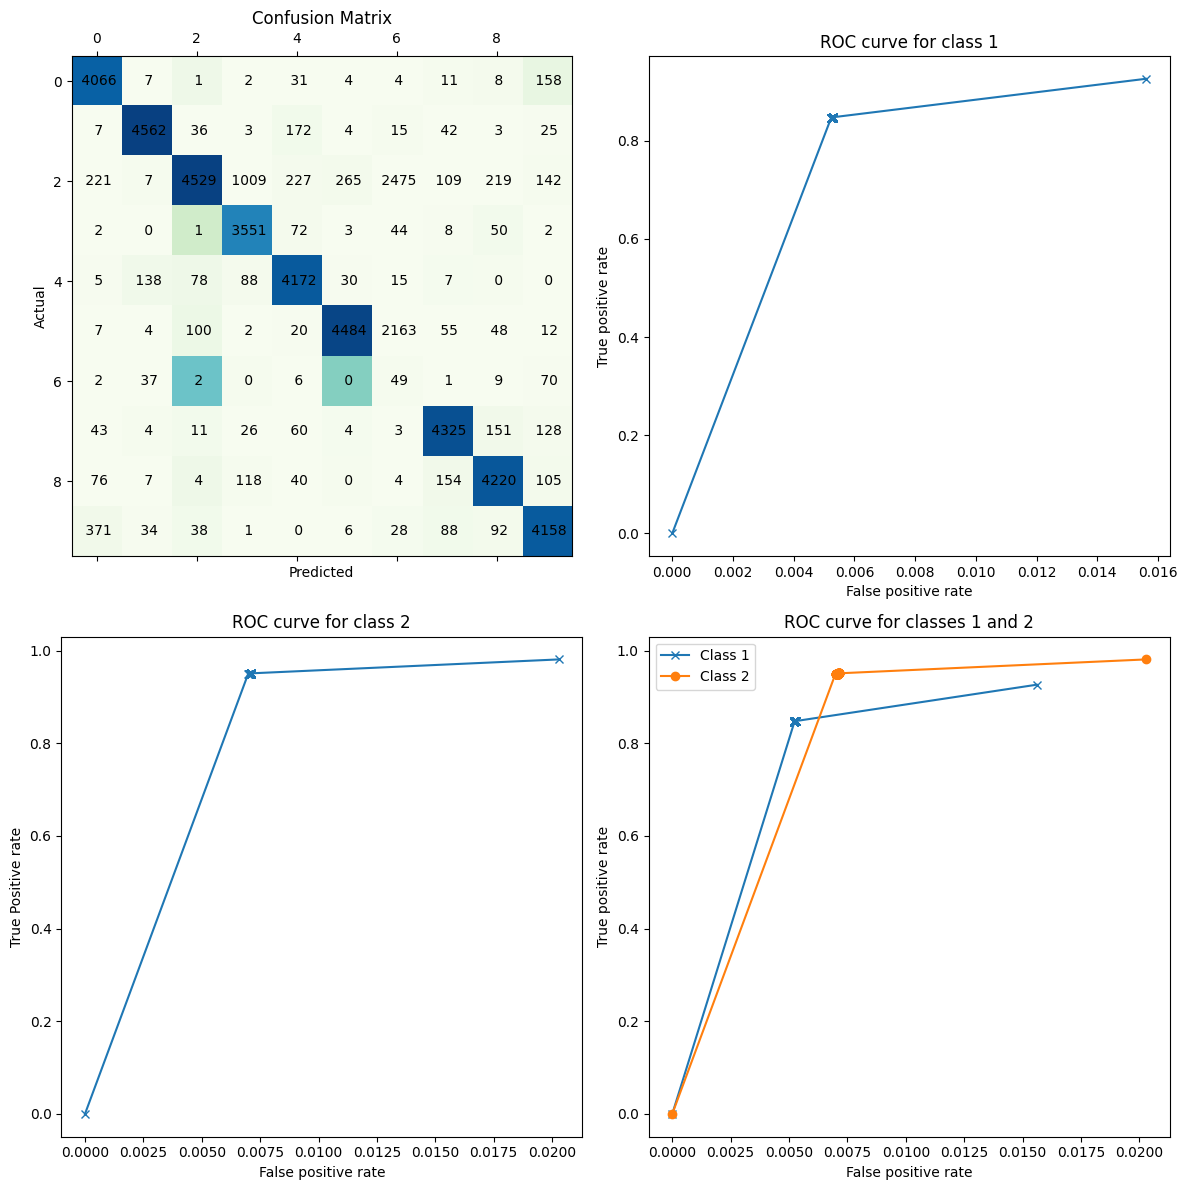

In [271]:
logisticRegressor(p5["splitData"][0])

### Test split -- 30:70

Stopping criterion met
Test accuracy: 0.7103095238095238
Training empirical risk: 3.742552963433856
Training error rate: 0.2840555555555555
Test empirical risk: 3.760913240611453
Test error rate: 0.28969047619047616
Confusion matrix:
[[3.745e+03 1.000e+01 1.410e+02 1.000e+00 4.000e+00 3.600e+01 3.000e+00
  2.300e+01 6.200e+01 1.750e+02]
 [5.000e+00 3.968e+03 1.100e+01 3.000e+00 1.330e+02 0.000e+00 2.500e+01
  1.000e+00 0.000e+00 5.400e+01]
 [1.000e+00 4.600e+01 4.042e+03 1.000e+00 4.600e+01 3.600e+01 1.000e+01
  2.000e+00 5.000e+00 1.100e+01]
 [1.000e+00 7.000e+00 4.440e+02 3.519e+03 9.000e+01 2.900e+01 1.000e+00
  9.000e+00 1.000e+02 0.000e+00]
 [2.000e+00 2.460e+02 1.050e+02 1.350e+02 3.626e+03 2.100e+01 2.300e+01
  3.300e+01 8.000e+00 1.000e+00]
 [2.800e+01 2.800e+01 1.190e+02 1.600e+01 2.100e+01 2.751e+03 1.194e+03
  4.100e+01 1.000e+00 1.000e+00]
 [1.800e+01 9.000e+01 1.688e+03 2.800e+01 1.500e+01 1.618e+03 7.380e+02
  0.000e+00 2.000e+00 3.000e+00]
 [1.800e+01 3.000e+01 1.370e+02

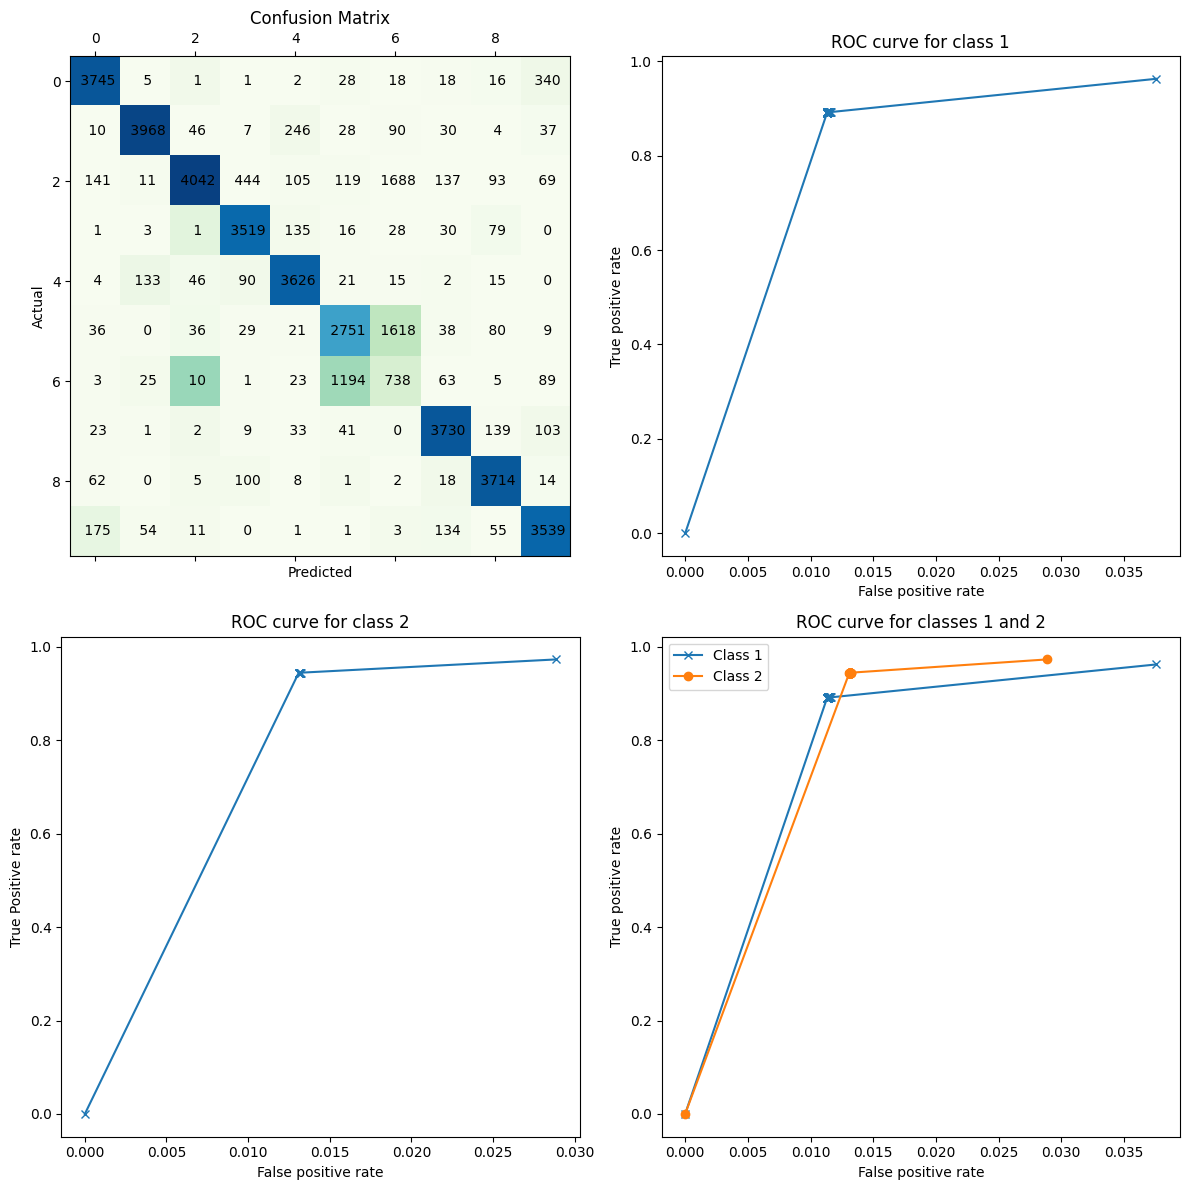

In [272]:
logisticRegressor(p5["splitData"][1])

### Test split -- 50:50

Stopping criterion met
Test accuracy: 0.7297
Training empirical risk: 3.661455047457006
Training error rate: 0.2840666666666667
Test empirical risk: 3.369389114497499
Test error rate: 0.2703
Confusion matrix:
[[2.672e+03 3.000e+00 1.350e+02 4.000e+00 2.000e+00 1.000e+00 0.000e+00
  2.100e+01 3.400e+01 1.280e+02]
 [2.000e+00 2.810e+03 4.000e+00 0.000e+00 1.480e+02 1.000e+00 0.000e+00
  3.000e+00 0.000e+00 3.200e+01]
 [0.000e+00 1.800e+01 2.883e+03 2.000e+00 2.800e+01 2.400e+01 0.000e+00
  2.300e+01 0.000e+00 2.200e+01]
 [2.000e+00 1.000e+00 2.010e+02 2.630e+03 1.350e+02 2.000e+00 0.000e+00
  1.900e+01 1.000e+01 0.000e+00]
 [7.400e+01 8.200e+01 1.250e+02 6.500e+01 2.586e+03 1.000e+00 0.000e+00
  5.800e+01 4.000e+00 5.000e+00]
 [7.000e+00 2.000e+00 6.700e+01 1.000e+00 4.500e+01 2.869e+03 0.000e+00
  7.000e+00 2.000e+00 0.000e+00]
 [5.000e+00 1.100e+01 9.400e+02 1.800e+01 2.700e+01 1.987e+03 7.000e+00
  1.000e+00 0.000e+00 4.000e+00]
 [9.000e+00 7.000e+00 0.000e+00 6.000e+00 7.000e+00 7.00

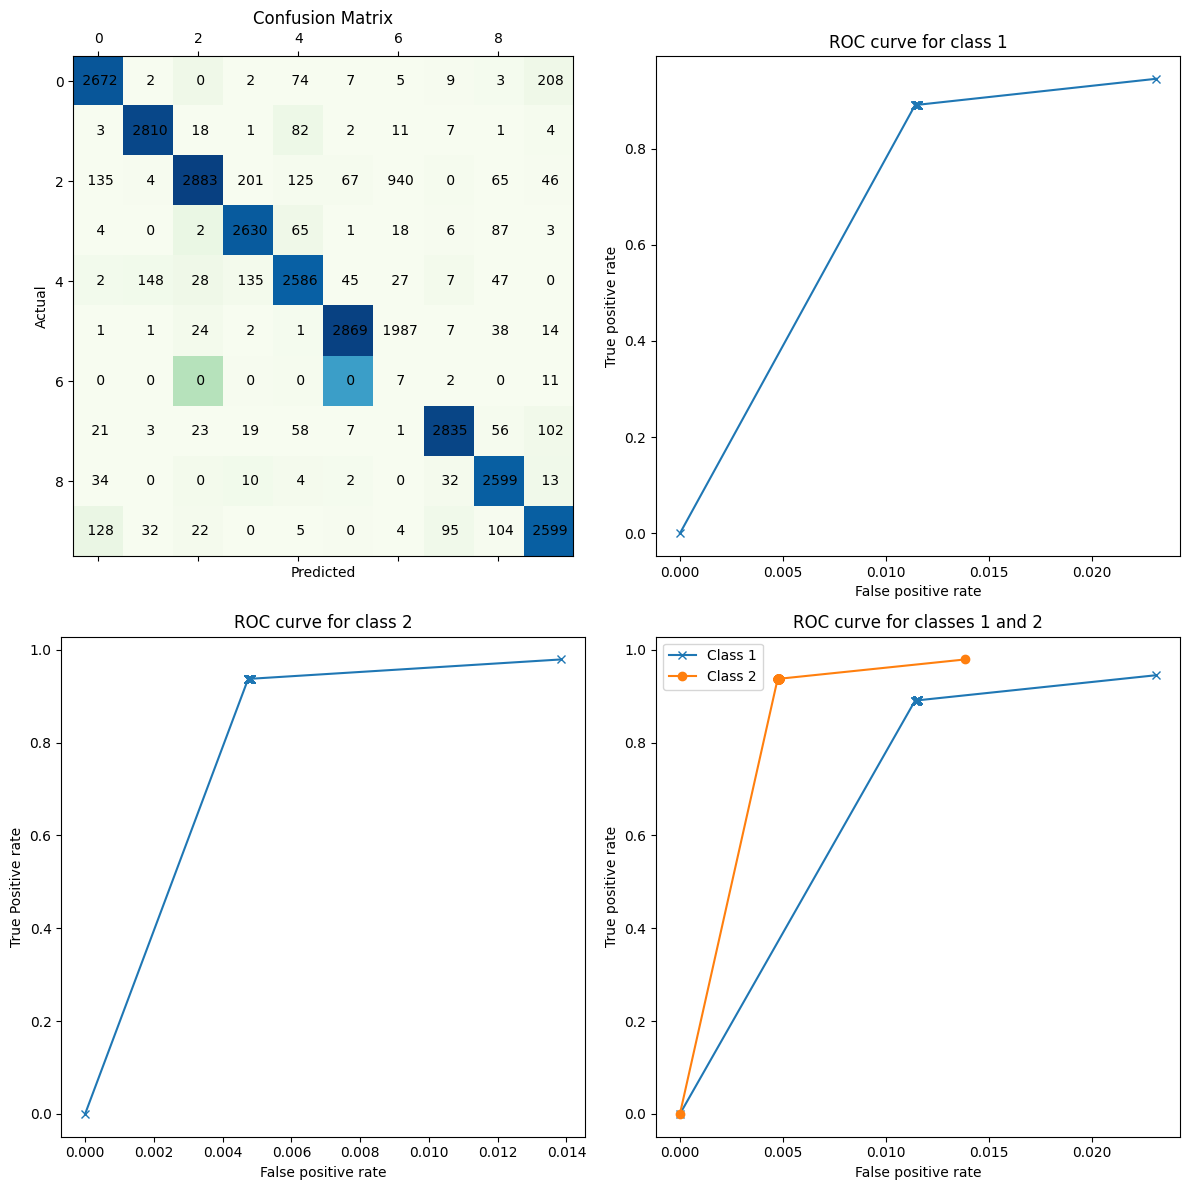

In [273]:
logisticRegressor(p5["splitData"][2])

### Test split -- 70:30

Stopping criterion met
Test accuracy: 0.7270555555555556
Training empirical risk: 3.705701894530877
Training error rate: 0.28647619047619044
Test empirical risk: 3.3654817724009245
Test error rate: 0.27294444444444443
Confusion matrix:
[[1.606e+03 3.000e+00 6.800e+01 1.600e+01 2.000e+00 5.000e+00 1.000e+00
  1.500e+01 1.500e+01 6.900e+01]
 [3.000e+00 1.639e+03 2.000e+00 1.000e+00 9.800e+01 7.000e+00 0.000e+00
  3.000e+00 0.000e+00 4.700e+01]
 [0.000e+00 1.300e+01 1.261e+03 5.000e+00 3.300e+01 4.720e+02 7.000e+00
  1.000e+00 0.000e+00 8.000e+00]
 [0.000e+00 0.000e+00 4.000e+00 1.719e+03 2.600e+01 1.100e+01 1.000e+00
  1.000e+00 3.800e+01 0.000e+00]
 [1.100e+01 3.100e+01 3.000e+01 5.000e+01 1.658e+03 6.000e+00 1.000e+00
  5.000e+00 7.000e+00 1.000e+00]
 [0.000e+00 7.000e+00 1.000e+00 1.000e+00 1.900e+01 1.771e+03 0.000e+00
  0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 1.300e+01 1.200e+01 6.000e+00 1.700e+01 1.671e+03 8.000e+01
  0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 2.200e+01 0.000e+

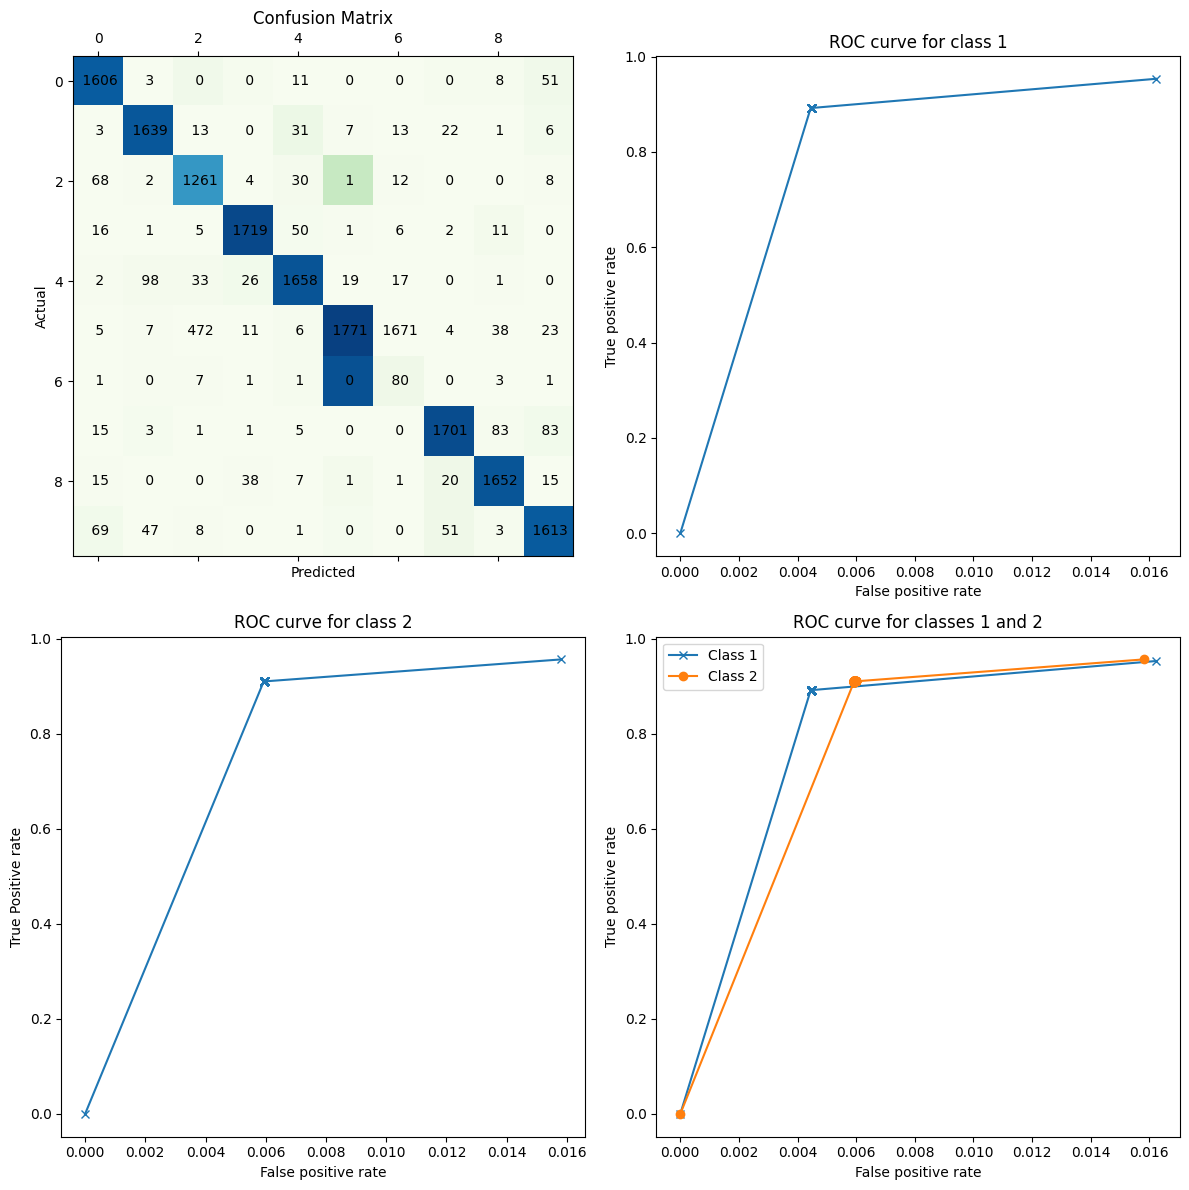

In [274]:
logisticRegressor(p5["splitData"][3])

### Test split -- 90:10

Stopping criterion met
Test accuracy: 0.725
Training empirical risk: 3.5305955081142657
Training error rate: 0.27927777777777774
Test empirical risk: 3.270727919592682
Test error rate: 0.275
Confusion matrix:
[[523.   0.  29.   1.   0.   0.   0.   8.  11.  28.]
 [  2. 543.   4.   0.  10.   2.   1.   2.   0.  36.]
 [  4.   2. 548.   3.   1.  30.   0.   0.   1.  11.]
 [  0.   0.  37. 534.   4.   0.   0.   5.  20.   0.]
 [ 11.  78.   7.  14. 478.   4.   0.   6.   2.   0.]
 [  0.   1.   1.   0.   3. 595.   0.   0.   0.   0.]
 [  0.   4.  71.   0.   0. 523.   0.   1.   0.   1.]
 [  0.   5.   0.   0.   0.   3.   0. 574.   1.  17.]
 [  0.   1.   3.   5.   1.   7.   0.  19. 555.   9.]
 [  9.   0.   2.   0.   0.   2.   0.   9.   0. 578.]]
Class-wise F1 score:
[0.91035683 0.88006482 0.84178187 0.92307692 0.87146763 0.67383918
 0.         0.93790849 0.9327731  0.903125  ]


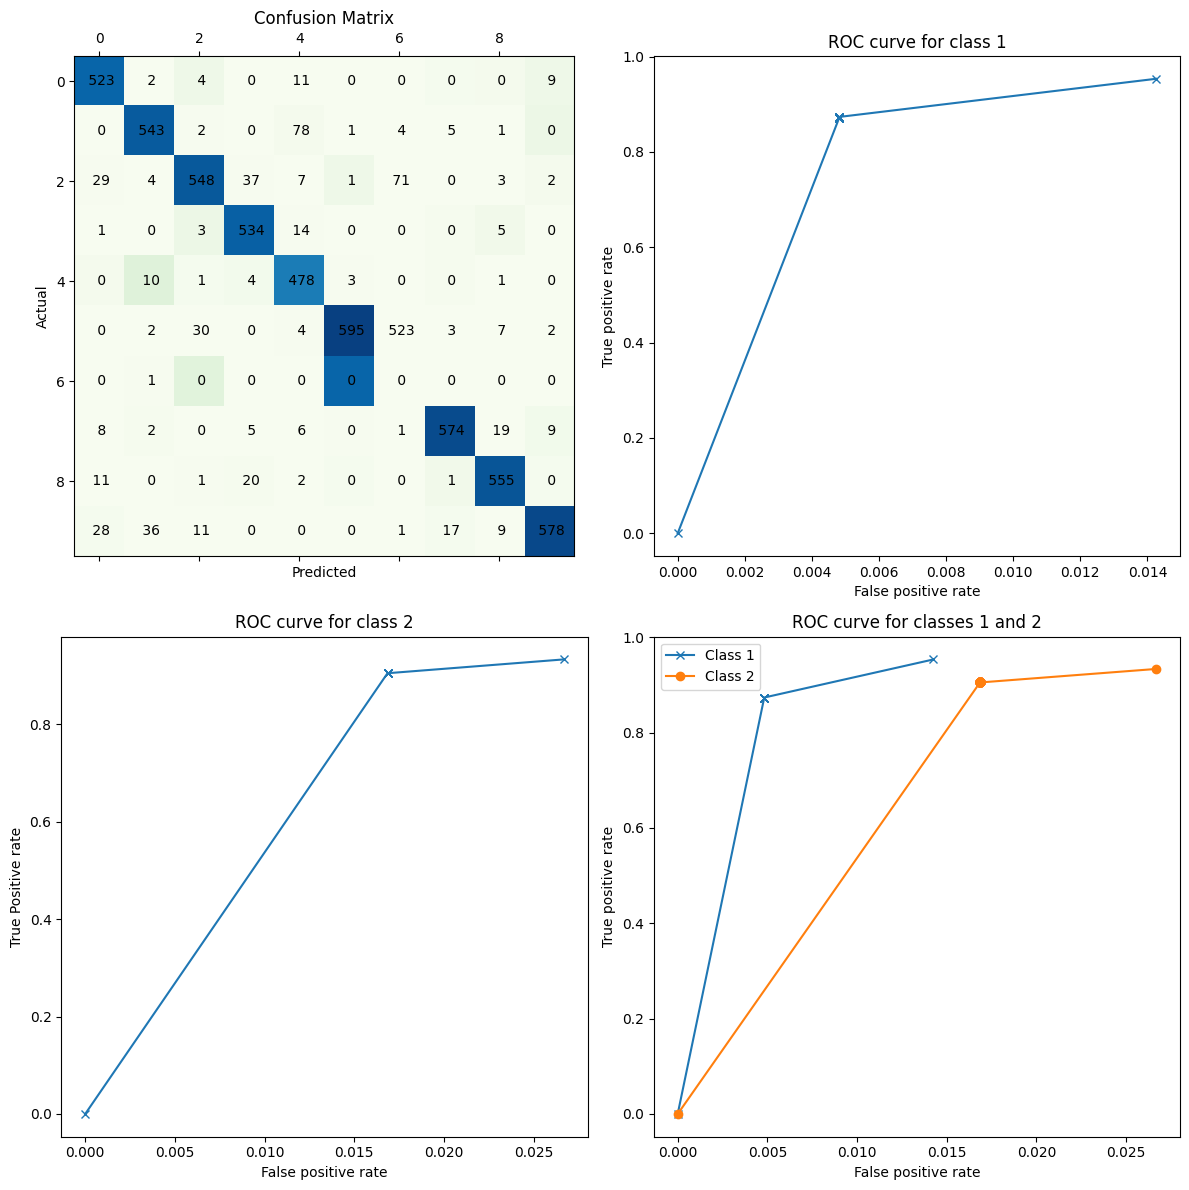

In [275]:
logisticRegressor(p5["splitData"][4])